## TODO
### Plumbing
- [DONE] add 'selected' column to dataframes, discard exp16 GAL pictures
- [DONE] remove cells straddling the border (implemented, needs a rerun)
- [DONE] make sure replicate colors are consistent (e.g. add pseudo-counts for absent replicate)
### Sanity checks
- [DONE] compare plots with original spots and decomposed spots
- [DONE] inspect cells with very high numbers of mRNAs
- [DONE] GAL exp16 09 has 140/143 cells with hipBA????
### Plots
- [DONE] expression/concentrations versus area/eccentricity
- [DONE] expression/concentrations versus growth rate
- plots: distance to centroid/wall/tip 
### Reprocess
- [DONE] compute cell area on non-expanded masks
- [DONE] recompute concentrations with volumes
### Gaurav's points
- sacculi
- add random cells just before fixing to estimate background
- estimate how many mRNAs overall are in a cell for each condition => what fraction of the whole mRNA population is our mRNA of interest 
- use CCCP to cause stress

## Setup

### Imports

In [2]:
from pathlib import Path

import pandas as pd
import re
import logging
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import zscore
#from IPython.utils import io

pd.options.display.precision = 2

In [3]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "/Volumes/Flodrive/Florence/smFISH/analysis"

logging.info(f'reading from directory {rootdir}')

12/02/2024 08:23:03AM [INFO] reading from directory /Volumes/Flodrive/Florence/smFISH/analysis 


### Constants

In [4]:
conditions = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'MAN', 'mu': 0.12},
]
csources_ordered = [c['label'] for c in conditions]

conditions_d = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'glucose', 'mu': 0.54},
    {'label': 'glycerol', 'mu': 0.32},
    {'label': 'galactose', 'mu': 0.17},
    {'label': 'mannose', 'mu': 0.12},
]
csources_ordered_d = [c['label'] for c in conditions_d]

growth_rates = {c['label']: c['mu'] for c in conditions}
mrna_ordered = ['rpoD', 'rnlAB', 'hipBA']
replicates_ordered = ['exp16', 'exp22', 'exp24']

display_labels = {
    'MAN': 'mannose',
    'GAL': 'galactose',
    'GLY': 'glycerol',
    'GLU': 'glucose',
    'LB': 'LB',
}

scale = [0.2, 0.065, 0.065]

### Palettes

In [6]:
palette_mrna = {
    'rpoD': 'magenta',
    'rnlAB': 'cyan',
    'hipBA': 'yellow',
}
palette_replicate = { z[0]: z[1] for z in zip(replicates_ordered, sns.color_palette("hls", len(replicates_ordered))) }
palette_csource = { z[0]: z[1] for z in zip(csources_ordered, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource_d = { z[0]: z[1] for z in zip(csources_ordered_d, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource_d

{'LB': (0.267968, 0.223549, 0.512008),
 'glucose': (0.190631, 0.407061, 0.556089),
 'glycerol': (0.127568, 0.566949, 0.550556),
 'galactose': (0.20803, 0.718701, 0.472873),
 'mannose': (0.565498, 0.84243, 0.262877)}

# Results

## Load data

#### Stacked format
- format with 1 row per cell and per mrna
- mrna is specified in 'mrna' column
- so this df has about 3x total number of cells rows (because we have 3 rna channels)

In [7]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    cell_df = pd.read_csv(f.parent / "cells.csv")
    for mrna in mrna_ordered:
        f_mrna = Path(str(f) + f'.{mrna}')
        logging.info(f'..loading file: {f_mrna}')
        df = pd.read_csv(f_mrna)
        df['image'] = f_mrna.parts[-2]
        df['experiment'] = f_mrna.parts[-3]
        df = df.join(cell_df.set_index('image_cell_id'), on='image_cell_id')
        dfs.append(df)
df_stacked = pd.concat(dfs)

12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rpoD 
12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rnlAB 
12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.hipBA 
12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rpoD 
12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rnlAB 
12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.hipBA 
12/02/2024 08:23:24AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv.rpoD 
12

In [8]:
pattern = re.compile(f'(?P<strain>[0-9A-Za-z]+)[_-](?P<csource>{"|".join(csources_ordered)})[-_](?P<coverslip>.*)')

def parse_image_name(r):
    s = r['image']
    match = pattern.search(s)
    d = match.groupdict()
    
    seqnr = re.search('(?P<seqnr>[0-9]+)$', d['coverslip'])[0]
    d['coverslip'] = re.sub('_[0-9]+$', '', d['coverslip'])
    return d['strain'], d['csource'], d['coverslip'], seqnr

df_stacked[['strain', 'csource', 'coverslip', 'seqnr']] = df_stacked.apply(parse_image_name, axis=1, result_type='expand')
df_stacked['strain'] = 'MG1655'
df_stacked['replicate'] = df_stacked['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_stacked.loc[df_stacked['csource'] == 'LB', 'replicate'] = 'exp22'
df_stacked['unique_cell_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_stacked['unique_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']) + "." + r['mrna'], axis=1)
df_stacked['selected'] = True

# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_stacked.loc[(df_stacked['experiment']=='20241003-exp16'), "selected"] = False
df_stacked = df_stacked[df_stacked['selected']]

df_stacked['volume'] = 4 / 3 * np.pi * pow(df_stacked['axis_minor_length'] / 2, 3) + np.pi * pow(df_stacked['axis_minor_length'] / 2, 2) * (df_stacked['axis_major_length'] - df_stacked['axis_minor_length'])
df_stacked['volume_ellipsoid'] = 4 / 3 * df_stacked['area'] * df_stacked['axis_minor_length'] / 2

df_stacked['axis_major_length'] = df_stacked['axis_major_length'] * scale[1]
df_stacked['area'] = df_stacked['area'] * scale[1] * scale[2]
df_stacked['volume'] = df_stacked['volume'] * scale[0] * scale[1] * scale[2]
df_stacked['volume_ellipsoid'] = df_stacked['volume_ellipsoid'] * scale[0] * scale[1] * scale[2]
# # remove one LB outlier that caused a lot of misery
# df_stacked = df_stacked[df_stacked['volume'] < 2e5]


df_stacked['RNAs_over_area'] = df_stacked['total_RNAs'] / df_stacked['area']
df_stacked['RNAs_over_vol'] = df_stacked['total_RNAs'] / df_stacked['volume']
df_stacked['RNAs_over_length'] = df_stacked['total_RNAs'] / df_stacked['axis_major_length']
df_stacked['RNAs_over_eccentricity'] = df_stacked['total_RNAs'] / df_stacked['eccentricity']

df_stacked['mu'] = df_stacked.apply(lambda r: growth_rates[r['csource']], axis=1)
df_stacked['tau (h)'] = np.log(2) / df_stacked['mu']
df_stacked['tau (min)'] = df_stacked['tau (h)'] * 60

df_stacked['csource_d'] = df_stacked['csource'].apply(lambda x: display_labels[x])

df_stacked


image_cell_id  spots  dense_regions  decomposed_RNAs  tx  nascent_RNAs  \
0              531      0              0                0   0             0   
1              533      0              0                0   0             0   
2              535      0              0                0   0             0   
3              537      0              0                0   0             0   
4              540      0              0                0   0             0   
..             ...    ...            ...              ...  ..           ...   
546           2163      1              0                0   0             0   
547           2166      1              0                0   0             0   
548           2168      2              0                0   0             0   
549           2177      0              0                0   0             0   
550           2179      0              0                0   0             0   

     total_RNAs   mrna  strain                    condition  ... volume  \
0             0   rpoD  MG1655                          GLU  ...   3.80   
1             0   rpoD  MG1655                          GLU  ...   5.38   
2             0   rpoD  MG1655                          GLU  ...   5.86   
3             0   rpoD  MG1655                          GLU  ...   4.24   
4             0   rpoD  MG1655                          GLU  ...   3.63   
..          ...    ...     ...                          ...  ...    ...   
546           1  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   3.91   
547           1  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...  10.32   
548           2  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   6.27   
549           0  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   8.11   
550           0  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   4.57   

    volume_ellipsoid RNAs_over_area  RNAs_over_vol  RNAs_over_length  \
0               2.96           0.00           0.00              0.00   
1               4.25           0.00           0.00              0.00   
2               4.17           0.00           0.00              0.00   
3               3.18           0.00           0.00              0.00   
4               2.67           0.00           0.00              0.00   
..               ...            ...            ...               ...   
546             3.00           0.68           0.26              0.51   
547             9.84           0.37           0.10              0.52   
548             4.36           0.97           0.32              0.71   
549             6.17           0.00           0.00              0.00   
550             3.65           0.00           0.00              0.00   

     RNAs_over_eccentricity    mu  tau (h)  tau (min)  csource_d  
0                      0.00  0.54     1.28      77.02    glucose  
1                      0.00  0.54     1.28      77.02    glucose  
2                      0.00  0.54     1.28      77.02    glucose  
3                      0.00  0.54     1.28      77.02    glucose  
4                      0.00  0.54     1.28      77.02    glucose  
..                      ...   ...      ...        ...        ...  
546                    1.16  2.30     0.30      18.08         LB  
547                    2.51  2.30     0.30      18.08         LB  
548                    2.15  2.30     0.30      18.08         LB  
549                    0.00  2.30     0.30      18.08         LB  
550                    0.00  2.30     0.30      18.08         LB  

[48624 rows x 52 columns]

In [9]:
df_stacked.shape

(48624, 52)

In [10]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'csource',
       'coverslip', 'replicate', 'unique_cell_id', 'unique_id', 'selected',
       'volume', 'volume_ellipsoid', 'RNAs_over_area', 'RNAs_over_vol',
       'RNAs_over_length', 'RNAs_over_eccentricity', 'mu', 'tau (h)',
       'tau (min)', 'csource_d'],
      dtype='object')

In [11]:
df_stacked.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       541, 542, 543, 544, 545, 546, 547, 548, 549, 550],
      dtype='int64', length=48624)

In [12]:
df_stacked = df_stacked.set_index('unique_id')
df_stacked

image_cell_id  spots  \
unique_id                                                                  
exp24.exp24-GLU-right-2_01.531.rpoD                           531      0   
exp24.exp24-GLU-right-2_01.533.rpoD                           533      0   
exp24.exp24-GLU-right-2_01.535.rpoD                           535      0   
exp24.exp24-GLU-right-2_01.537.rpoD                           537      0   
exp24.exp24-GLU-right-2_01.540.rpoD                           540      0   
...                                                           ...    ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2163      1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2166      1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2168      2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...           2177      0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...           2179      0   

                                                    dense_regions  \
unique_id                                                           
exp24.exp24-GLU-right-2_01.531.rpoD                             0   
exp24.exp24-GLU-right-2_01.533.rpoD                             0   
exp24.exp24-GLU-right-2_01.535.rpoD                             0   
exp24.exp24-GLU-right-2_01.537.rpoD                             0   
exp24.exp24-GLU-right-2_01.540.rpoD                             0   
...                                                           ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...              0   

                                                    decomposed_RNAs  tx  \
unique_id                                                                 
exp24.exp24-GLU-right-2_01.531.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.533.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.535.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.537.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.540.rpoD                               0   0   
...                                                             ...  ..   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...                0   0   

                                                    nascent_RNAs  total_RNAs  \
unique_id                                                                      
exp24.exp24-GLU-right-2_01.531.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.533.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.535.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.537.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.540.rpoD                            0           0   
...                                                          ...         ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...             0           1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...             0           1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...             0           2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...             0           0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...             0           0   

                                                     mrna  strain  \
unique_id                                                           
exp24.exp2

In [13]:
df_stacked.index.unique()

Index(['exp24.exp24-GLU-right-2_01.531.rpoD',
       'exp24.exp24-GLU-right-2_01.533.rpoD',
       'exp24.exp24-GLU-right-2_01.535.rpoD',
       'exp24.exp24-GLU-right-2_01.537.rpoD',
       'exp24.exp24-GLU-right-2_01.540.rpoD',
       'exp24.exp24-GLU-right-2_01.546.rpoD',
       'exp24.exp24-GLU-right-2_01.550.rpoD',
       'exp24.exp24-GLU-right-2_01.551.rpoD',
       'exp24.exp24-GLU-right-2_01.554.rpoD',
       'exp24.exp24-GLU-right-2_01.559.rpoD',
       ...
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2150.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2152.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2157.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2159.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2160.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2163.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2166.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2168.hipBA',
       'e

In [14]:
csources = df_stacked['csource'].unique()
strains = df_stacked['strain'].unique()
seqnrs = df_stacked['seqnr'].unique() 
mrnas = df_stacked['mrna'].unique() 
replicates = df_stacked['replicate'].unique()
experiments = df_stacked['experiment'].unique()
csources, strains, seqnrs, mrnas, replicates, experiments

(array(['GLU', 'GLY', 'GAL', 'MAN', 'LB'], dtype=object),
 array(['MG1655'], dtype=object),
 array(['01', '03', '05', '02', '06', '10', '04', '07', '08', '09', '11'],
       dtype=object),
 array(['rpoD', 'rnlAB', 'hipBA'], dtype=object),
 array(['exp24', 'exp22', 'exp16'], dtype=object),
 array(['20241029-exp24', '20241029-exp22', '20240927-exp16',
        '20240927-LB'], dtype=object))

In [15]:
df_stacked.query('total_RNAs > 10')

image_cell_id  spots  \
unique_id                                                                  
exp24.exp24-GLY-left_02.286.hipBA                             286      1   
exp24.exp24-GLY-left_02.358.hipBA                             358     10   
exp24.exp24-GLY-left_03.752.rpoD                              752      7   
exp24.exp24-GLY-left_03.752.hipBA                             752     18   
exp24.exp24-GLY-left_06.246.rnlAB                             246      1   
...                                                           ...    ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...           2003      7   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2065     10   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2067      7   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...           1814     10   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2065      6   

                                                    dense_regions  \
unique_id                                                           
exp24.exp24-GLY-left_02.286.hipBA                               1   
exp24.exp24-GLY-left_02.358.hipBA                               4   
exp24.exp24-GLY-left_03.752.rpoD                                3   
exp24.exp24-GLY-left_03.752.hipBA                               3   
exp24.exp24-GLY-left_06.246.rnlAB                               1   
...                                                           ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...              2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              3   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...              4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              5   

                                                    decomposed_RNAs  tx  \
unique_id                                                                 
exp24.exp24-GLY-left_02.286.hipBA                                11   1   
exp24.exp24-GLY-left_02.358.hipBA                                18   0   
exp24.exp24-GLY-left_03.752.rpoD                                  7   0   
exp24.exp24-GLY-left_03.752.hipBA                                11   0   
exp24.exp24-GLY-left_06.246.rnlAB                                18   0   
...                                                             ...  ..   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...                8   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...                9   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...                6   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...               11   4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...               21   3   

                                                    nascent_RNAs  total_RNAs  \
unique_id                                                                      
exp24.exp24-GLY-left_02.286.hipBA                             11          11   
exp24.exp24-GLY-left_02.358.hipBA                              0          24   
exp24.exp24-GLY-left_03.752.rpoD                               0          11   
exp24.exp24-GLY-left_03.752.hipBA                              0          26   
exp24.exp24-GLY-left_06.246.rnlAB                              0          18   
...                                                          ...         ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...             2          13   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...             3          16   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...             2          11   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...            11          17   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...            11          22   

                                                     mrna  strain  \
unique_id                                                           
exp24.exp2

In [16]:
df_stacked.query('total_RNAs > 10')['mrna'].value_counts()

mrna
rpoD     206
rnlAB     59
hipBA     15
Name: count, dtype: int64

In [17]:
df_stacked.query('dense_regions > 0')


image_cell_id  spots  \
unique_id                                                                  
exp24.exp24-GLU-right-2_01.561.rpoD                           561      2   
exp24.exp24-GLU-right-2_01.579.rpoD                           579      2   
exp24.exp24-GLU-right-2_01.1069.rpoD                         1069      1   
exp24.exp24-GLU-right-2_01.1136.rpoD                         1136      1   
exp24.exp24-GLU-right-2_01.1150.rpoD                         1150      1   
...                                                           ...    ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2060      1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2065      6   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...           2084      2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...           2100      2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...           2116      1   

                                                    dense_regions  \
unique_id                                                           
exp24.exp24-GLU-right-2_01.561.rpoD                             1   
exp24.exp24-GLU-right-2_01.579.rpoD                             1   
exp24.exp24-GLU-right-2_01.1069.rpoD                            1   
exp24.exp24-GLU-right-2_01.1136.rpoD                            1   
exp24.exp24-GLU-right-2_01.1150.rpoD                            1   
...                                                           ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              5   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...              1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...              1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...              1   

                                                    decomposed_RNAs  tx  \
unique_id                                                                 
exp24.exp24-GLU-right-2_01.561.rpoD                               3   0   
exp24.exp24-GLU-right-2_01.579.rpoD                               7   0   
exp24.exp24-GLU-right-2_01.1069.rpoD                              2   1   
exp24.exp24-GLU-right-2_01.1136.rpoD                              3   0   
exp24.exp24-GLU-right-2_01.1150.rpoD                              3   0   
...                                                             ...  ..   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...                3   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...               21   3   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...                3   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...                3   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...                2   0   

                                                    nascent_RNAs  total_RNAs  \
unique_id                                                                      
exp24.exp24-GLU-right-2_01.561.rpoD                            0           4   
exp24.exp24-GLU-right-2_01.579.rpoD                            0           8   
exp24.exp24-GLU-right-2_01.1069.rpoD                           2           2   
exp24.exp24-GLU-right-2_01.1136.rpoD                           0           3   
exp24.exp24-GLU-right-2_01.1150.rpoD                           0           3   
...                                                          ...         ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...             3           3   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...            11          22   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...             0           4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...             3           4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...             0           2   

                                                     mrna  strain  \
unique_id                                                           
exp24.exp2

In [18]:
(df_stacked.query('dense_regions > 0')['mrna'].value_counts())


mrna
rpoD     1296
rnlAB     818
hipBA     593
Name: count, dtype: int64

In [19]:
df_stacked.query('tx > 0')['mrna'].value_counts()

mrna
rpoD     812
rnlAB    540
hipBA    304
Name: count, dtype: int64

#### Record format
- 1 row per cell, with info for all 3 mrna in this row
- number of rows = number of cells total (all processed pictures from all experiments)

In [20]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    df['image'] = f.parts[-2]
    df['experiment'] = f.parts[-3]
    dfs.append(df)
df_records = pd.concat(dfs)

12/02/2024 08:23:57AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_02/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_03/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_06/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_10/results.csv 
12/02/2024 08:23:58AM [INFO] ..loading file: /Volumes

In [21]:
df_records[['strain', 'csource', 'coverslip', 'seqnr']] = df_records.apply(parse_image_name, axis=1, result_type='expand')
df_records['strain'] = 'MG1655'
df_records['replicate'] = df_records['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_records.loc[df_records['csource'] == 'LB', 'replicate'] = 'exp22'
df_records['unique_cell_id'] = df_records.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_records['selected'] = True
# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_records.loc[(df_records['experiment']=='20241003-exp16'), "selected"] = False
df_records = df_records[df_records['selected'] == True]

df_records['mu'] = df_records.apply(lambda r: growth_rates[r['csource']], axis=1)
df_records['tau (h)'] = np.log(2) / df_records['mu']
df_records['tau (min)'] = df_records['tau (h)'] * 60

df_records['volume'] = 4 / 3 * np.pi * pow(df_records['axis_minor_length'] / 2, 3) + np.pi * pow(df_records['axis_minor_length'] / 2, 2) * (df_records['axis_major_length'] - df_records['axis_minor_length'])
df_records['volume_ellipsoid'] = 4 / 3 * df_records['area'] * df_records['axis_minor_length'] / 2

# # remove one LB outlier that caused a lot of misery
# df_stacked = df_stacked[df_stacked['volume'] < 2e5]
df_records['axis_major_length'] = df_records['axis_major_length'] * scale[1]
df_records['area'] = df_records['area'] * scale[1] * scale[2]
df_records['volume'] = df_records['volume'] * scale[0] * scale[1] * scale[2]
df_records['volume_ellipsoid'] = df_records['volume_ellipsoid'] * scale[0] * scale[1] * scale[2]

for mrna in mrna_ordered:
    df_records[f'RNAs_over_length_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['axis_major_length']
    df_records[f'RNAs_over_area_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['area']
    df_records[f'RNAs_over_vol_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['volume']

df_records['csource_d'] = df_records['csource'].apply(lambda x: display_labels[x])
df_records


image_cell_id  bbox-0  bbox-1  bbox-2  bbox-3  area  eccentricity  \
0              531       4     488      19     519  1.52          0.89   
1              533       5     894      31     922  1.91          0.88   
2              535       6     804      42     839  2.22          0.96   
3              537      10     197      40     225  1.72          0.93   
4              540      15     794      45     823  1.64          0.95   
..             ...     ...     ...     ...     ...   ...           ...   
546           2163    1234    1791    1264    1809  1.47          0.87   
547           2166    1243    1760    1273    1789  2.70          0.40   
548           2168    1244    1658    1264    1701  2.07          0.93   
549           2177    1259    1848    1289    1885  2.51          0.90   
550           2179    1259    2199    1281    2226  1.60          0.81   

     axis_minor_length  axis_major_length  orientation  ...  \
0                14.61               2.06        -1.45  ...   
1                16.71               2.25        -0.86  ...   
2                14.09               3.20         0.75  ...   
3                13.82               2.48         0.71  ...   
4                12.25               2.63         0.78  ...   
..                 ...                ...          ...  ...   
546              15.25               1.98         0.36  ...   
547              27.38               1.94        -0.18  ...   
548              15.81               2.80         1.30  ...   
549              18.40               2.75         0.84  ...   
550              17.16               1.89         1.09  ...   

     RNAs_over_length_rpoD  RNAs_over_area_rpoD  RNAs_over_vol_rpoD  \
0                     0.00                 0.00                0.00   
1                     0.00                 0.00                0.00   
2                     0.00                 0.00                0.00   
3                     0.00                 0.00                0.00   
4                     0.00                 0.00                0.00   
..                     ...                  ...                 ...   
546                   0.51                 0.68                0.26   
547                   2.06                 1.48                0.39   
548                   1.07                 1.45                0.48   
549                   1.46                 1.59                0.49   
550                   1.59                 1.88                0.66   

     RNAs_over_length_rnlAB  RNAs_over_area_rnlAB  RNAs_over_vol_rnlAB  \
0                      0.00                  0.00                 0.00   
1                      0.00                  0.00                 0.00   
2                      0.00                  0.00                 0.00   
3                      0.00                  0.00                 0.00   
4                      0.00                  0.00                 0.00   
..                      ...                   ...                  ...   
546                    0.51                  0.68                 0.26   
547                    0.52                  0.37                 0.10   
548                    0.36                  0.48                 0.16   
549                    2.18                  2.39                 0.74   
550                    1.59                  1.88                 0.66   

     RNAs_over_length_hipBA  RNAs_over_area_hipBA  RNAs_over_vol_hipBA  \
0                      0.00                  0.00                 0.00   
1                      0.00                  0.00                 0.00   
2                      0.00                  0.00                 0.00   
3                      0.00                  0.00                 0.00   
4                      0.00                  0.00                 0.00   
..                      ...                   ...                  ...   
546                    0.51                  0.68                 0.26   
547                    0.

In [22]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'spots_hipBA',
       'dense_regions_hipBA', 'decomposed_RNAs_hipBA', 'tx_hipBA',
       'nascent_RNAs_hipBA', 'total_RNAs_hipBA', 'spots_rnlAB',
       'dense_regions_rnlAB', 'decomposed_RNAs_rnlAB', 'tx_rnlAB',
       'nascent_RNAs_rnlAB', 'total_RNAs_rnlAB', 'spots_rpoD',
       'dense_regions_rpoD', 'decomposed_RNAs_rpoD', 'tx_rpoD',
       'nascent_RNAs_rpoD', 'total_RNAs_rpoD', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'mu', 'tau

In [23]:
df_records.shape, df_stacked.shape

((16208, 67), (48624, 51))

In [24]:
df_records.shape[0] * 3 - df_stacked.shape[0]


0

In [25]:
# Add z-scores
df_records['length_zscore'] = df_records.groupby(['strain', 'csource', 'replicate']).axis_major_length.transform(lambda x : zscore(x, ddof=1))
df_records['area_zscore'] = df_records.groupby(['strain', 'csource', 'replicate']).area.transform(lambda x : zscore(x, ddof=1))
df_records['volume_zscore'] = df_records.groupby(['strain', 'csource', 'replicate']).volume.transform(lambda x : zscore(x, ddof=1))
df_records[['image', 'image_cell_id', 'axis_major_length', 'length_zscore', 'area', 'area_zscore', 'volume', 'volume_zscore']]

image  image_cell_id  axis_major_length  \
0                     exp24-GLU-right-2_01            531               2.06   
1                     exp24-GLU-right-2_01            533               2.25   
2                     exp24-GLU-right-2_01            535               3.20   
3                     exp24-GLU-right-2_01            537               2.48   
4                     exp24-GLU-right-2_01            540               2.63   
..                                     ...            ...                ...   
546  MG1655_LB_fixed2806_hybed1906_left_07           2163               1.98   
547  MG1655_LB_fixed2806_hybed1906_left_07           2166               1.94   
548  MG1655_LB_fixed2806_hybed1906_left_07           2168               2.80   
549  MG1655_LB_fixed2806_hybed1906_left_07           2177               2.75   
550  MG1655_LB_fixed2806_hybed1906_left_07           2179               1.89   

     length_zscore  area  area_zscore  volume  volume_zscore  
0            -0.68  1.52        -0.77    3.80          -0.63  
1            -0.38  1.91        -0.03    5.38           0.01  
2             1.13  2.22         0.57    5.86           0.21  
3            -0.02  1.72        -0.38    4.24          -0.45  
4             0.23  1.64        -0.55    3.63          -0.70  
..             ...   ...          ...     ...            ...  
546          -1.29  1.47        -1.35    3.91          -0.34  
547          -1.32  2.70        -0.38   10.32          -0.06  
548          -0.79  2.07        -0.88    6.27          -0.24  
549          -0.82  2.51        -0.52    8.11          -0.16  
550          -1.35  1.60        -1.26    4.57          -0.31  

[16208 rows x 8 columns]

## Cell and spot counts

### Number of cells per csource

In [26]:
df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')

strain  csource  replicate
MG1655  GAL      exp22        1955
        GLU      exp16        2825
                 exp22        1399
                 exp24        1060
        GLY      exp16         361
                 exp22        2405
                 exp24        1683
        LB       exp22         997
        MAN      exp16        1638
                 exp22        1885
Name: unique_cell_id, dtype: int64

##### QC plot

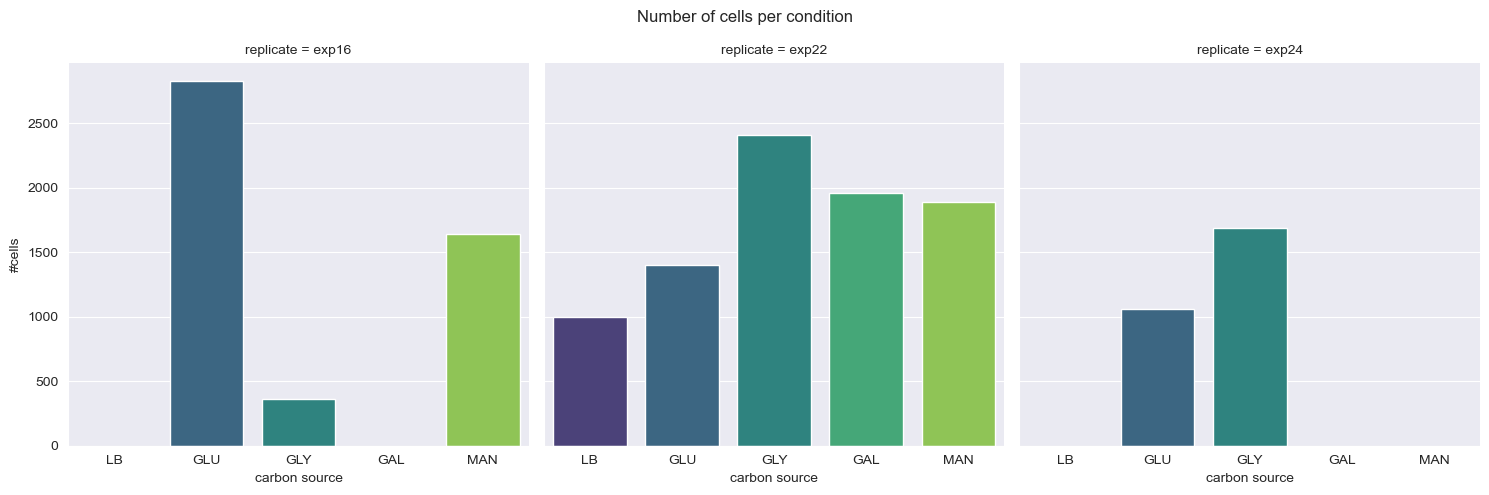

In [27]:
g = sns.catplot(pd.DataFrame(df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', estimator='sum', x='csource', order=csources_ordered, y='unique_cell_id', hue='csource', palette=palette_csource)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of cells per condition')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nr_of_cells_vs_condition"
plt.savefig(savestem + ".pdf")


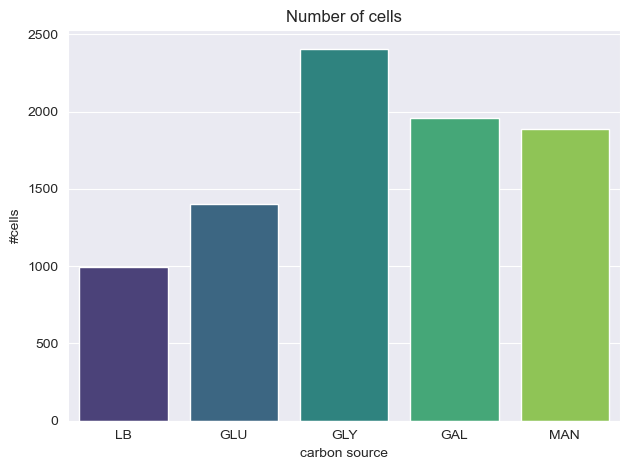

In [28]:
data = df_records.query('replicate == "exp22"')
sns.barplot(pd.DataFrame(data.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            estimator='sum', x='csource', order=csources_ordered, y='unique_cell_id', hue='csource', palette=palette_csource)
plt.xlabel('carbon source')
plt.ylabel('#cells')
plt.title('Number of cells')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nr_of_cells_vs_condition"
plt.savefig(savestem + ".pdf")


### Number of cells per csource per image

In [29]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['unique_cell_id'].agg('count')

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03       1030
                            04        407
                            07        312
                            08        206
        GLU      exp16      02        825
                            03        593
                            04        514
                            05        893
                 exp22      01        143
                            02         99
                            04        148
                            05        128
                            06        171
                            07         98
                            08        110
                            09        318
                            10        184
                 exp24      01        431
                            03        307
                            05        322
        GLY      exp16      01         16
                            03         19
                            06        145


### Number of spots per csource

In [30]:
df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg(['sum'])


sum
strain csource replicate mrna       
MG1655 GAL     exp22     hipBA  1154
                         rnlAB   725
                         rpoD   1036
       GLU     exp16     hipBA  1033
                         rnlAB  2111
                         rpoD   6853
               exp22     hipBA   964
                         rnlAB   941
                         rpoD   4163
               exp24     hipBA   168
                         rnlAB   122
                         rpoD   1026
       GLY     exp16     hipBA    60
                         rnlAB   104
                         rpoD    362
               exp22     hipBA  1667
                         rnlAB  1292
                         rpoD   2538
               exp24     hipBA   511
                         rnlAB   308
                         rpoD   1153
       LB      exp22     hipBA  1571
                         rnlAB  3690
                         rpoD   6464
       MAN     exp16     hipBA   360
                         rnlAB   383
                         rpoD   1904
               exp22     hipBA   734
                         rnlAB   290
                         rpoD    628

#### QC plot

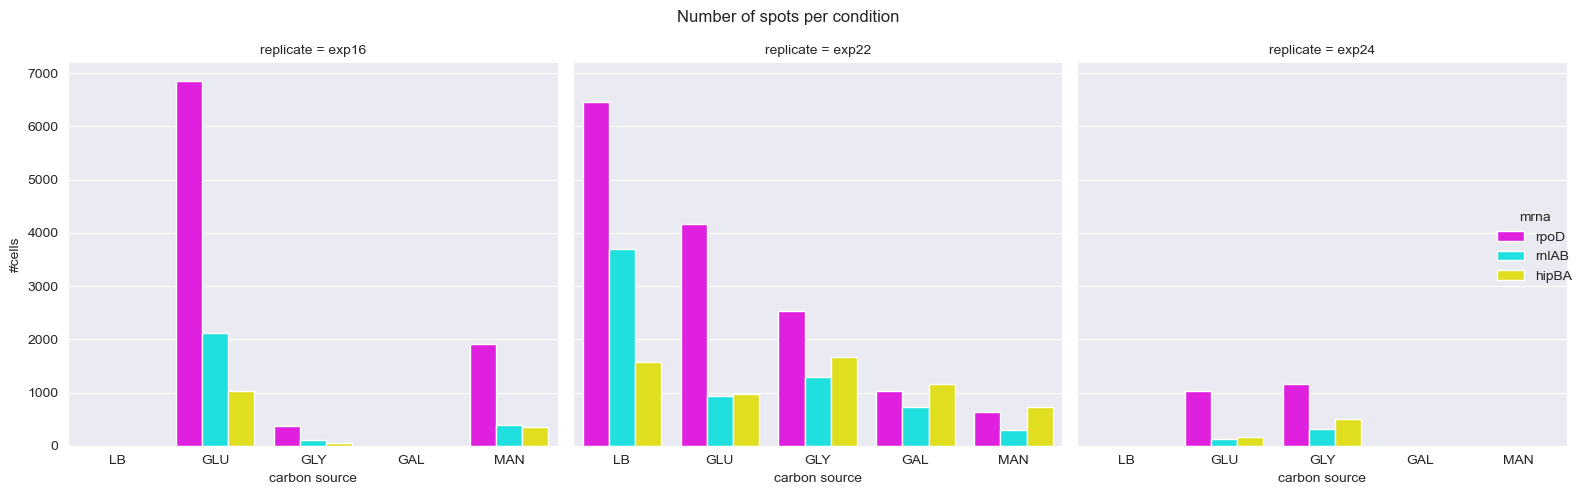

In [31]:
g = sns.catplot(pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg('sum')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of spots per condition')
plt.tight_layout();

## Plots

### Cell feature distributions

#### Explo plots area/length/volume distributions per condition

##### All, area

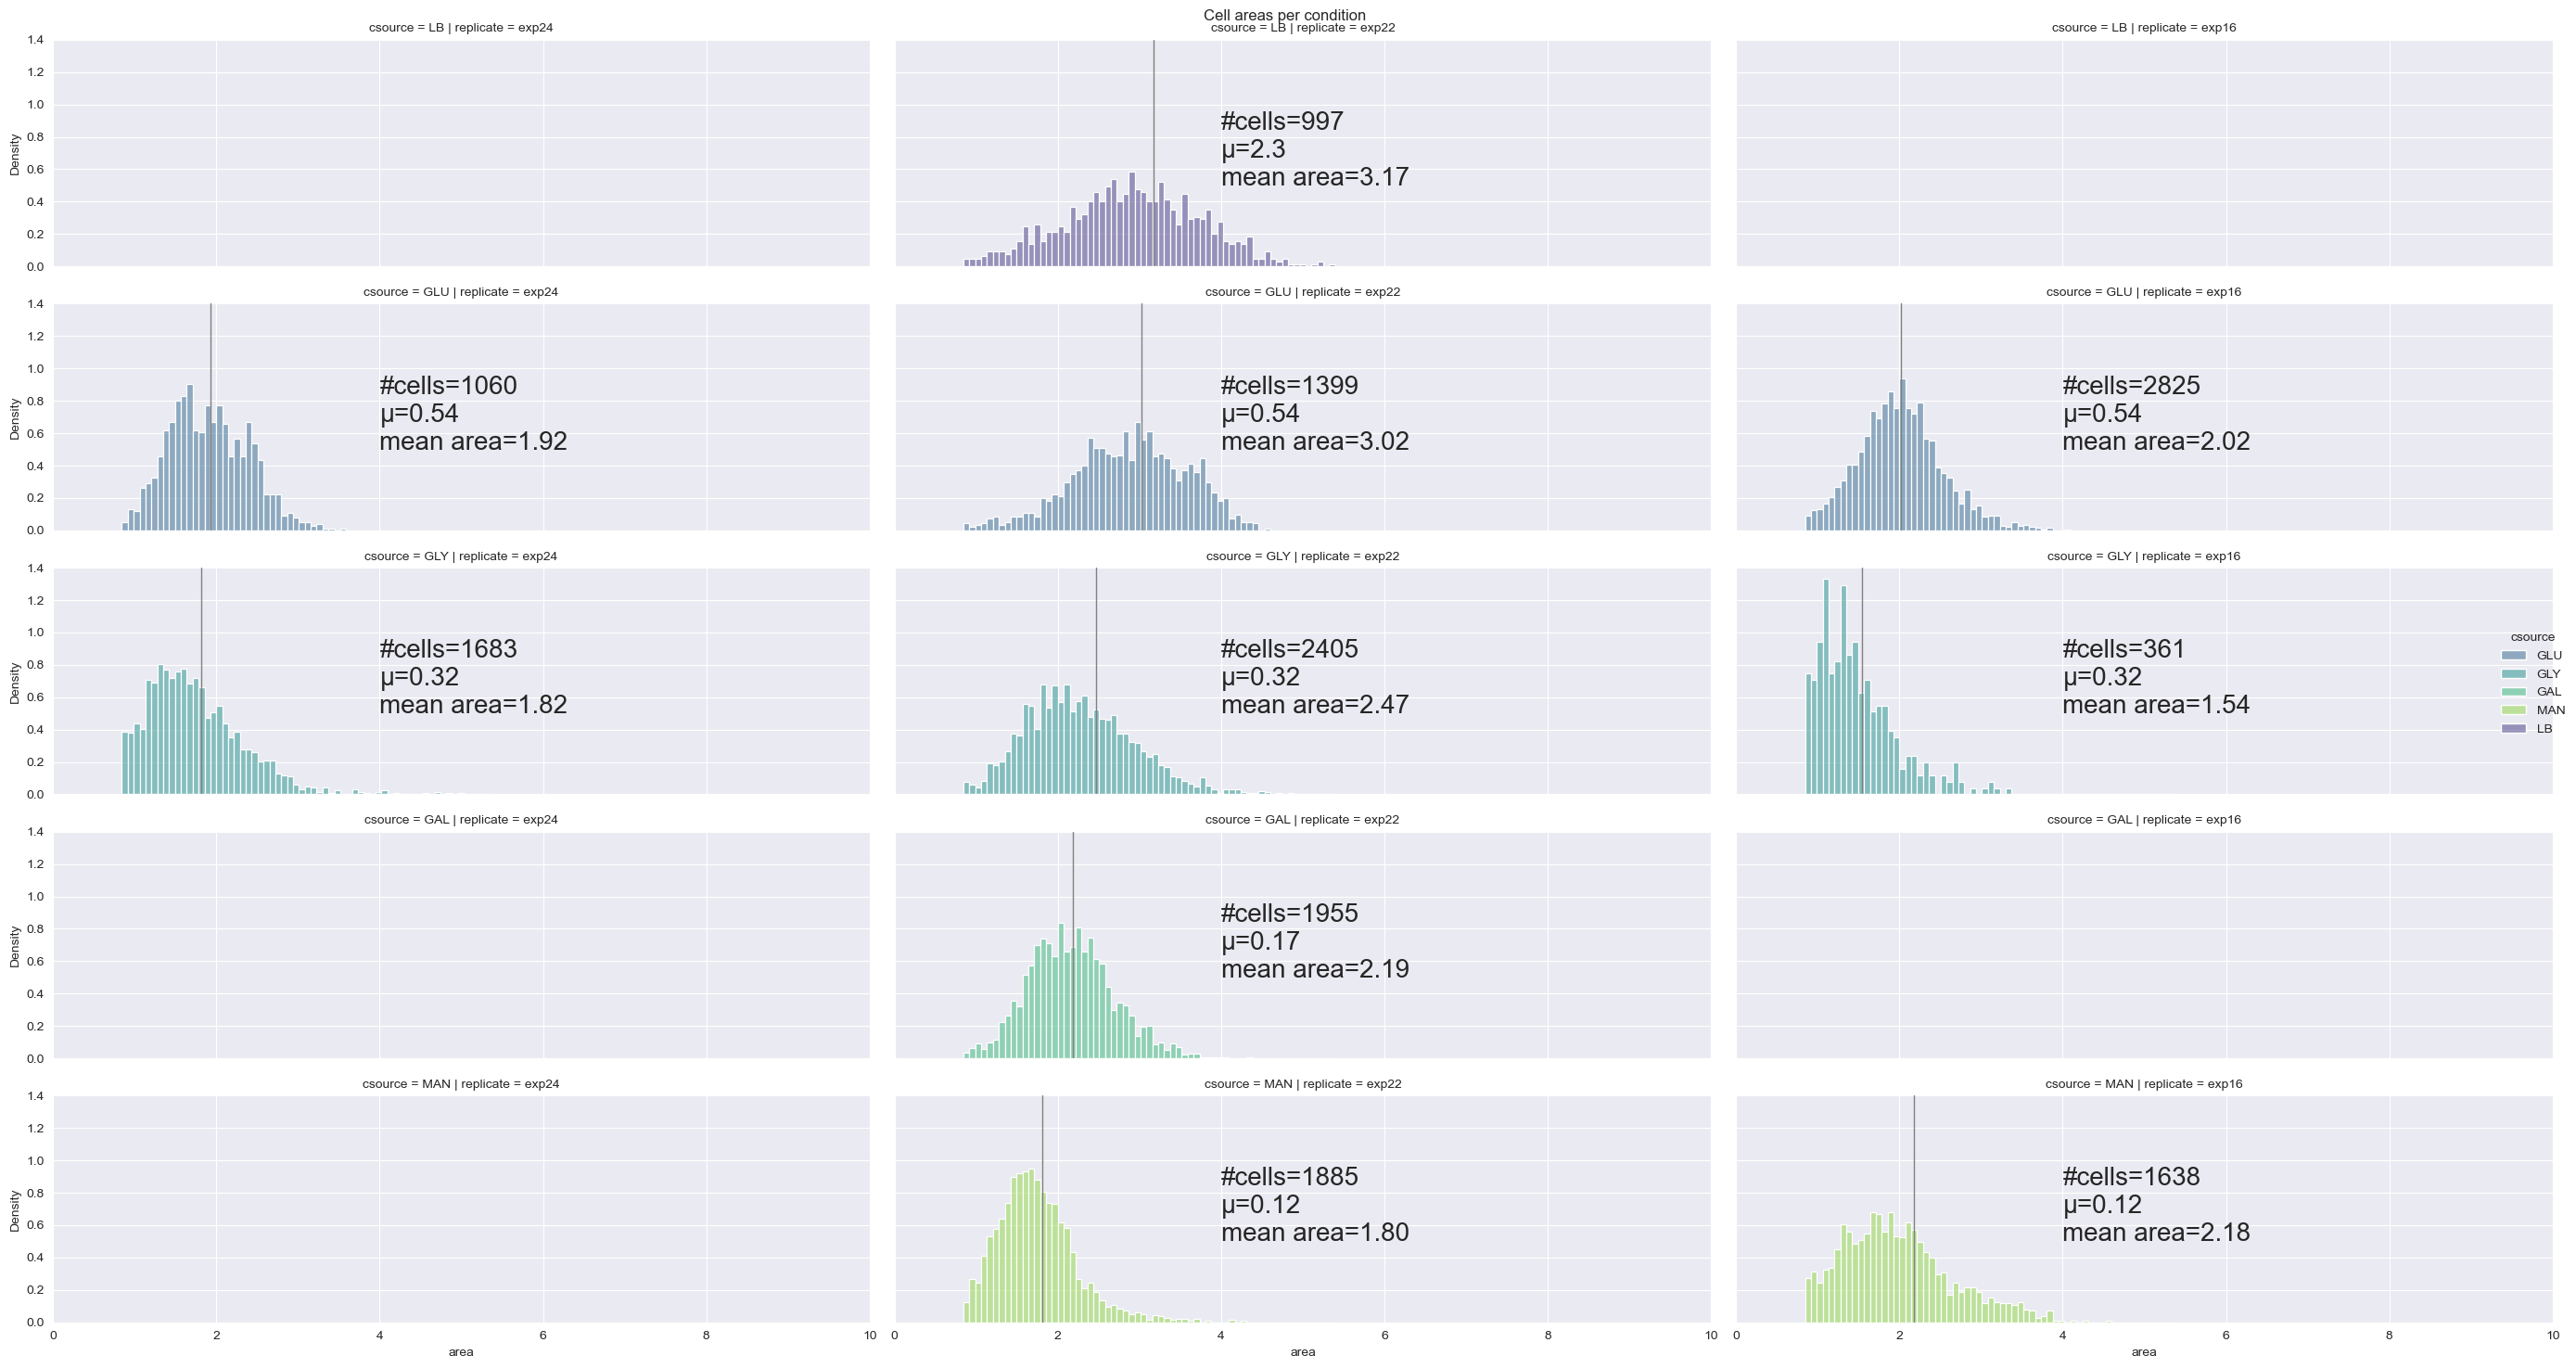

In [32]:
g = sns.displot(
    data=df_records.query('volume < 16.9'), x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates, 
    hue='csource', palette=palette_csource, 
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 10))
g.fig.suptitle('Cell areas per condition')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')
    
    data = df_records.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.2f}', xy=(4, 0.5), xytext=(4, 0.5), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

In [33]:
df_records['mu'].value_counts()

mu
0.54    5284
0.32    4449
0.12    3523
0.17    1955
2.30     997
Name: count, dtype: int64

##### All, length 

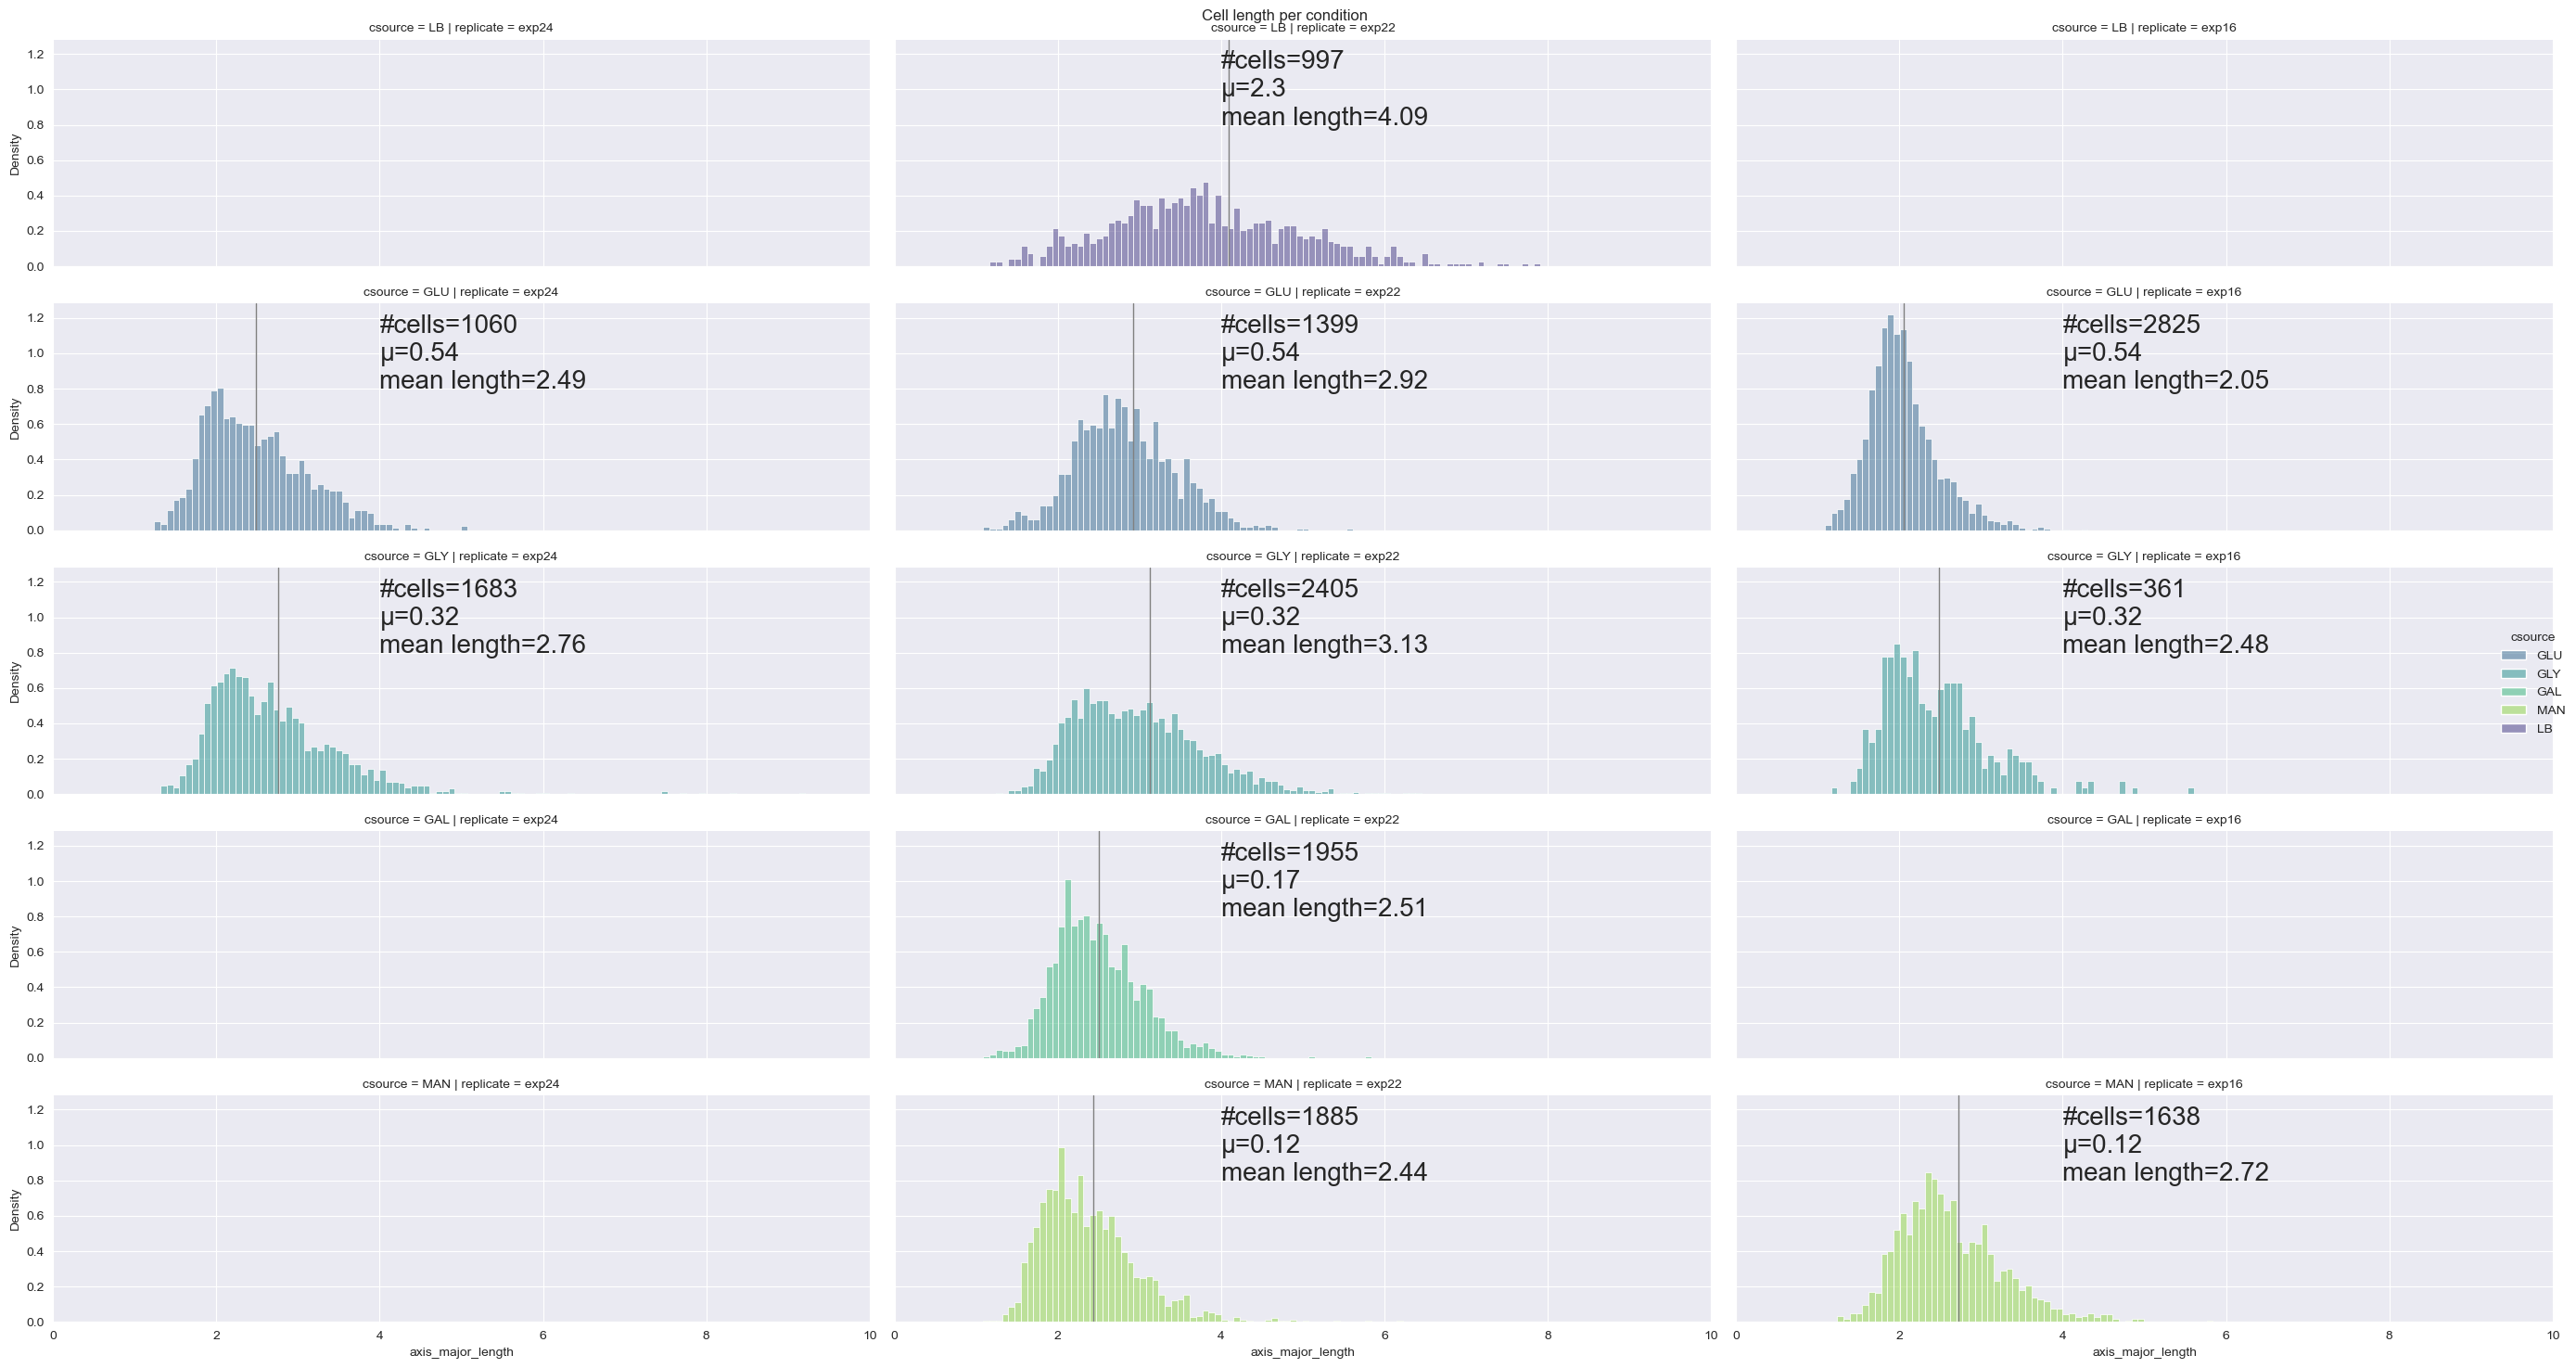

In [34]:
g = sns.displot(
    data=df_records.query('volume < 16.9'), x='axis_major_length', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates, 
    hue='csource', palette=palette_csource, 
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 10))
g.fig.suptitle('Cell length per condition')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')
    
    data = df_records.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        mean = data['axis_major_length'].mean()
        std = data['axis_major_length'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean length={mean:0.2f}', xy=(4, 0.6), xytext=(4, 0.8), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

##### All, volume

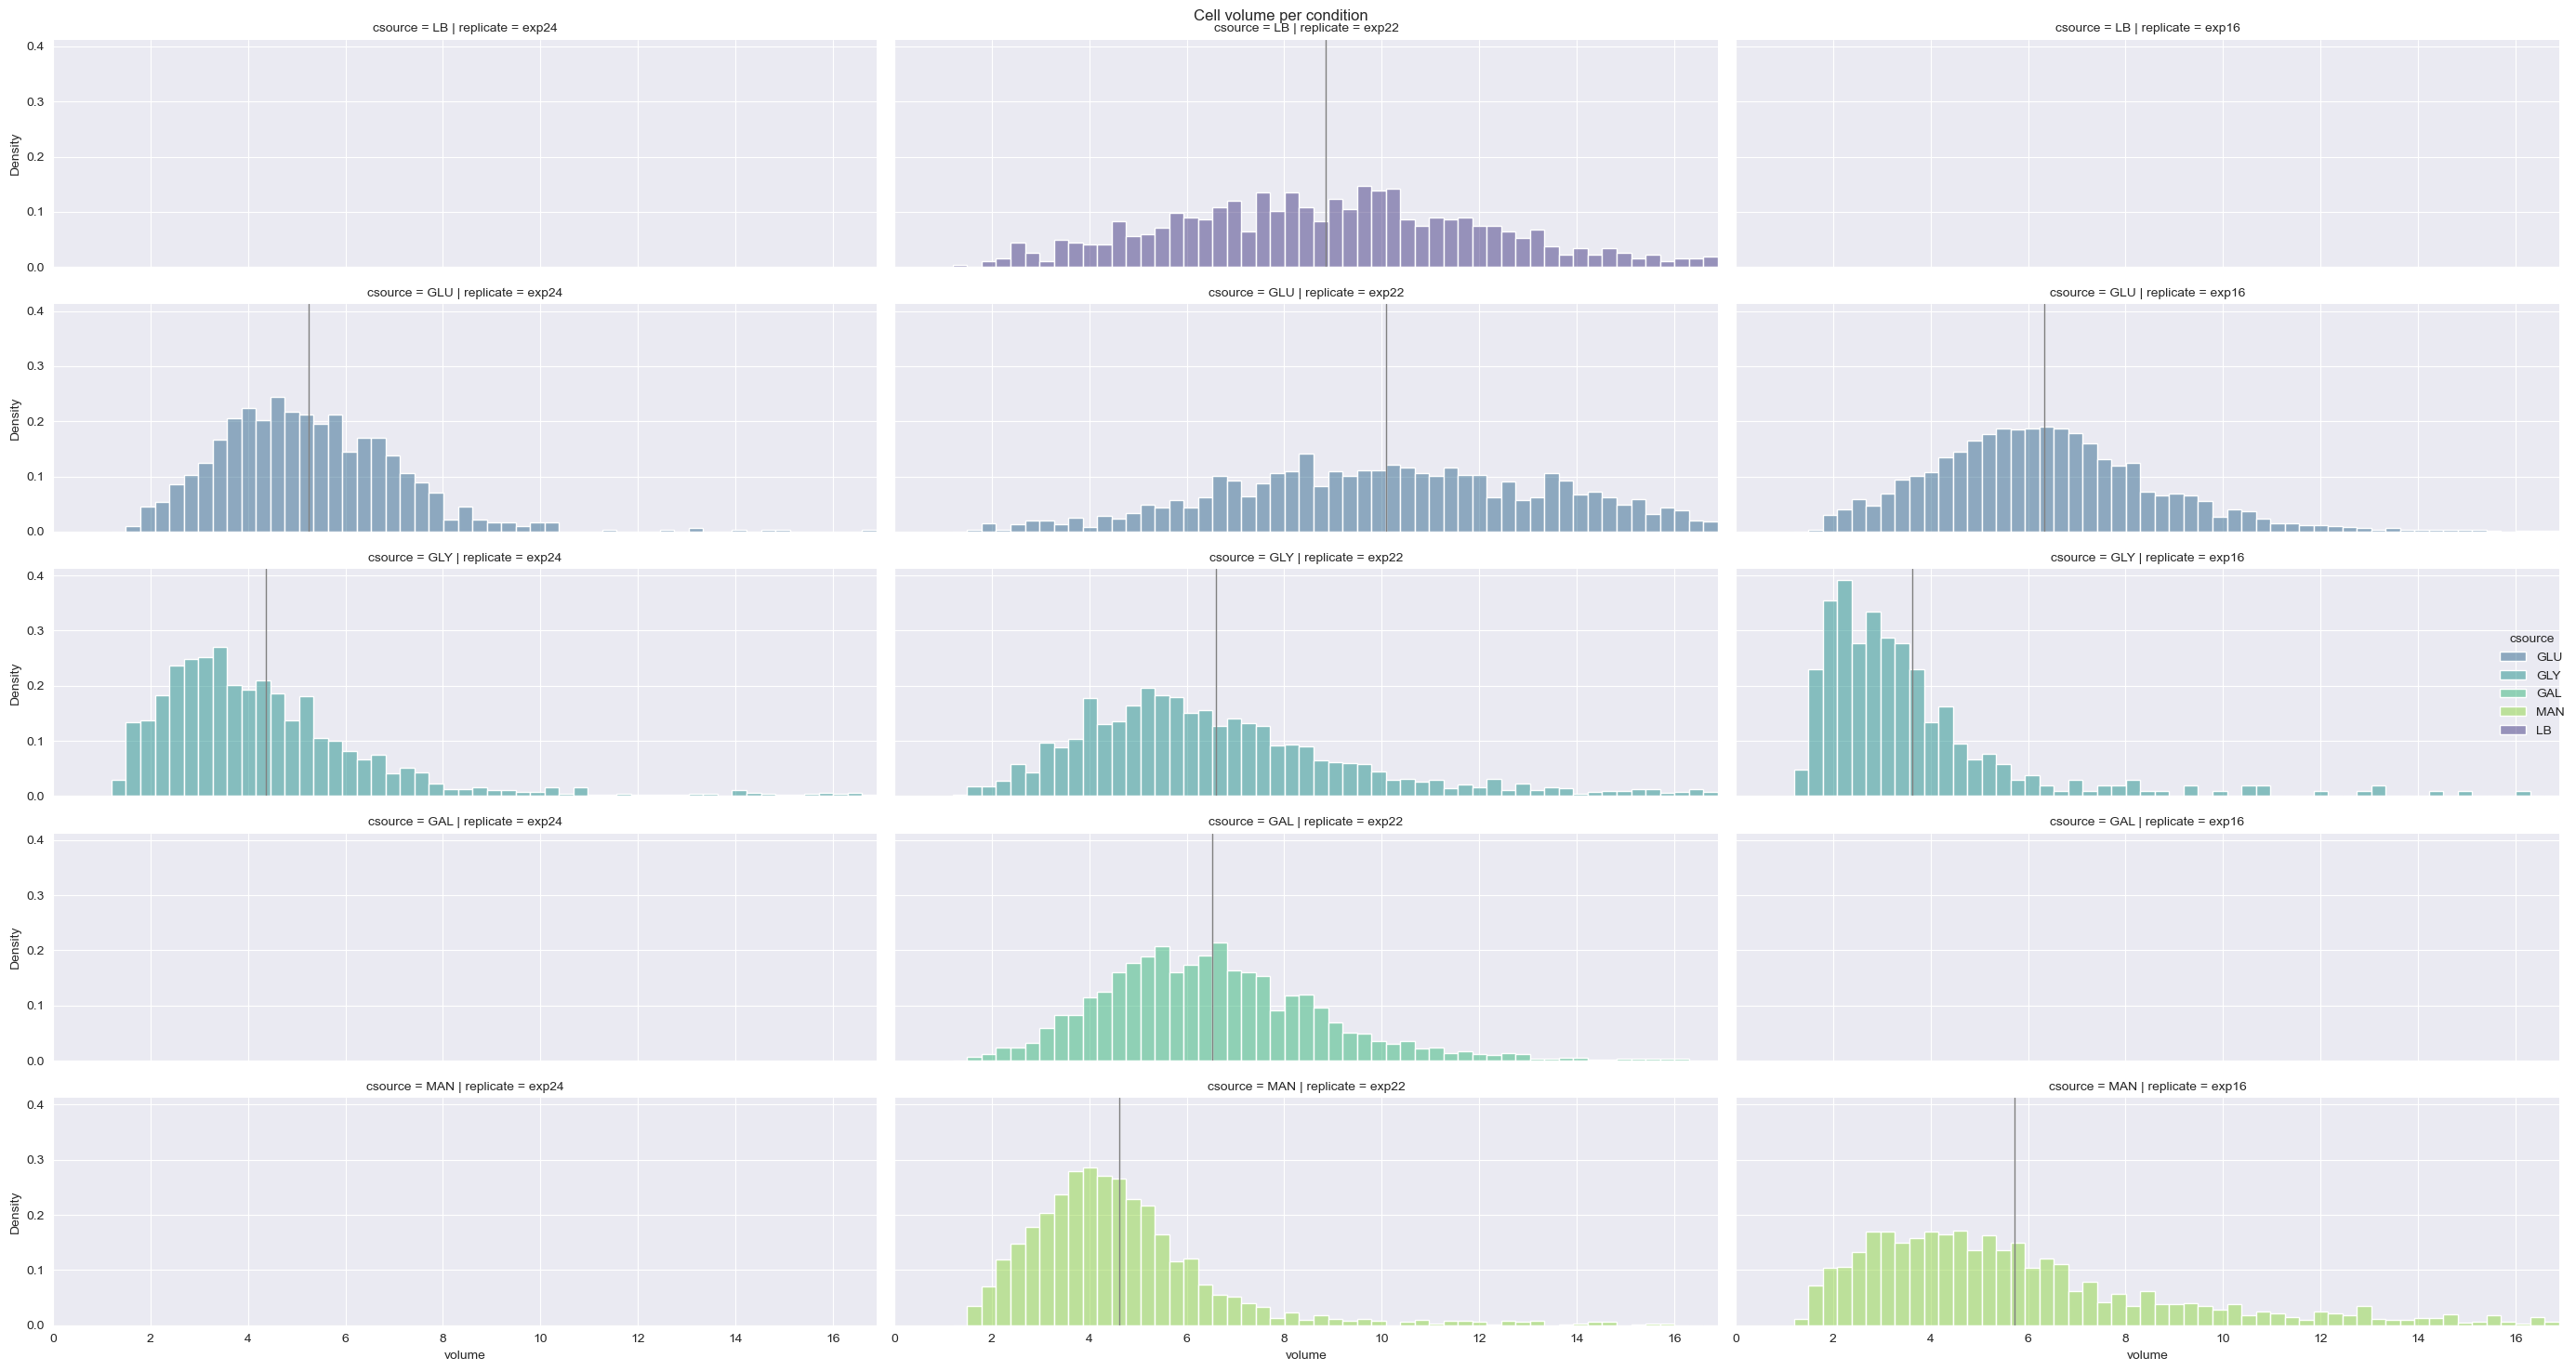

In [36]:
df_records_sane = df_records.query('volume < 16.9')
g = sns.displot(
    data=df_records_sane, x='volume', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates,
    hue='csource', palette=palette_csource,
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 16.9))
g.fig.suptitle('Cell volume per condition')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = df_records_sane.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['volume'].mean()
        std = data['volume'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean volume={mean:0.0f}', xy=(10000, 0.00015), xytext=(10000, 0.00015), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
#
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#
#     print(row, col, hue_idx, data.shape)
#
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

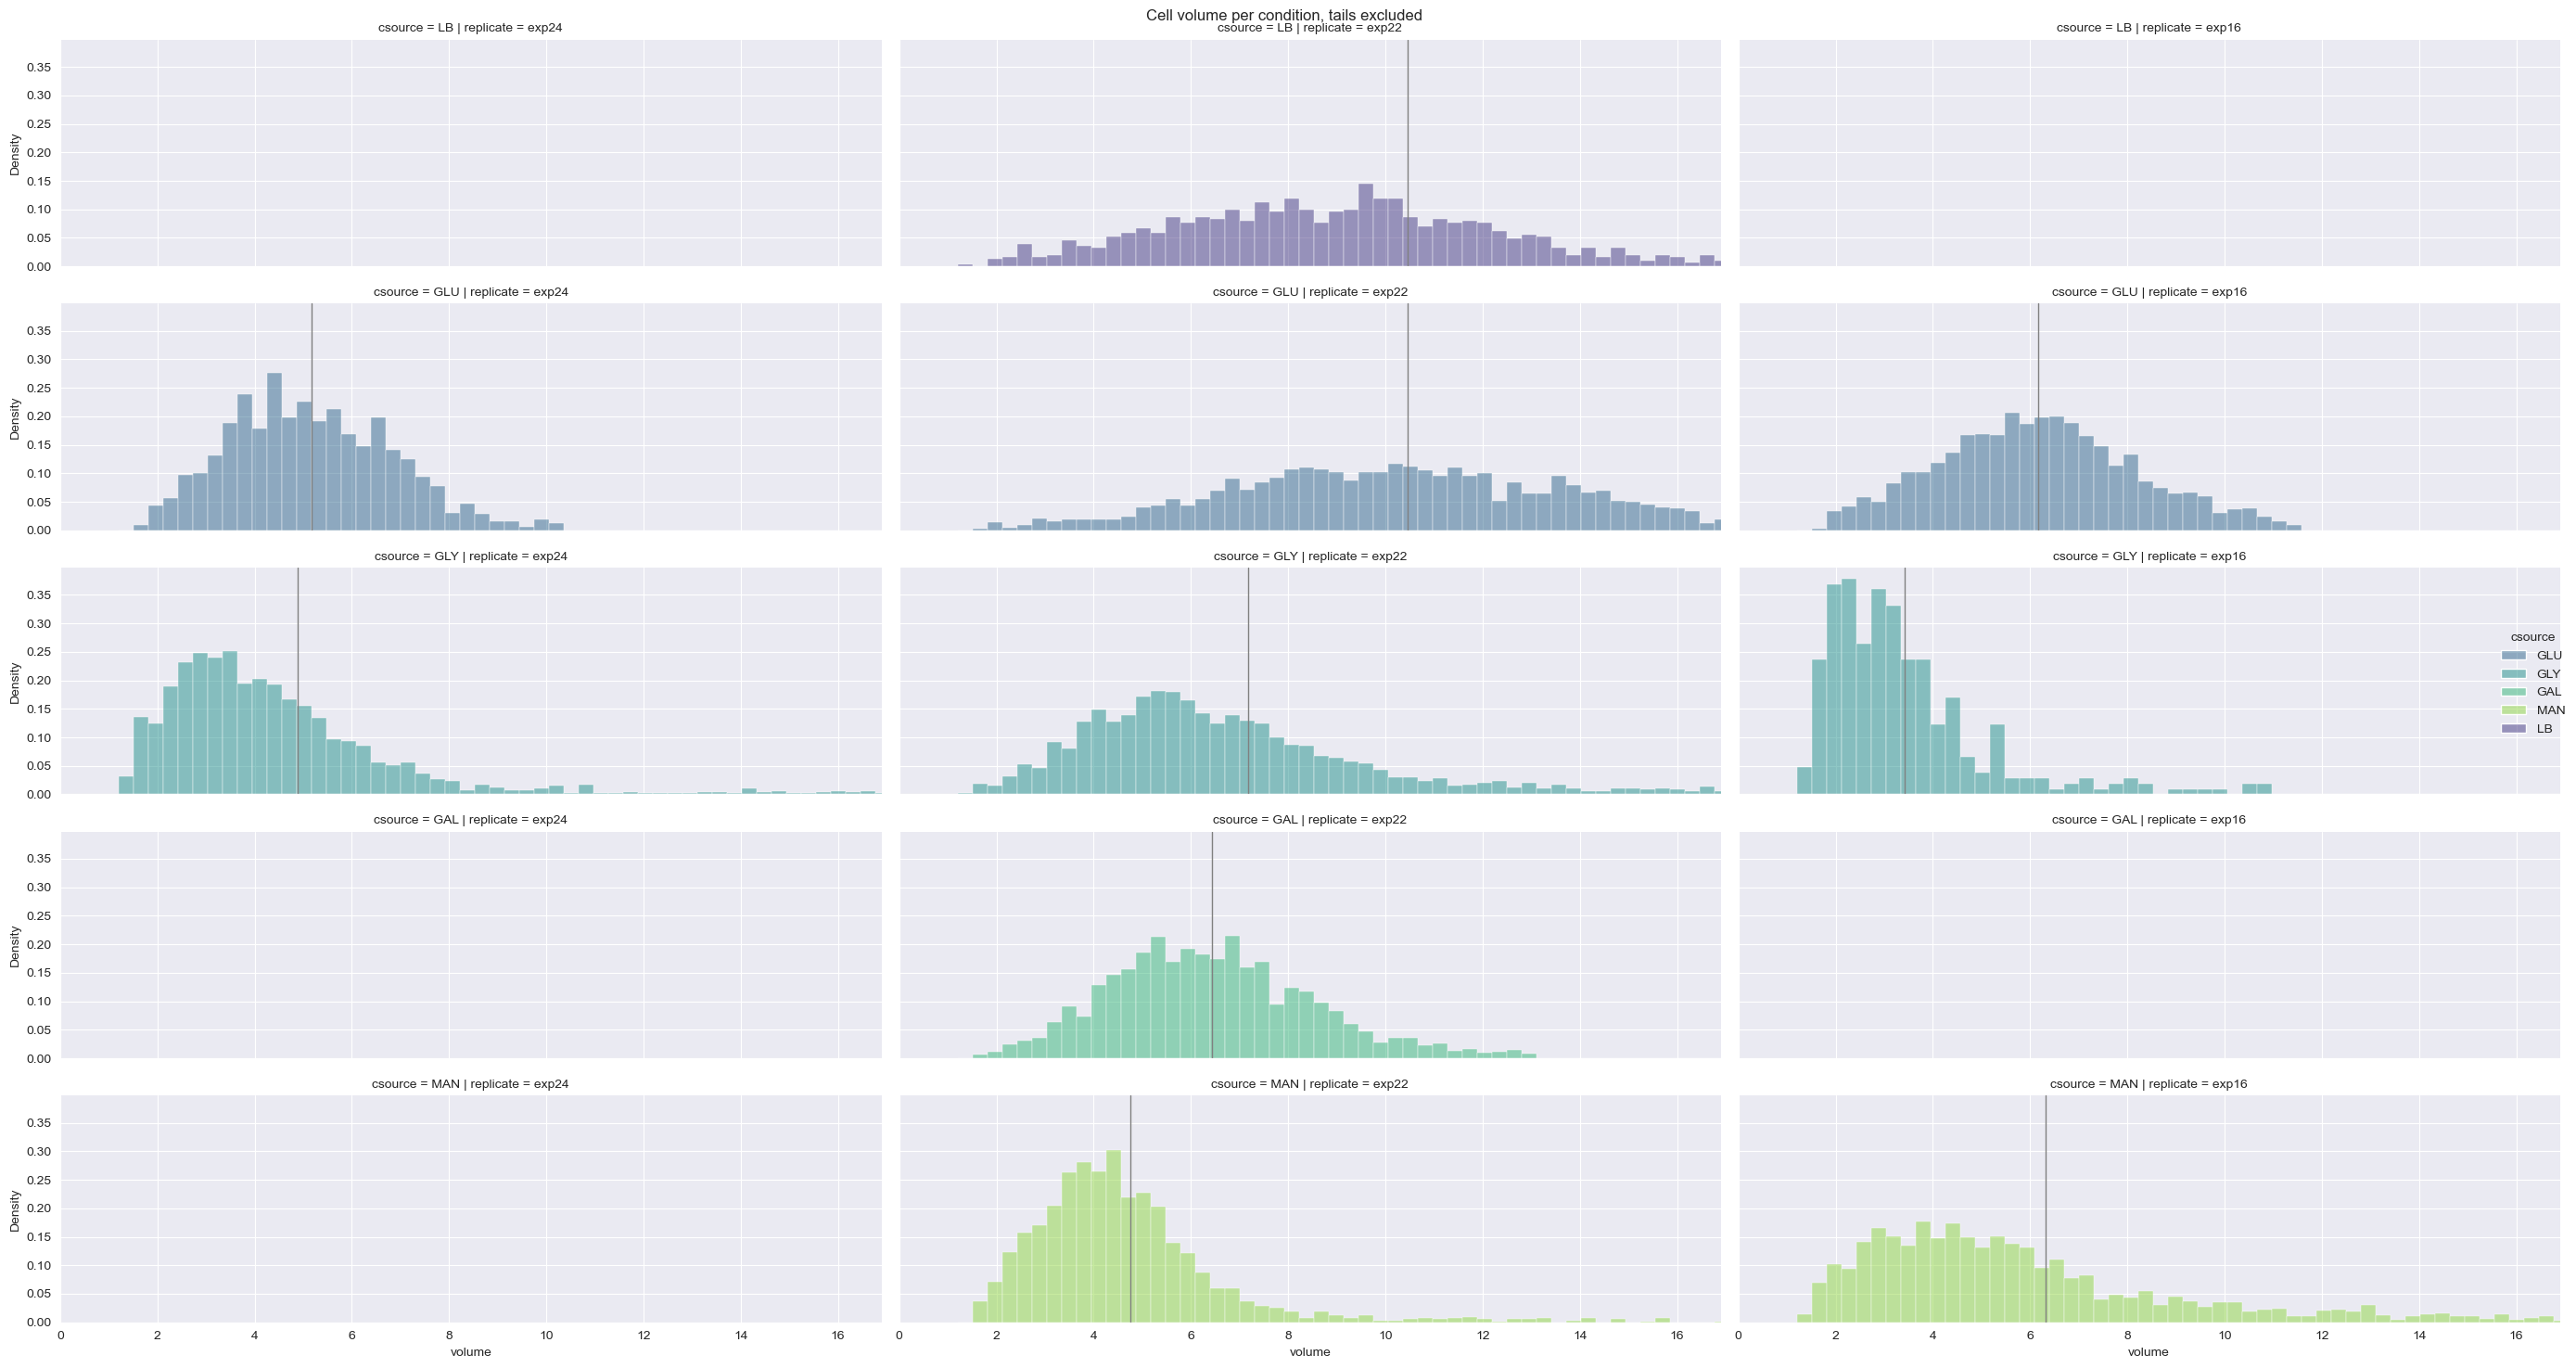

In [37]:
df_records_sane = df_records.query('volume_zscore > -2').query('volume_zscore < 2')
g = sns.displot(
    data=df_records_sane, x='volume', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates,
    hue='csource', palette=palette_csource,
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 16.9))
g.fig.suptitle('Cell volume per condition, tails excluded')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = df_records_sane.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['volume'].mean()
        std = data['volume'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean volume={mean:0.0f}', xy=(10000, 0.00015), xytext=(10000, 0.00015), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
#
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#
#     print(row, col, hue_idx, data.shape)
#
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

#### Volume per condition

##### All

In [44]:
volumes = []
for csource in csources_ordered_d:
    # removing the one outlier with volume > 1e6 which is out of whack
    data = df_records.query('volume < 17').query('csource_d == @csource')
    volumes.append({'csource': csource, 'mean_volume': data.volume.mean(), 'mu': data.mu.mean()})
df_volume = pd.DataFrame(volumes)
df_volume

csource  mean_volume    mu
0         LB         8.85  2.30
1    glucose         7.07  0.54
2   glycerol         5.49  0.32
3  galactose         6.53  0.17
4    mannose         5.12  0.12

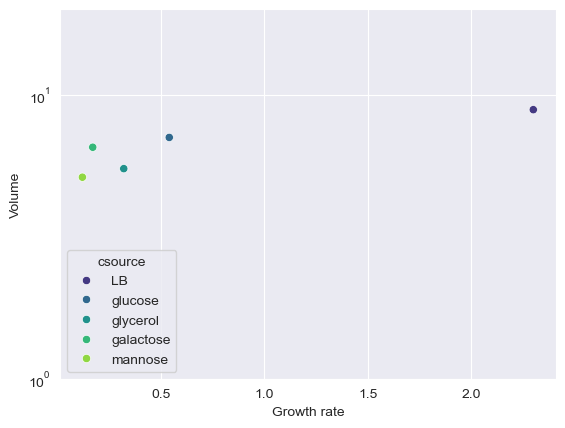

In [45]:
sns.scatterplot(df_volume, x='mu', y='mean_volume', hue='csource', palette=palette_csource_d)
plt.xlabel('Growth rate')
plt.ylim(1, 20)
plt.ylabel('Volume')
plt.yscale('log');


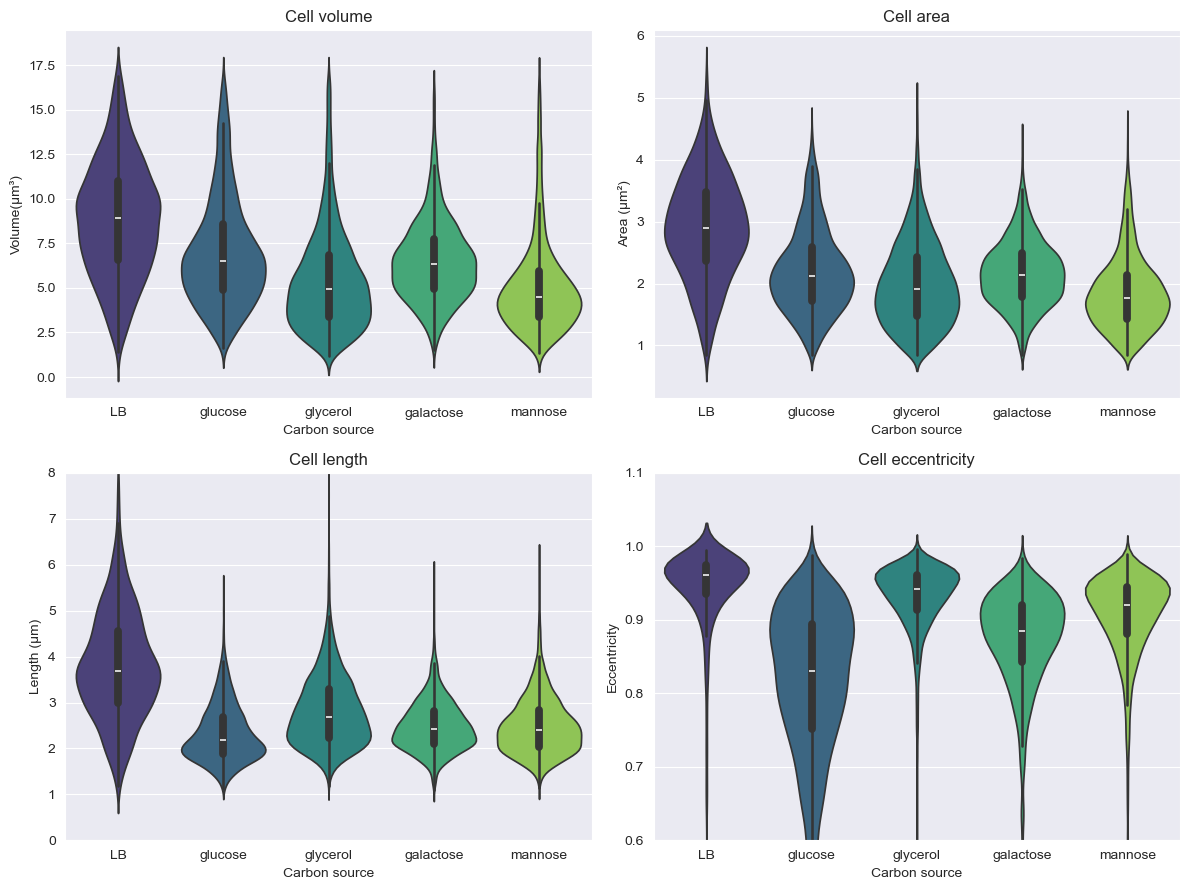

In [106]:
data = df_records.query('volume < 16.9')
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

sns.violinplot(data, x='csource_d', y='volume', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][0])
ax[0][0].set_title('Cell volume')
ax[0][0].set_xlabel('Carbon source')
ax[0][0].set_ylabel('Volume(µm³)')
# ax[0][0].set(ylim=(0, 2e4))

sns.violinplot(data, x='csource_d', y='area', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][1])
ax[0][1].set_title('Cell area')
ax[0][1].set_xlabel('Carbon source')
ax[0][1].set_ylabel('Area (µm²)')
# ax[0][1].set(ylim=(0, 1500))

sns.violinplot(data, x='csource_d', y='axis_major_length', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][0])
ax[1][0].set_title('Cell length')
ax[1][0].set_xlabel('Carbon source')
ax[1][0].set_ylabel('Length (µm)')
ax[1][0].set(ylim=(0, 8))

sns.violinplot(data, x='csource_d', y='eccentricity', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][1])
ax[1][1].set_title('Cell eccentricity')
ax[1][1].set_xlabel('Carbon source')
ax[1][1].set_ylabel('Eccentricity')
ax[1][1].set_ylim(0.6, 1.1)

plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_eccentricity_vs_condition-exp16+22+24"
plt.savefig(savestem + ".pdf")

##### exp22

In [46]:
volumes = []
for csource in csources_ordered_d:
    # removing the one outlier with volume > 1e6 which is out of whack
    data = df_records.query('volume < 17').query('replicate == "exp22"').query('csource_d == @csource')
    volumes.append({'csource': csource, 'mean_volume': data.volume.mean(), 'mu': data.mu.mean()})
df_volume = pd.DataFrame(volumes)
df_volume

csource  mean_volume    mu
0         LB         8.85  2.30
1    glucose        10.11  0.54
2   glycerol         6.61  0.32
3  galactose         6.53  0.17
4    mannose         4.63  0.12

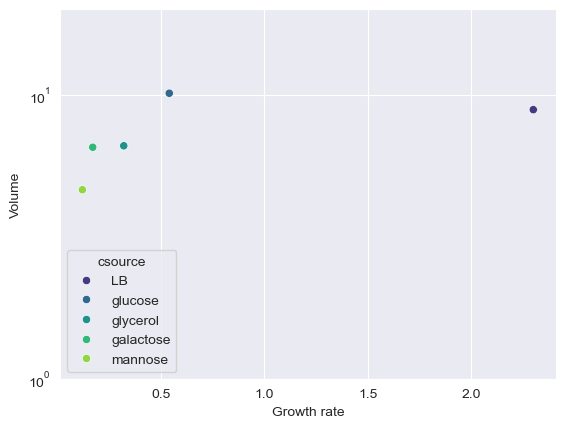

In [47]:
sns.scatterplot(df_volume, x='mu', y='mean_volume', hue='csource', palette=palette_csource_d)
plt.xlabel('Growth rate')
plt.ylim(1, 20)
plt.ylabel('Volume')
plt.yscale('log');


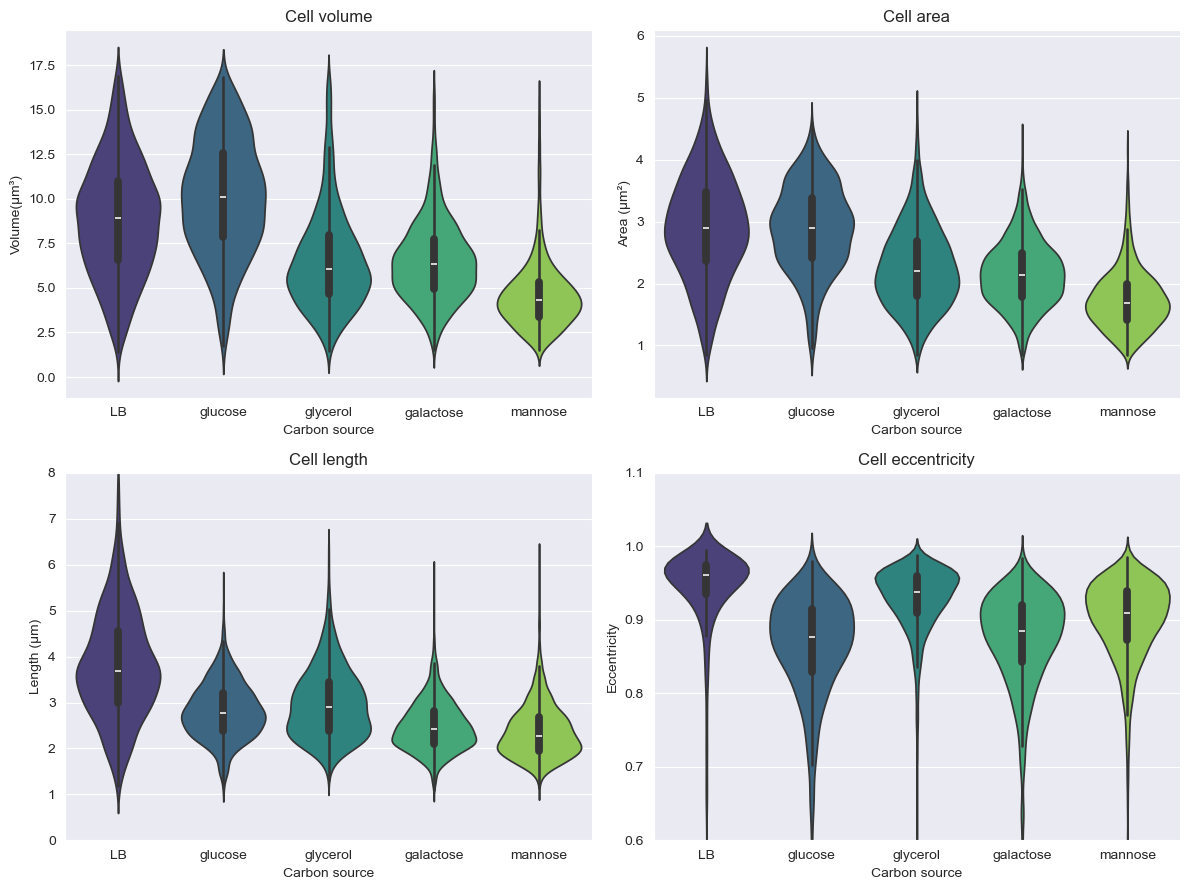

In [105]:
data = df_records.query('volume < 16.9').query('replicate == "exp22"')
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

sns.violinplot(data, x='csource_d', y='volume', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][0])
ax[0][0].set_title('Cell volume')
ax[0][0].set_xlabel('Carbon source')
ax[0][0].set_ylabel('Volume(µm³)')
# ax[0][0].set(ylim=(0, 2e4))

sns.violinplot(data, x='csource_d', y='area', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][1])
ax[0][1].set_title('Cell area')
ax[0][1].set_xlabel('Carbon source')
ax[0][1].set_ylabel('Area (µm²)')
# ax[0][1].set(ylim=(0, 1500))

sns.violinplot(data, x='csource_d', y='axis_major_length', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][0])
ax[1][0].set_title('Cell length')
ax[1][0].set_xlabel('Carbon source')
ax[1][0].set_ylabel('Length (µm)')
ax[1][0].set(ylim=(0, 8))

sns.violinplot(data, x='csource_d', y='eccentricity', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][1])
ax[1][1].set_title('Cell eccentricity')
ax[1][1].set_xlabel('Carbon source')
ax[1][1].set_ylabel('Eccentricity')
ax[1][1].set_ylim(0.6, 1.1)

plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_eccentricity_vs_condition-exp22"
plt.savefig(savestem + ".pdf")

In [50]:
data = df_records
areas = data.groupby(['strain', 'csource', 'replicate'])['area'].agg(['mean', 'median', 'std']).reset_index()
volumes = data.groupby(['strain', 'csource', 'replicate'])['volume'].agg(['mean', 'median', 'std']).reset_index()
mus = pd.DataFrame(data.groupby(['strain', 'csource', 'replicate'])['mu'].agg('mean')).reset_index()
df = areas.merge(volumes, on=['strain', 'csource', 'replicate'], suffixes=('_area', '_volume')).merge(mus, on=['strain', 'csource', 'replicate'])
df

strain csource replicate  mean_area  median_area  std_area  mean_volume  \
0  MG1655     GAL     exp22       2.19         2.15      0.59         6.75   
1  MG1655     GLU     exp16       2.02         1.99      0.54         6.40   
2  MG1655     GLU     exp22       3.02         2.97      0.96        10.86   
3  MG1655     GLU     exp24       1.92         1.88      0.53         5.35   
4  MG1655     GLY     exp16       1.54         1.39      0.61         4.05   
5  MG1655     GLY     exp22       2.47         2.28      1.04         8.62   
6  MG1655     GLY     exp24       1.82         1.67      0.90         8.85   
7  MG1655      LB     exp22       3.17         3.01      1.25        11.77   
8  MG1655     MAN     exp16       2.18         1.95      1.12         7.38   
9  MG1655     MAN     exp22       1.80         1.69      0.75         5.25   

   median_volume  std_volume    mu  
0           6.34        3.20  0.17  
1           6.18        2.51  0.54  
2          10.42        4.91  0.54  
3           5.07        2.46  0.54  
4           3.07        3.67  0.32  
5           6.33        9.58  0.32  
6           3.94      162.61  0.32  
7           9.36       23.22  2.30  
8           5.21        9.93  0.12  
9           4.34        9.10  0.12

In [51]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['area'].mean()

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03       2.22
                            04       2.14
                            07       2.15
                            08       2.17
        GLU      exp16      02       1.77
                            03       2.01
                            04       2.13
                            05       2.20
                 exp22      01       2.90
                            02       2.91
                            04       2.40
                            05       2.91
                            06       3.01
                            07       3.00
                            08       3.25
                            09       3.31
                            10       3.13
                 exp24      01       1.86
                            03       2.00
                            05       1.94
        GLY      exp16      01       2.05
                            03       1.80
                            06       1.60


### Inspect suspicious area values
-> to improve segmentation later

In [52]:
df_records.query('replicate == "exp16"').query('csource == "MAN"').sort_values(by='area', ascending=False)[['experiment', 'image', 'image_cell_id', 'area', 'volume', 'bbox-1', 'bbox-2']]

experiment                      image  image_cell_id   area  volume  \
131  20240927-exp16  MG1655_MAN_OD_0.3_left_02            414  17.19  259.68   
210  20240927-exp16  MG1655_MAN_OD_0.3_left_02            642  11.37   92.05   
240  20240927-exp16  MG1655_MAN_OD_0.3_left_02            699   9.62   67.53   
307  20240927-exp16  MG1655_MAN_OD_0.3_left_02            905   8.84   71.06   
52   20240927-exp16  MG1655_MAN_OD_0.3_left_05            536   8.70   67.85   
..              ...                        ...            ...    ...     ...   
98   20240927-exp16  MG1655_MAN_OD_0.3_left_09            565   0.86    1.79   
69   20240927-exp16  MG1655_MAN_OD_0.3_left_07            514   0.86    1.73   
241  20240927-exp16  MG1655_MAN_OD_0.3_left_09            899   0.85    1.37   
353  20240927-exp16  MG1655_MAN_OD_0.3_left_09           1165   0.85    1.50   
299  20240927-exp16  MG1655_MAN_OD_0.3_left_09           1040   0.85    1.34   

     bbox-1  bbox-2  
131    1763    1074  
210     618    1585  
240    2220    1674  
307    1976    2191  
52      813     483  
..      ...     ...  
98     1687     364  
69      584     497  
241     562     904  
353    1175    1305  
299     188    1115  

[1638 rows x 7 columns]

In [53]:
df_records.groupby(['strain', 'csource', 'replicate'])['area'].mean()

strain  csource  replicate
MG1655  GAL      exp22        2.19
        GLU      exp16        2.02
                 exp22        3.02
                 exp24        1.92
        GLY      exp16        1.54
                 exp22        2.47
                 exp24        1.82
        LB       exp22        3.17
        MAN      exp16        2.18
                 exp22        1.80
Name: area, dtype: float64

In [55]:
df_records.groupby(['strain', 'csource'])['area'].mean()

strain  csource
MG1655  GAL        2.19
        GLU        2.27
        GLY        2.15
        LB         3.17
        MAN        1.98
Name: area, dtype: float64

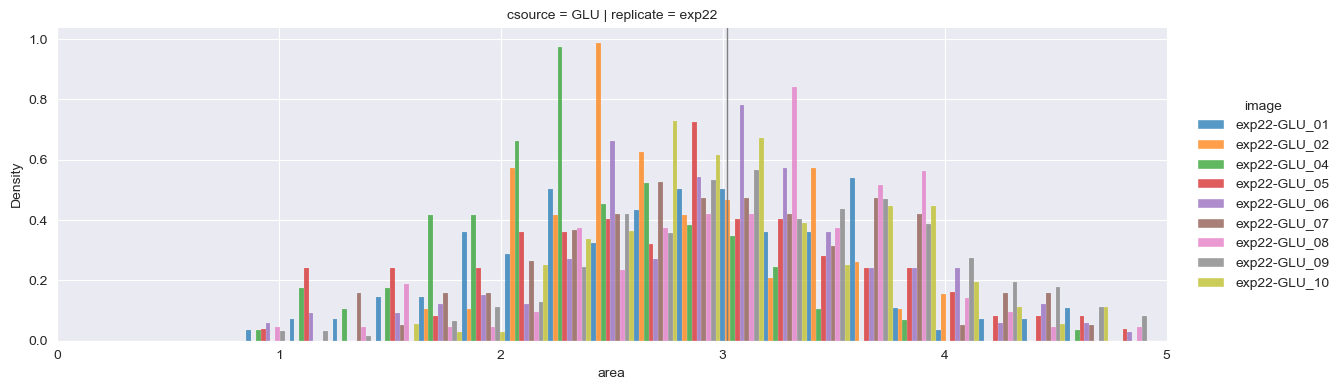

In [59]:
thisdata =  df_records.query("csource in ['GLU']").query("replicate == 'exp22'").query("area < 2500")

g = sns.displot(
    data=thisdata, x='area', stat='density', common_norm=False,
    row='csource', col='replicate',
    hue='image', multiple="dodge",
    legend=True, height=4, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 5))

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = thisdata.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1200, 0.0022), xytext=(1200, 0.0022))

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
#
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#
#     print(row, col, hue_idx, data.shape)
#
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

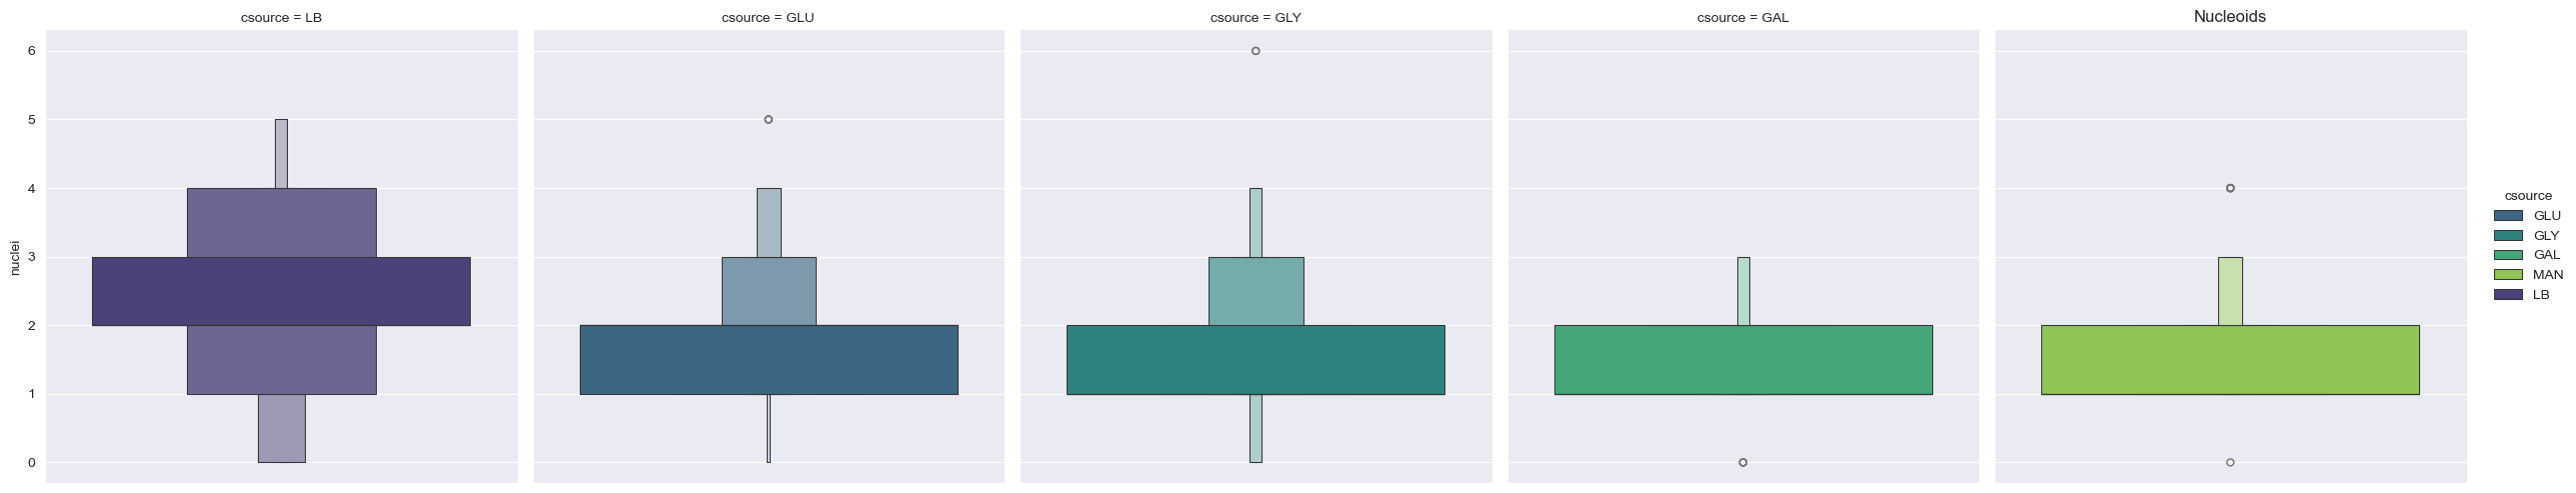

In [66]:
sns.catplot(data, kind='boxen', y='nuclei', col='csource', col_order=csources_ordered, hue='csource', palette=palette_csource)
plt.title('Nucleoids')
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nuclei"
plt.savefig(savestem + ".pdf")

#### Area per condition

##### Demo plot

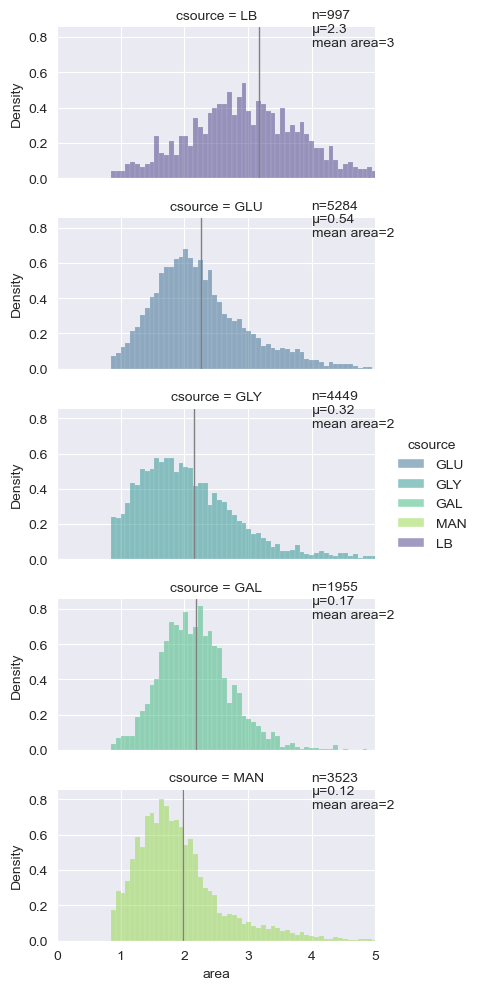

In [73]:
data = df_records
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 5))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(4, 0.75), xytext=(4, 0.75))

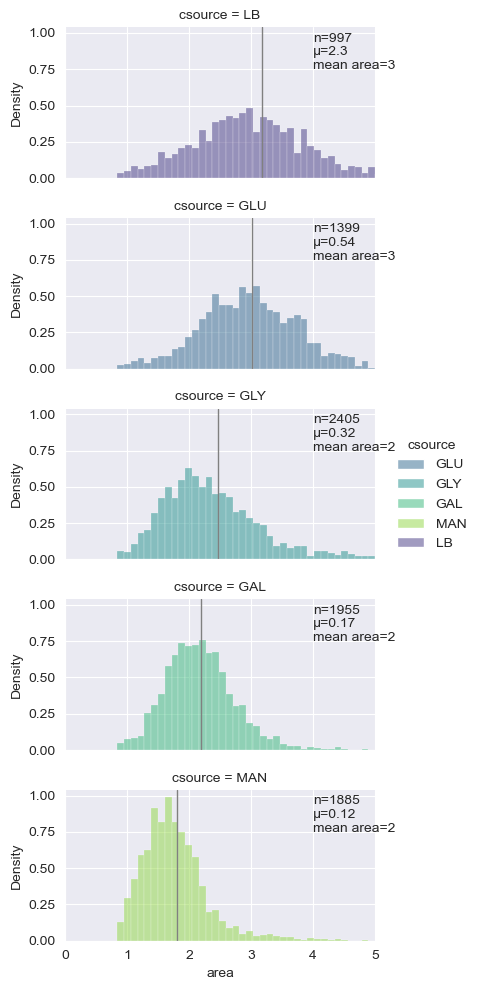

In [72]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 5))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(4, 0.77), xytext=(4, 0.75))

#### Eccentricity per condition

##### Demo plot

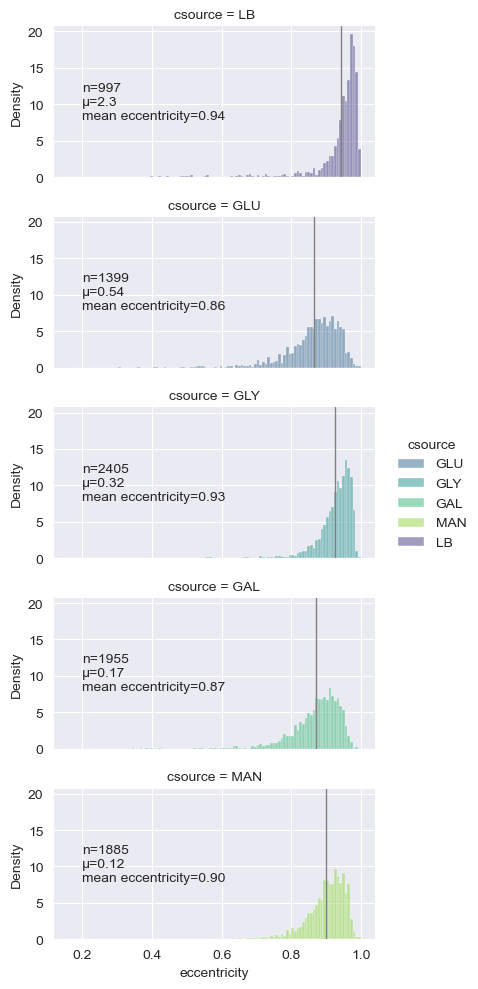

In [74]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='eccentricity', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))

axes = g.axes.flatten()
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]

    mean = data.query('csource == @csource')['eccentricity'].mean()
    std = data.query('csource == @csource')['eccentricity'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean eccentricity={mean:0.2f}', xy=(0.2, 8), xytext=(0.2, 8))

### Expression versus growth rate

#### Mean expression per condition


##### All

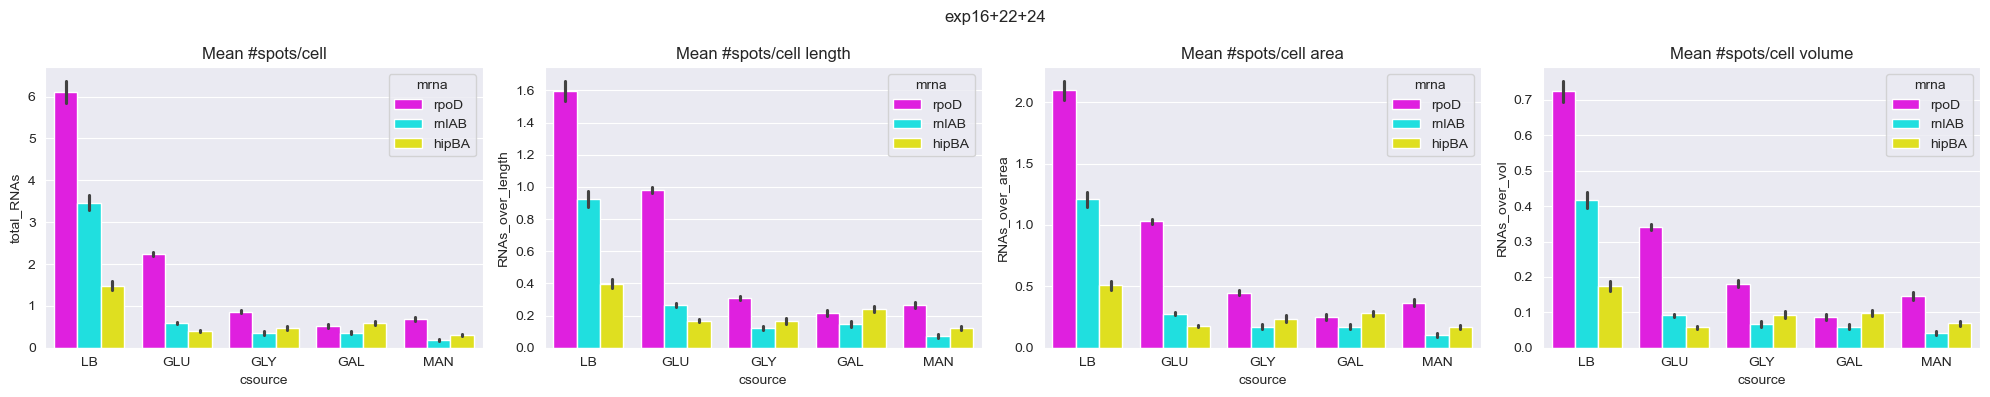

In [75]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp16+22+24")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


##### exp22

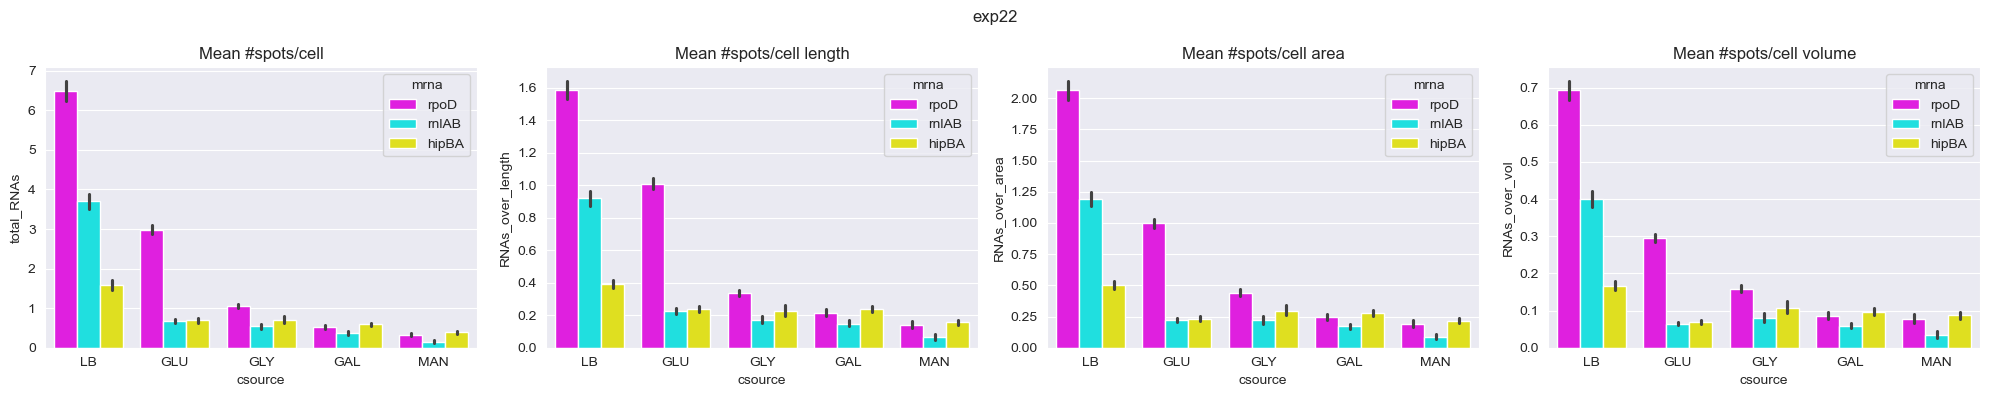

In [905]:
sns.set_style("darkgrid")
data=df_stacked.query("replicate == 'exp22'")

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


#### Normalization


##### Genome copy number depends on growth rate


In [76]:
# at generation times > 60 minutes, we only have one copy of the genome
# in LB, tau = 20 minutes, so we should something between 4 and 8 DNA copies
# it depends on C period (OK) and D period (which I don't know how to compute)
# I used the values from the Bremer article
Gc = { 'LB': 4.0, 'GLU': 1.8, 'GLY': 1, 'GAL': 1, 'MAN': 1}
df_stacked['DNA_copy_number'] = df_stacked['csource'].apply(lambda x: Gc[x])
df_stacked['DNA_copy_number'].value_counts()


DNA_copy_number
1.0    29781
1.8    15852
4.0     2991
Name: count, dtype: int64

In [78]:
df_stacked['mu'].unique(), df_stacked['tau (h)'].unique(), df_stacked['tau (min)'].unique()

(array([0.54, 0.32, 0.17, 0.12, 2.3 ]),
 array([1.28360589, 2.16608494, 4.07733636, 5.7762265 , 0.30136834]),
 array([ 77.0163534 , 129.96509635, 244.64018137, 346.57359028,
         18.08210036]))

In [79]:
df_stacked['total_RNAs_normalized1'] = df_stacked['total_RNAs'] / df_stacked['DNA_copy_number']
df_stacked['RNAs_over_length_normalized1'] = df_stacked['RNAs_over_length'] / df_stacked['DNA_copy_number']
df_stacked['RNAs_over_area_normalized1'] = df_stacked['RNAs_over_area'] / df_stacked['DNA_copy_number']
df_stacked['RNAs_over_vol_normalized1'] = df_stacked['RNAs_over_vol'] / df_stacked['DNA_copy_number']

##### Gene copy number depends on growth rate and distance of gene from oriC

In [86]:
gene_map_locations = { 'rpoD': 69.21, 'rnlAB': 59.59, 'hipBA': 34.3}
# just manually checking that it makes sense: rpoD is closest from oriC, then rnlAB, then hipBA
# hipBA is right opposite oriC, so mprime is max (value of 1)
# mprime = 0 => max expression (from start of replication because distance is minimal)
# mprime = 1 => min expression
# mprime = { 'rpoD': 0.3, 'rnlAB': 0.48, 'hipBA': 1}
C = { 'LB': 33, 'GLU': 62 }
D = { 'LB': 22, 'GLU': 28 }


def number_of_gene_per_cell(csource, mrna, tau):
    if csource == 'GLY' or csource == 'GAL' or csource == 'MAN':
        return 1

    elif csource == 'LB' or csource == 'GLU':
        # oriC_loc = 84.57
        m = gene_map_locations[mrna]
        if m <= 36:
            # hipBA
            mprime = (m + 16) / 50
        elif m <= 84:
            # rpoD and rnlAB
            mprime = (84 - m) / 50
        else:
            mprime = (m - 84) / 50

        exponent = (C[csource] * (1 - mprime) + D[csource]) / tau
        Xc = pow(2, exponent)
        return Xc


df_stacked['gene_copy_number'] = df_stacked.apply(lambda r: number_of_gene_per_cell(r['csource'], r['mrna'], r['tau (min)']), axis=1)
df_stacked[['csource', 'mrna', 'gene_copy_number']].value_counts()

csource  mrna   gene_copy_number
GLU      hipBA  1.28                5284
         rnlAB  1.71                5284
         rpoD   1.91                5284
GLY      hipBA  1.00                4449
         rnlAB  1.00                4449
         rpoD   1.00                4449
MAN      hipBA  1.00                3523
         rnlAB  1.00                3523
         rpoD   1.00                3523
GAL      hipBA  1.00                1955
         rnlAB  1.00                1955
         rpoD   1.00                1955
LB       hipBA  2.31                 997
         rnlAB  4.44                 997
         rpoD   5.66                 997
Name: count, dtype: int64

In [87]:
df_stacked['total_RNAs_normalized2'] = df_stacked['total_RNAs_normalized1']  / df_stacked['gene_copy_number']
df_stacked['RNAs_over_length_normalized2'] = df_stacked['RNAs_over_length_normalized1'] / df_stacked['gene_copy_number']
df_stacked['RNAs_over_area_normalized2'] = df_stacked['RNAs_over_area_normalized1'] / df_stacked['gene_copy_number']
df_stacked['RNAs_over_vol_normalized2'] = df_stacked['RNAs_over_vol_normalized1'] / df_stacked['gene_copy_number']

In [88]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'csource',
       'coverslip', 'replicate', 'unique_cell_id', 'selected', 'volume',
       'volume_ellipsoid', 'RNAs_over_area', 'RNAs_over_vol',
       'RNAs_over_length', 'RNAs_over_eccentricity', 'mu', 'tau (h)',
       'tau (min)', 'csource_d', 'DNA_copy_number', 'total_RNAs_normalized1',
       'RNAs_over_length_normalized1', 'RNAs_over_area_normalized1',
       'RNAs

##### All

###### Unnormalized

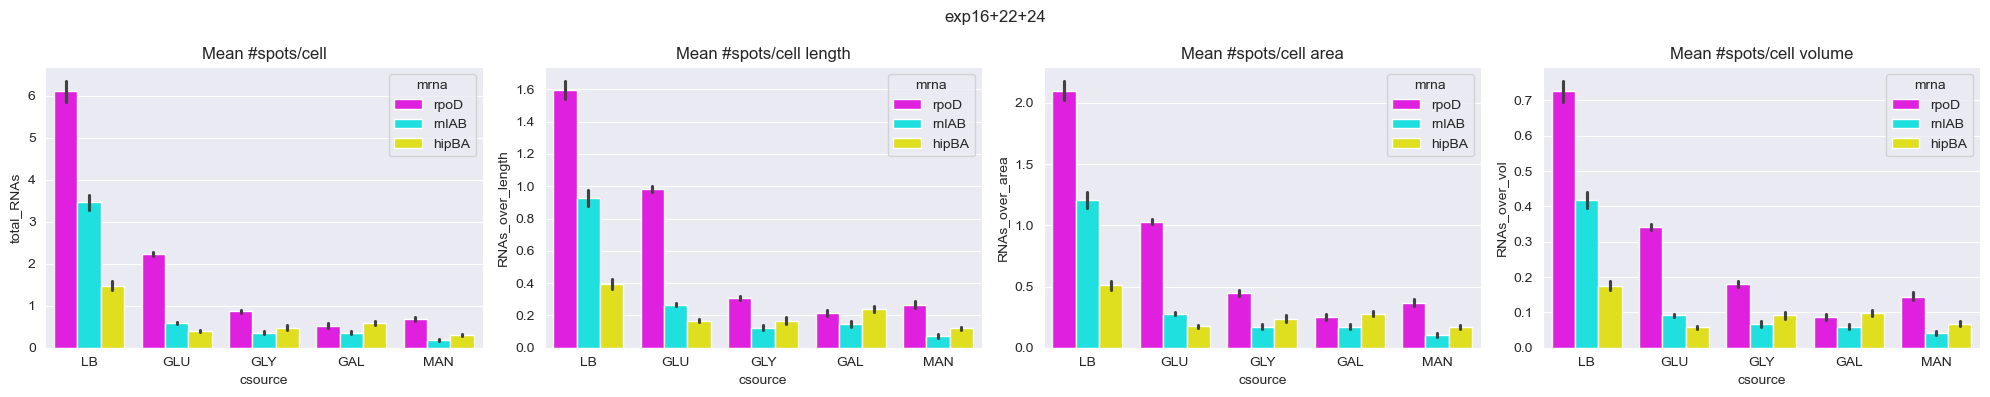

In [92]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp16+22+24")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


###### Normalized by genome copy number

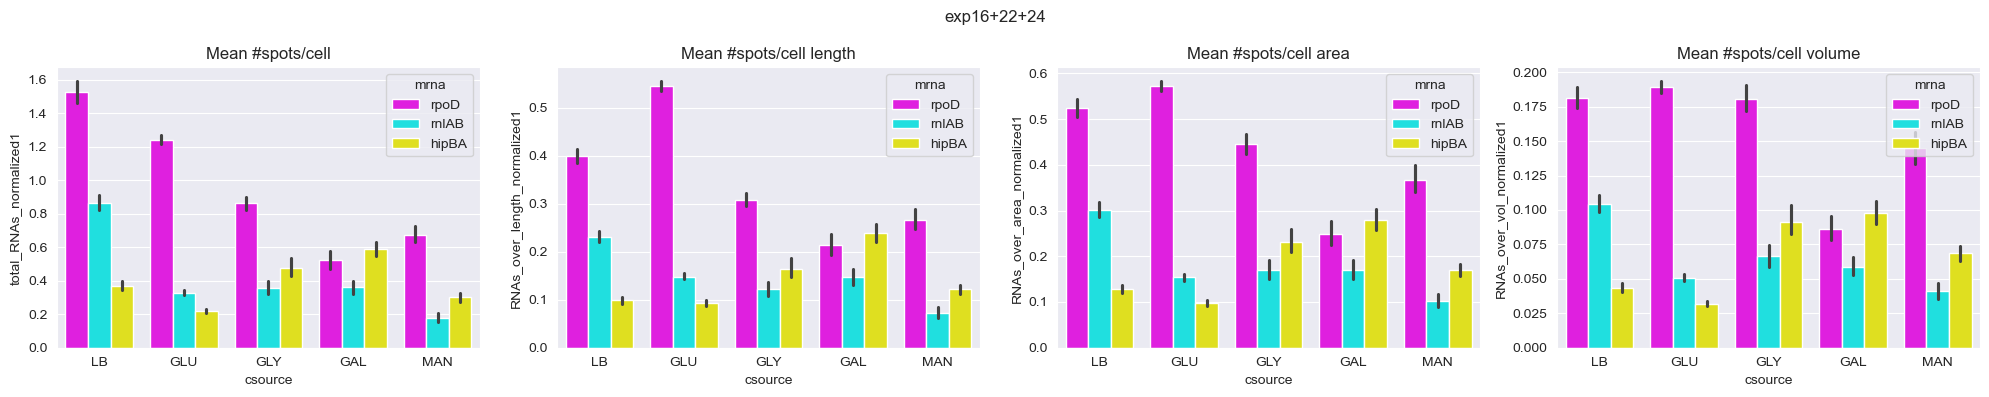

In [93]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by_genome_copy_number_exp16+22+24")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


###### Normalized by genome copy number and gene copy number


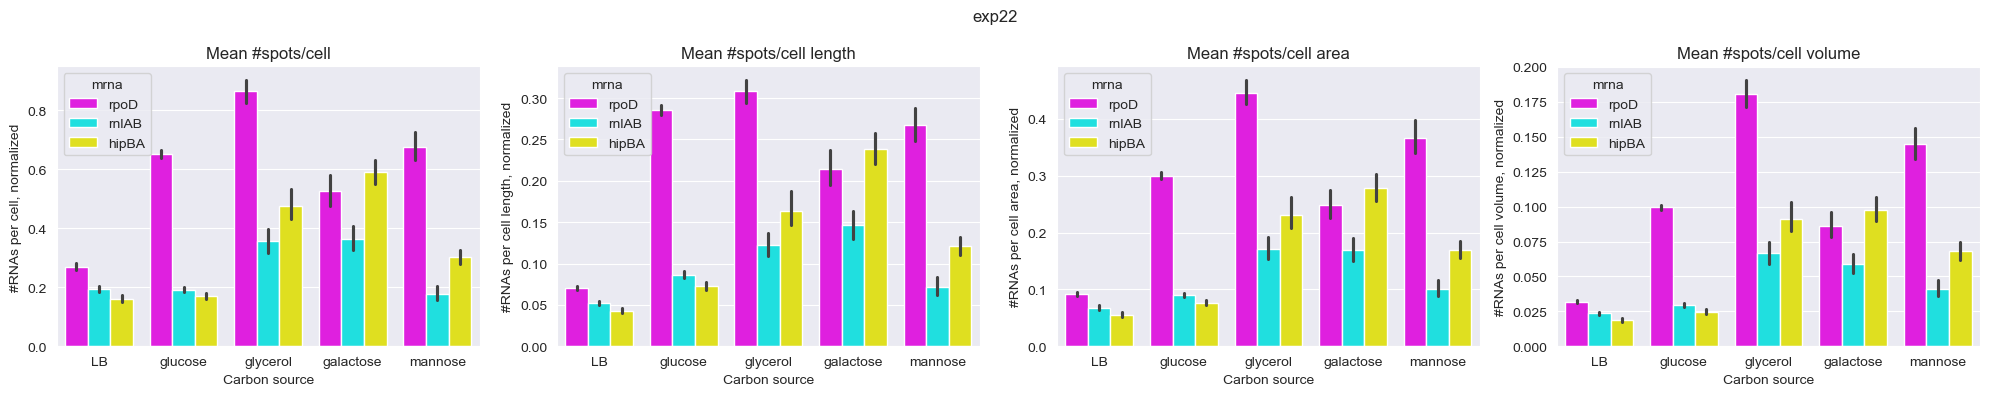

In [94]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell', xlabel='Carbon source', ylabel='#RNAs per cell, normalized')

g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length', xlabel='Carbon source', ylabel='#RNAs per cell length, normalized')

g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area', xlabel='Carbon source', ylabel='#RNAs per cell area, normalized')

g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume', xlabel='Carbon source', ylabel='#RNAs per cell volume, normalized');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by genome_and_gene_copy_number_exp16+22+24")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC

# doesn't sigma70 condition the other two anyway? They are not independent, are they?



##### exp22

###### Unnormalized

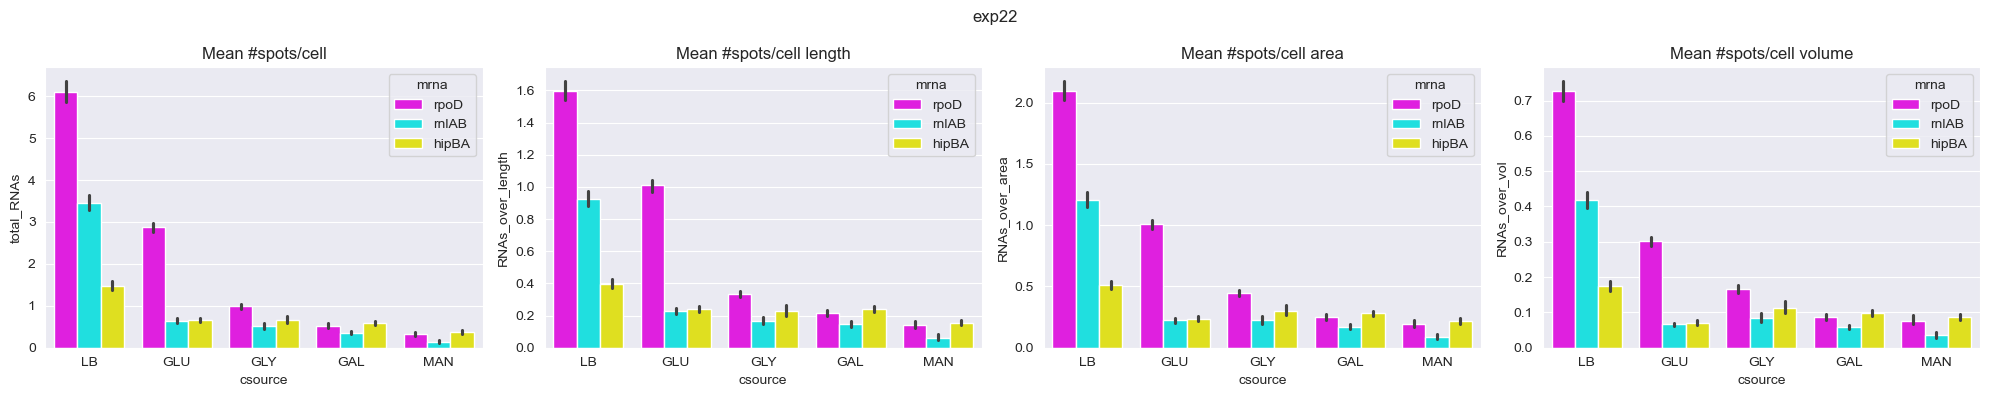

In [102]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


###### Normalized by genome copy number

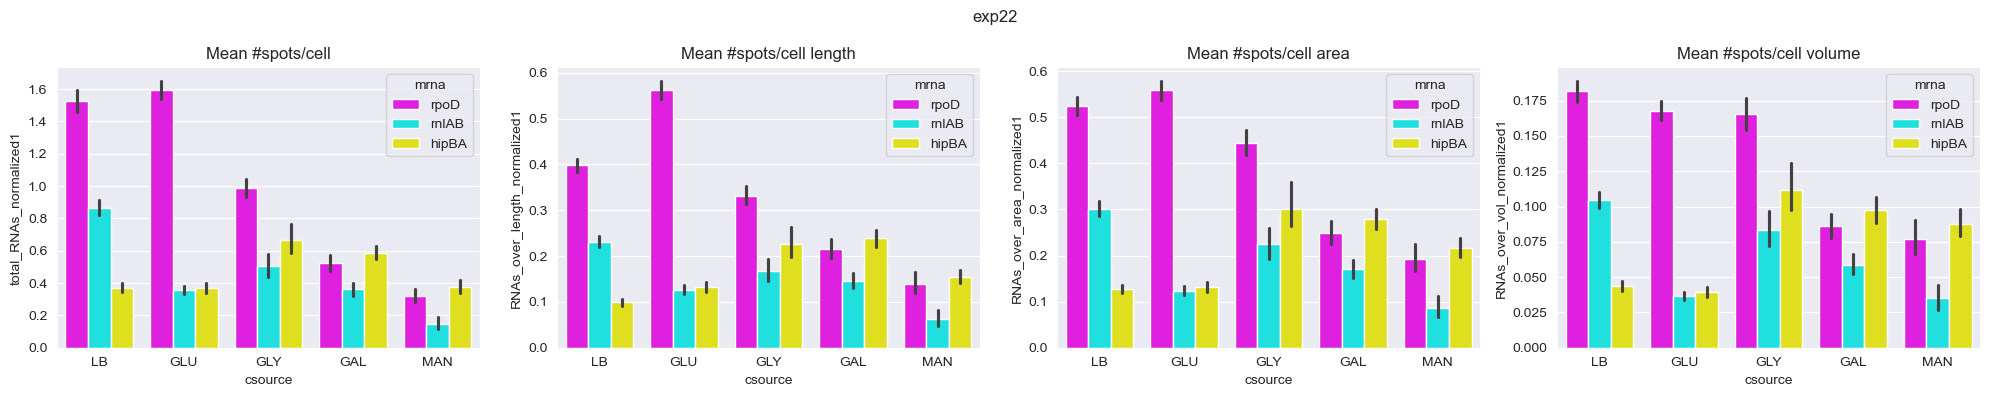

In [103]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by_genome_copy_number_exp22")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


###### Normalized by genome copy number and gene copy number


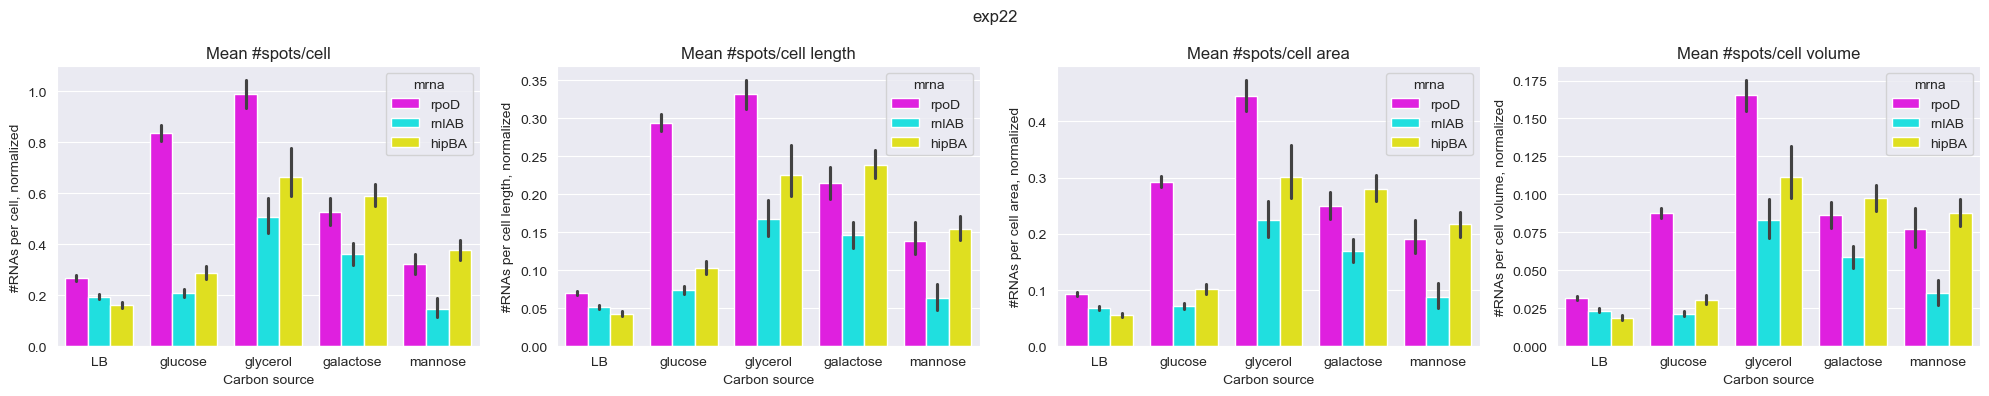

In [104]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell', xlabel='Carbon source', ylabel='#RNAs per cell, normalized')

g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length', xlabel='Carbon source', ylabel='#RNAs per cell length, normalized')

g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area', xlabel='Carbon source', ylabel='#RNAs per cell area, normalized')

g = sns.barplot(data=data, x='csource_d', order=csources_ordered_d, y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume', xlabel='Carbon source', ylabel='#RNAs per cell volume, normalized');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by genome_and_gene_copy_number_exp22")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC

# doesn't sigma70 condition the other two anyway? They are not independent, are they?



###### All 3 versions on the same plot

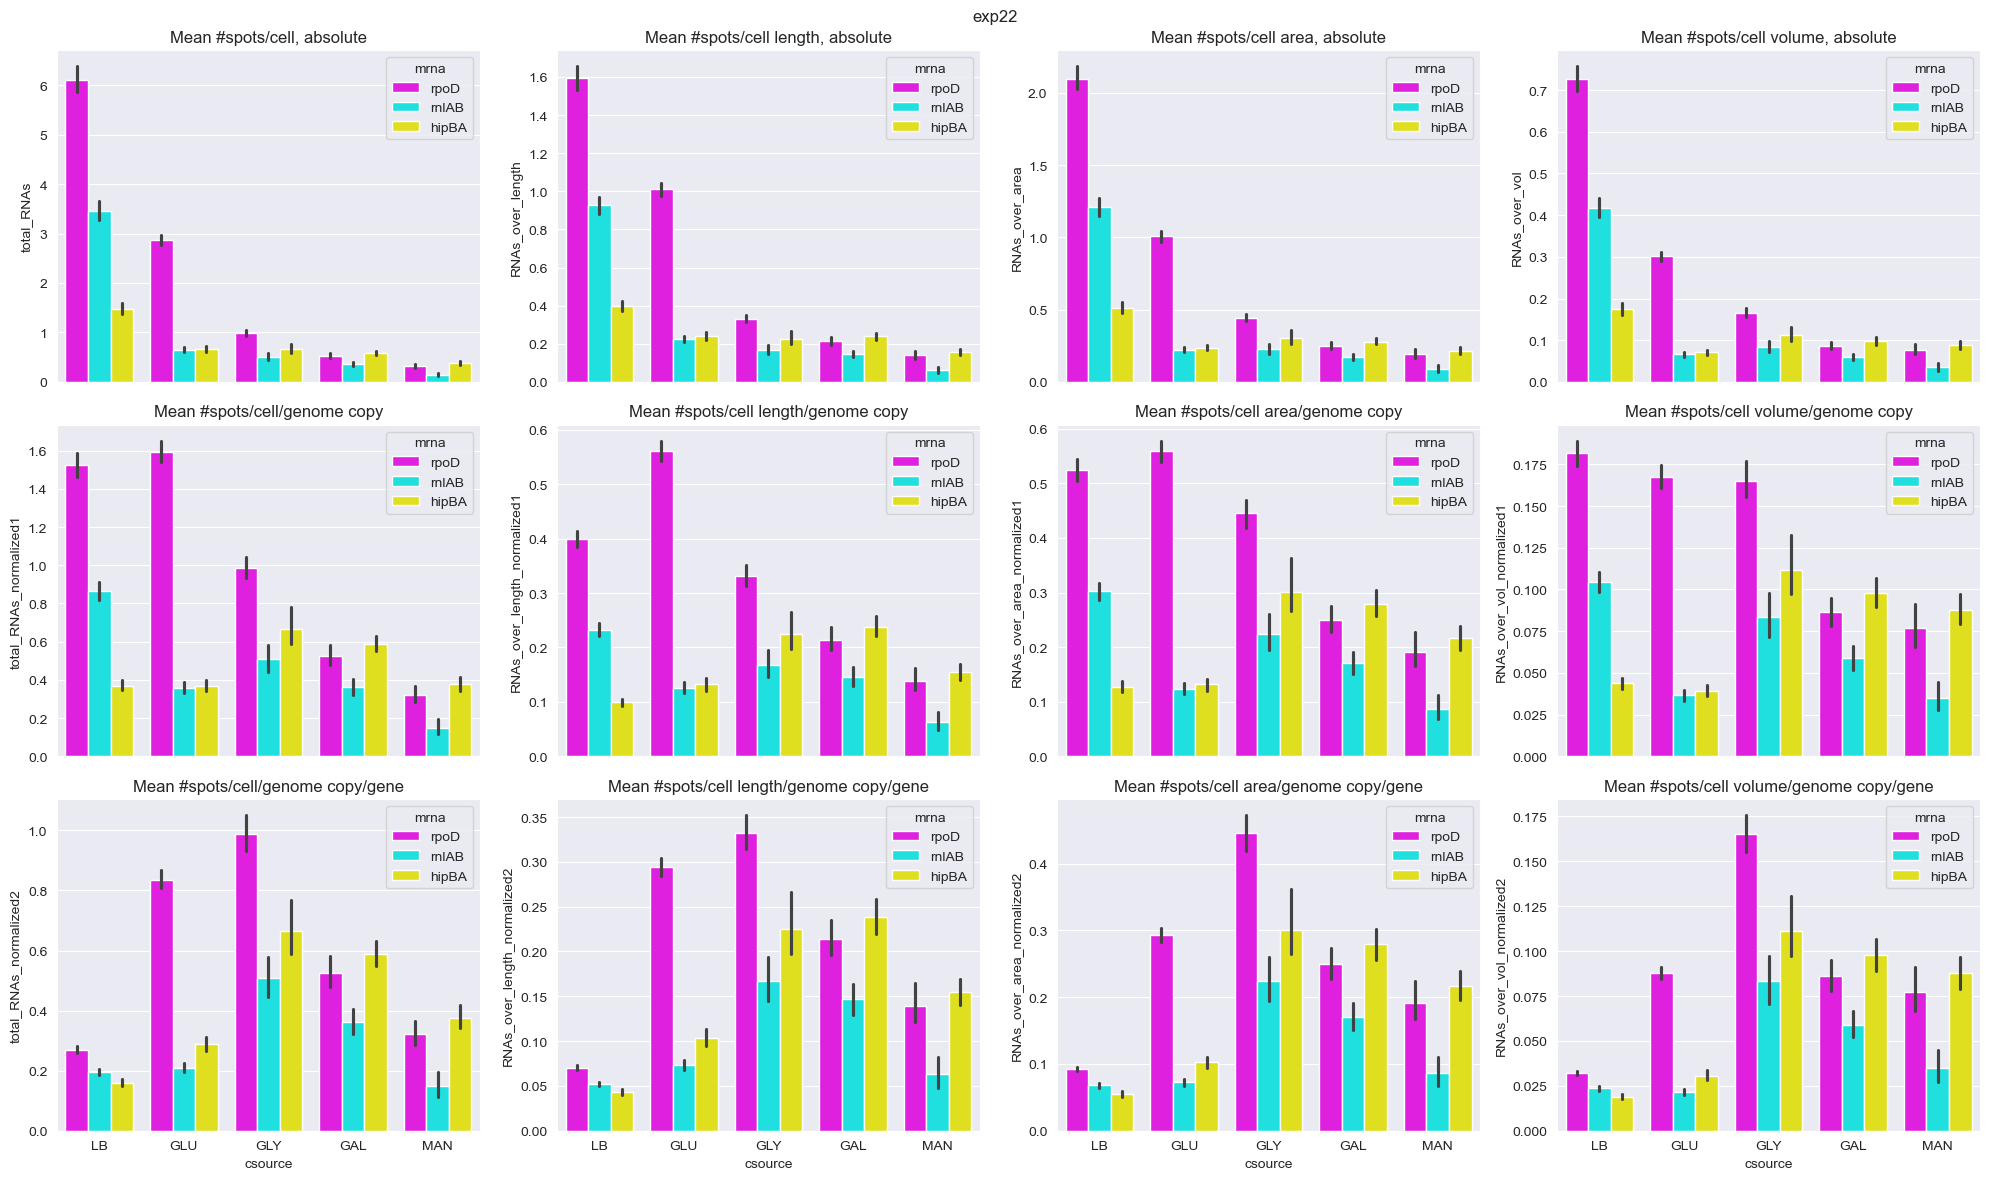

In [108]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(3, 4, figsize=(20, 12), sharex=True)


# Absolute
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell, absolute')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/cell length, absolute')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][2])
g.set(title='Mean #spots/cell area, absolute')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][3])
g.set(title='Mean #spots/cell volume, absolute')

# Normalized by genome copy number
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean #spots/cell/genome copy')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean #spots/cell length/genome copy')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][2])
g.set(title='Mean #spots/cell area/genome copy')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][3])
g.set(title='Mean #spots/cell volume/genome copy')


# Normalized by genome copy number and gene copy number
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][0])
g.set(title='Mean #spots/cell/genome copy/gene')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][1])
g.set(title='Mean #spots/cell length/genome copy/gene')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][2])
g.set(title='Mean #spots/cell area/genome copy/gene')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][3])
g.set(title='Mean #spots/cell volume/genome copy/gene')


fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_all_3versions_exp22")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


#### Noise and Fano factor 
as per Taniguchi 2010, except:
- "Because the same probe is used for all strains, the optimized hybridization efficiency is unbiased for every measured gene"
is not true for us.
- also not: "We excluded gene dosage effects by gating with the cell size to select the cells that have not yet gone through chromosome replication"
- 

##### Per replicate

In [207]:
rep_mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].sum()
rep_cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna']).size()
rep_frequencies_series = rep_mrna_counts / rep_cell_counts
rep_frequencies_series.name = "mean"
rep_frequencies = pd.DataFrame(rep_frequencies_series).reset_index()
rep_mrna_stds = pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].std()).reset_index()
rep_mrna_stds.rename(columns={'total_RNAs': 'std'}, inplace=True)
rep_frequencies = rep_frequencies.merge(rep_mrna_stds, on=['strain', 'csource', 'replicate', 'mrna'])
rep_frequencies['noise'] = np.square(rep_frequencies['std'] / rep_frequencies['mean'])
rep_frequencies['fano'] = np.square(rep_frequencies['std']) / rep_frequencies['mean']
rep_frequencies

strain csource replicate   mrna  mean   std  noise  fano
0   MG1655     GAL     exp22  hipBA  0.59  0.95   2.62  1.54
1   MG1655     GAL     exp22  rnlAB  0.37  0.97   6.86  2.54
2   MG1655     GAL     exp22   rpoD  0.53  1.15   4.68  2.48
3   MG1655     GLU     exp16  hipBA  0.37  0.89   5.91  2.16
4   MG1655     GLU     exp16  rnlAB  0.75  1.04   1.94  1.45
5   MG1655     GLU     exp16   rpoD  2.43  1.52   0.39  0.95
6   MG1655     GLU     exp22  hipBA  0.69  1.04   2.26  1.56
7   MG1655     GLU     exp22  rnlAB  0.67  0.96   2.06  1.38
8   MG1655     GLU     exp22   rpoD  2.98  2.12   0.51  1.51
9   MG1655     GLU     exp24  hipBA  0.16  0.48   9.22  1.46
10  MG1655     GLU     exp24  rnlAB  0.12  0.39  11.69  1.35
11  MG1655     GLU     exp24   rpoD  0.97  1.21   1.58  1.52
12  MG1655     GLY     exp16  hipBA  0.17  0.57  11.87  1.97
13  MG1655     GLY     exp16  rnlAB  0.29  0.99  11.85  3.41
14  MG1655     GLY     exp16   rpoD  1.00  2.00   4.00  4.01
15  MG1655     GLY     exp22  hipBA  0.69  2.23  10.37  7.19
16  MG1655     GLY     exp22  rnlAB  0.54  1.69   9.92  5.33
17  MG1655     GLY     exp22   rpoD  1.06  1.44   1.86  1.96
18  MG1655     GLY     exp24  hipBA  0.29  0.91  10.01  2.89
19  MG1655     GLY     exp24  rnlAB  0.18  0.78  19.39  3.45
20  MG1655     GLY     exp24   rpoD  0.68  1.00   2.17  1.48
21  MG1655      LB     exp22  hipBA  1.42  1.69   1.42  2.01
22  MG1655      LB     exp22  rnlAB  3.10  3.00   0.93  2.90
23  MG1655      LB     exp22   rpoD  5.63  4.13   0.54  3.03
24  MG1655     MAN     exp16  hipBA  0.22  0.59   7.26  1.59
25  MG1655     MAN     exp16  rnlAB  0.23  0.62   7.11  1.66
26  MG1655     MAN     exp16   rpoD  1.16  1.91   2.70  3.14
27  MG1655     MAN     exp22  hipBA  0.39  0.85   4.84  1.87
28  MG1655     MAN     exp22  rnlAB  0.15  0.87  31.86  4.90
29  MG1655     MAN     exp22   rpoD  0.33  0.93   7.92  2.62

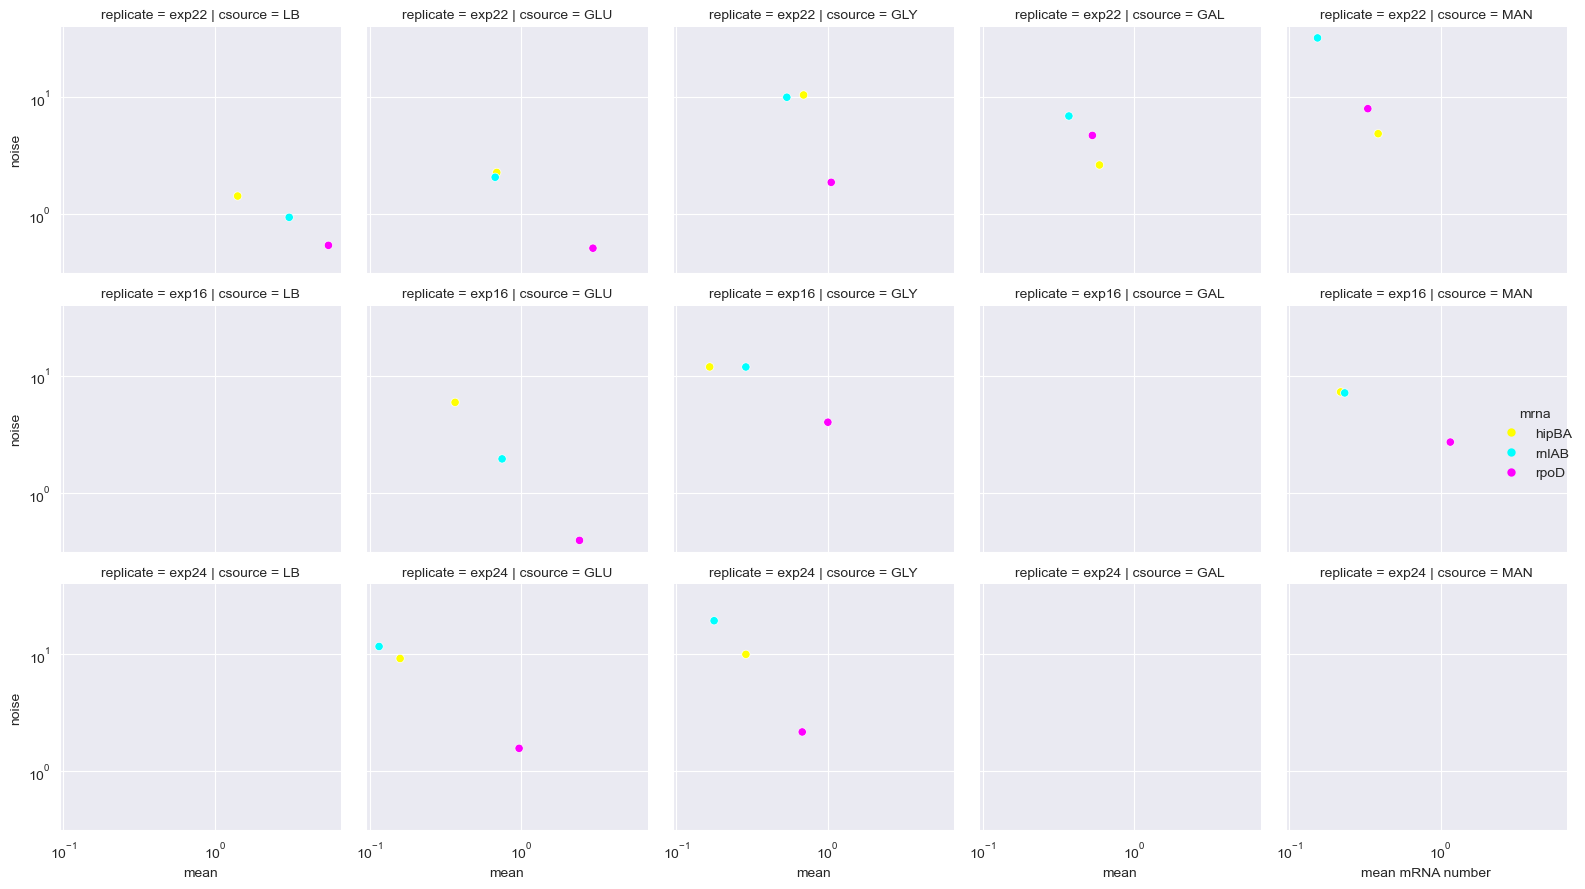

In [208]:
sns.relplot(rep_frequencies, x='mean', y='noise', 
            col='csource', col_order=csources_ordered, 
            row='replicate', 
            hue='mrna', palette=palette_mrna,
            height=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

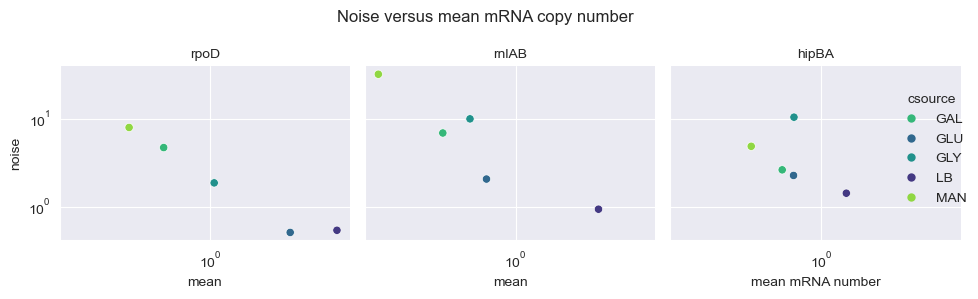

In [209]:
g = sns.relplot(rep_frequencies.query('replicate == "exp22"'), x='mean', y='noise', 
            col='mrna', col_order=mrna_ordered, 
            row='replicate', 
            hue='csource', palette=palette_csource,
            height=3)
g.set_titles('{col_name}');
g.fig.suptitle("Noise versus mean mRNA copy number")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/noise_vs_mean_expression-exp22"
plt.savefig(savestem + ".pdf")

##### Per image

In [210]:
mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].sum()  # Number of spots per csource per image per channel
cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna']).size() # Number of cells per csource per image exploded per channel
frequencies_series = mrna_counts / cell_counts # mean number of spots per image per channel
frequencies_series.name = "mean"
frequencies = pd.DataFrame(frequencies_series).reset_index()
mrna_stds = pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].std()).reset_index() # Standard deviation of number of spots per csource per image per channel
mrna_stds.rename(columns={'total_RNAs': 'std'}, inplace=True)
frequencies = frequencies.merge(mrna_stds, on=['strain', 'csource', 'replicate', 'mrna', 'seqnr'])
frequencies['noise'] = np.square(frequencies['std'] / frequencies['mean']) # noise
frequencies['fano'] = np.square(frequencies['std']) / frequencies['mean'] # Fano factor

frequencies

strain csource replicate seqnr   mrna  mean   std  noise  fano
0    MG1655     GAL     exp22    03  hipBA  0.52  0.86   2.68  1.40
1    MG1655     GAL     exp22    03  rnlAB  0.31  0.98  10.25  3.15
2    MG1655     GAL     exp22    03   rpoD  0.46  0.93   4.19  1.91
3    MG1655     GAL     exp22    04  hipBA  0.74  1.10   2.21  1.64
4    MG1655     GAL     exp22    04  rnlAB  0.44  1.01   5.28  2.32
..      ...     ...       ...   ...    ...   ...   ...    ...   ...
124  MG1655     MAN     exp22    05  rnlAB  0.11  0.48  17.49  2.00
125  MG1655     MAN     exp22    05   rpoD  0.35  0.62   3.15  1.10
126  MG1655     MAN     exp22    06  hipBA  0.33  1.00   9.23  3.02
127  MG1655     MAN     exp22    06  rnlAB  0.11  0.58  26.48  3.00
128  MG1655     MAN     exp22    06   rpoD  0.25  0.55   4.96  1.23

[129 rows x 9 columns]

In [211]:
frequencies.query('replicate == "exp22"').query('csource == "GLY"')

strain csource replicate seqnr   mrna  mean   std  noise  fano
72  MG1655     GLY     exp22    09  hipBA  0.68  2.28  11.17  7.62
73  MG1655     GLY     exp22    09  rnlAB  0.50  1.51   9.21  4.59
74  MG1655     GLY     exp22    09   rpoD  1.04  1.39   1.81  1.88
75  MG1655     GLY     exp22    10  hipBA  0.86  1.32   2.38  2.04
76  MG1655     GLY     exp22    10  rnlAB  1.11  3.33   8.98  9.99
77  MG1655     GLY     exp22    10   rpoD  1.34  1.97   2.18  2.92

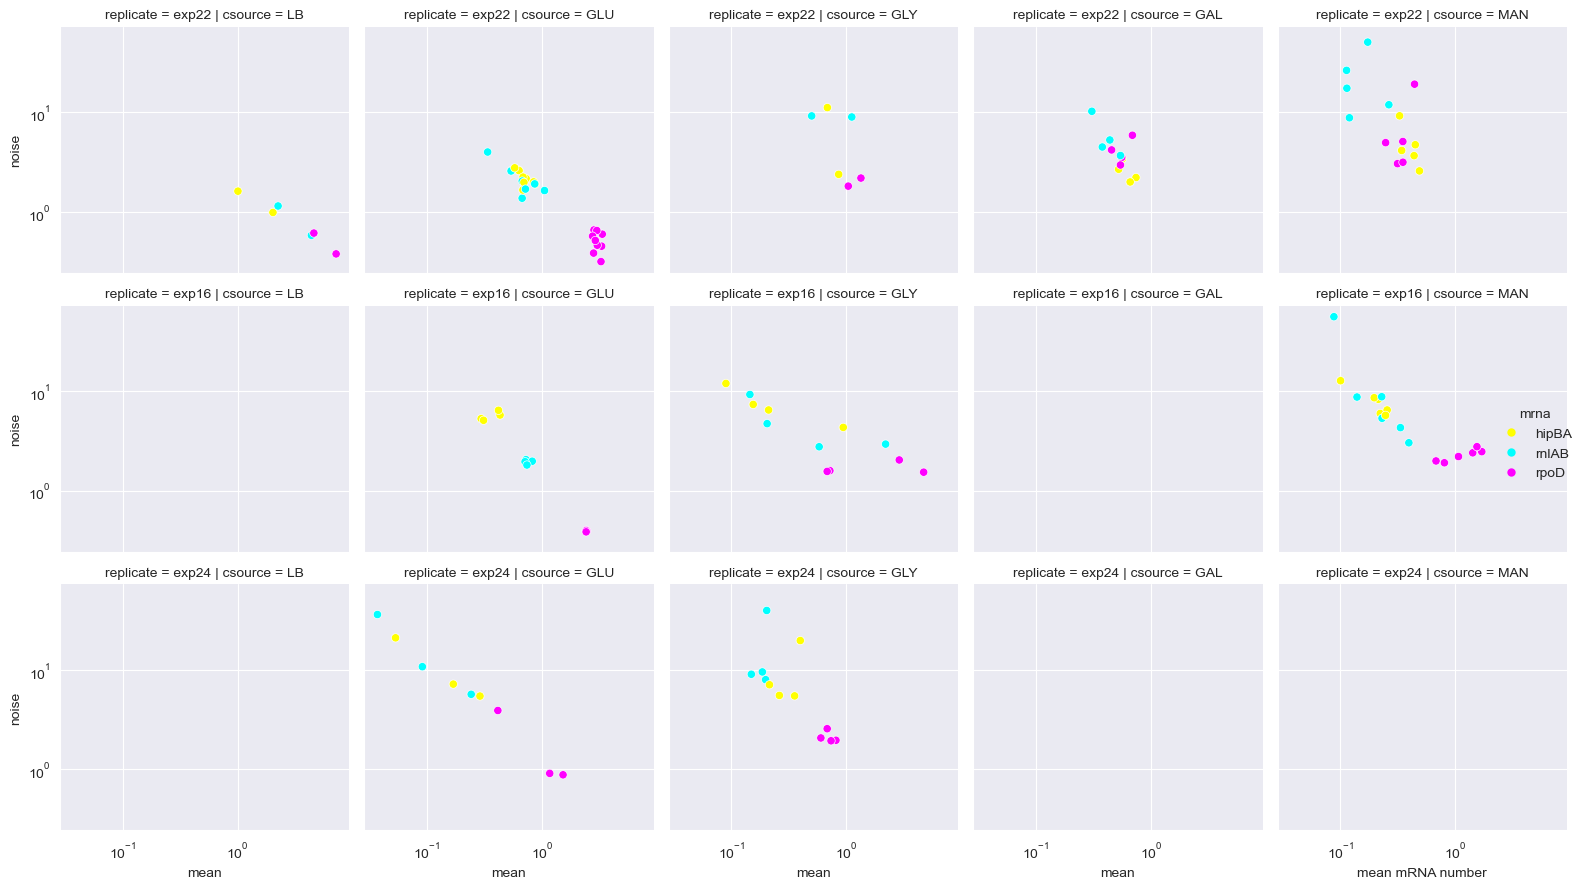

In [212]:
sns.relplot(frequencies, x='mean', y='noise', 
            col='csource', col_order=csources_ordered, 
            row='replicate', 
            hue='mrna', palette=palette_mrna,
            height=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

#### Mean number of spots/cell per image
This is just to check how consistent the data is across images.

##### QC plot

NameError: name 'frequencies' is not defined

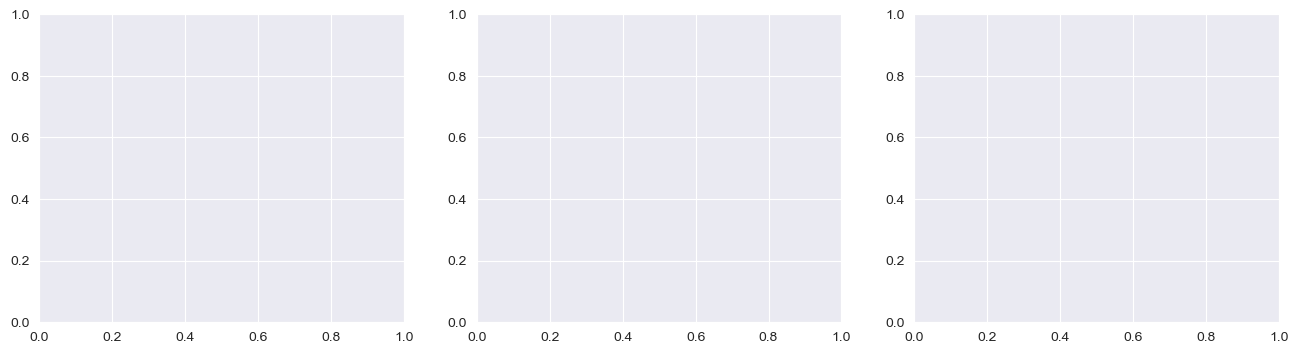

In [206]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.stripplot(frequencies, x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna, ax=ax[0])
ax[0].set(title='mRNA frequencies across images (all data)', xlabel='carbon source', ylabel='frequency')
sns.stripplot(frequencies.query("replicate == 'exp22'"), x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna, ax=ax[1])
ax[1].set(title='mRNA frequencies across images (exp22)', xlabel='carbon source', ylabel='frequency')
sns.stripplot(frequencies.query("replicate != 'exp16'"), x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna, ax=ax[2])
ax[2].set(title='mRNA frequencies across images (exp22 + exp24)', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within one condition

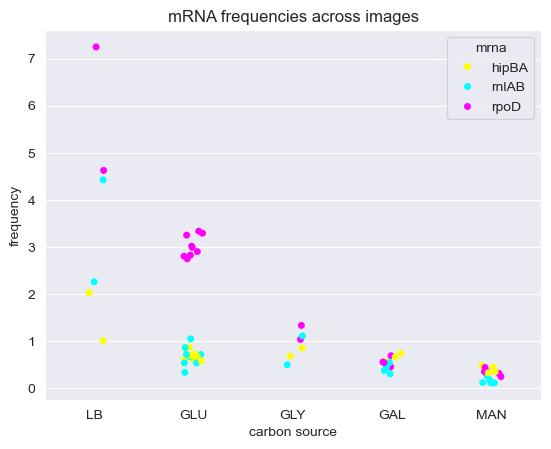

In [97]:
g = sns.stripplot(frequencies.query("replicate == 'exp22'"), x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency')

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/QC/mean_expression_per_image_vs_condition"
plt.savefig(savestem + ".pdf")
# numbers need to be consistent across images within one condition




#### Distribution facetted by csource and mRNA

Cell expression histograms per csource per mRNA = 
#spots/cell for csource, aggregated over all images for csource
[TODO] add the mean


##### Explo plot - all data

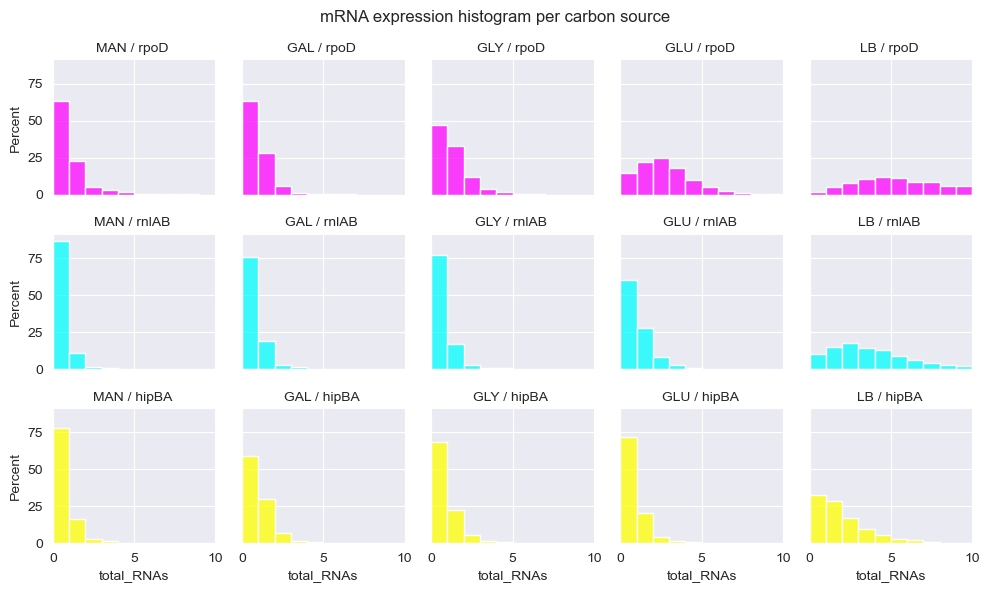

In [871]:
sns.set_style({"grid": False})
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered,
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

##### Demo plot - only exp22 data

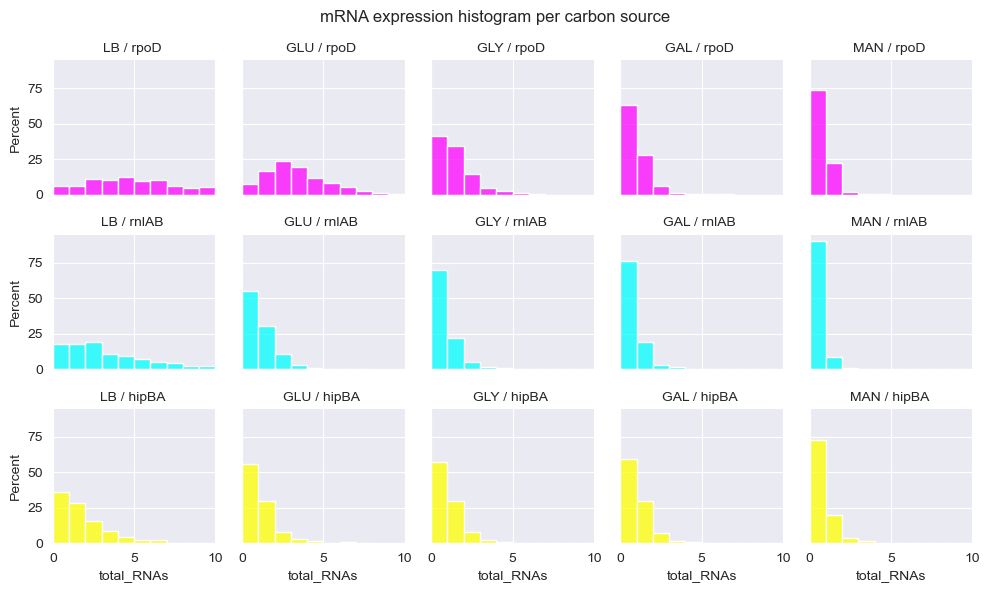

In [107]:
sns.set_style("darkgrid")
# sns.set_style("whitegrid", {"axes.facecolor": "xkcd:darkblue", "grid.color": "xkcd:aubergine", "text.color": "black", "legend.facecolor": "white"})

data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/distribution_expression_vs_condition"
plt.savefig(savestem + ".pdf")

##### Demo plot - exp22 + exp24 data

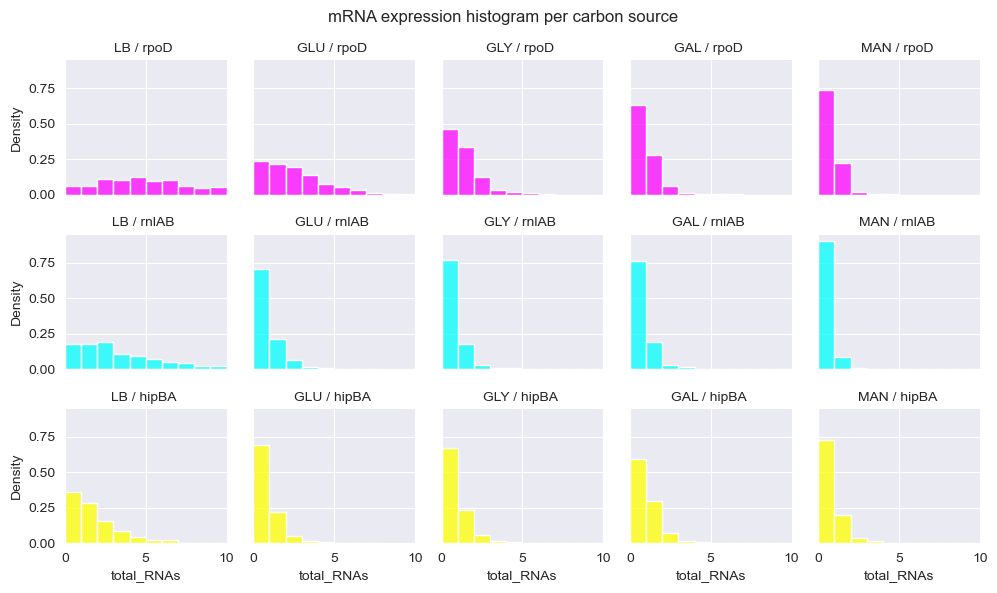

In [108]:
data = df_stacked.query('replicate != "exp16"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='density')
g.set_titles('{col_name} / {row_name} ')
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();
# compare to the data from the Golding paper

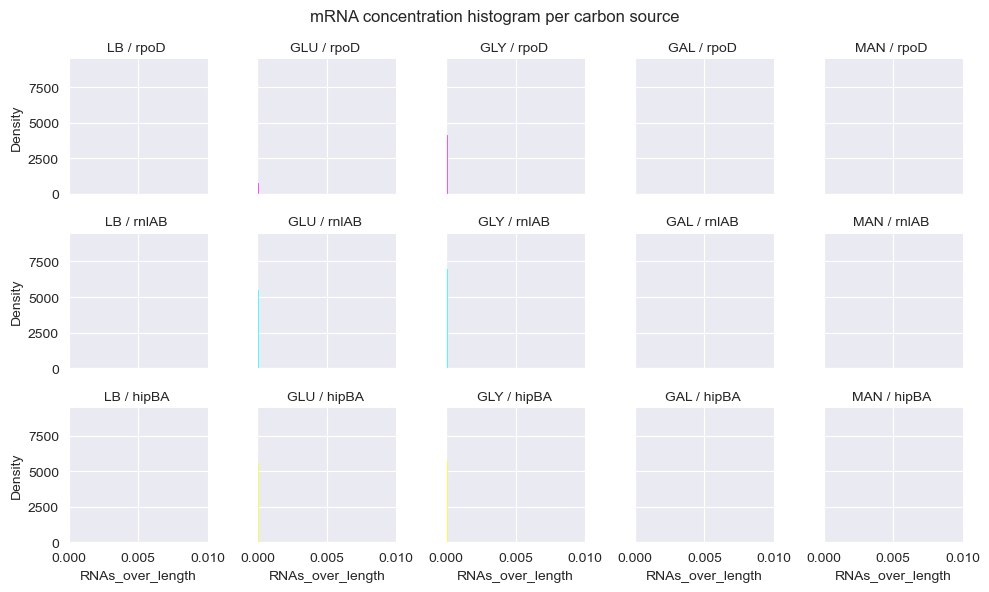

In [110]:
data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_length', binwidth=0.0001, stat='density')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

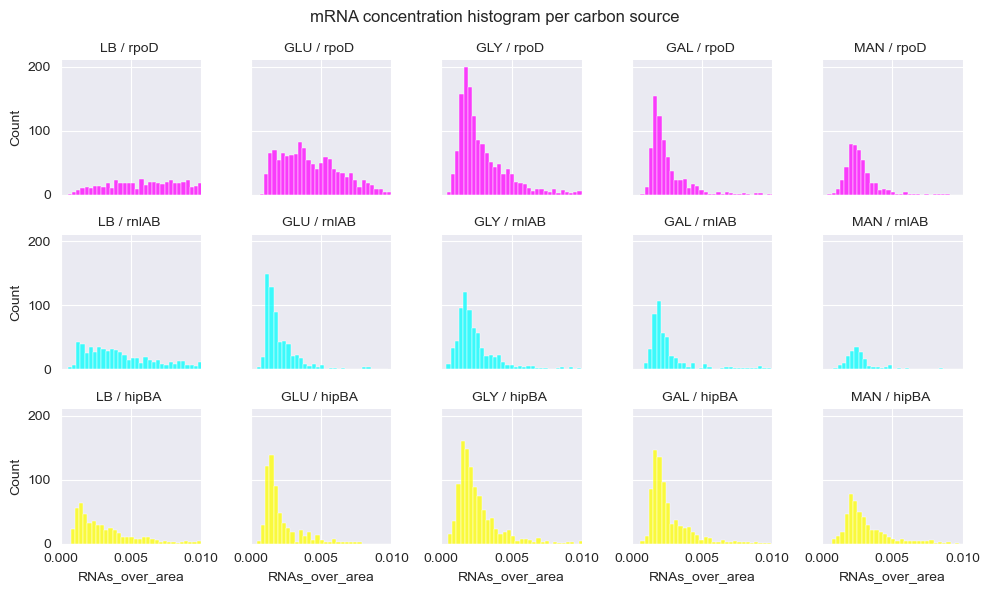

In [113]:
data = df_stacked.query('replicate == "exp22"').query('RNAs_over_length > 0')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_area', binwidth=0.0003)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

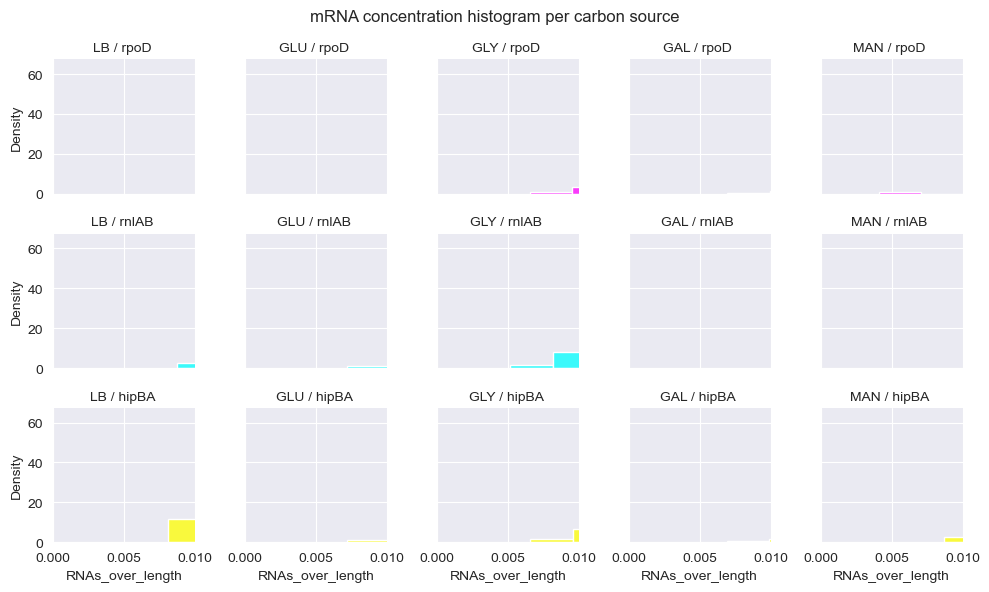

In [123]:
data = df_stacked.query('replicate == "exp22"').query('RNAs_over_length > 0')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_length', binwidth=0.003, stat='density')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

#### Distribution of number of spots

##### Explo plot - which I don't fully understand

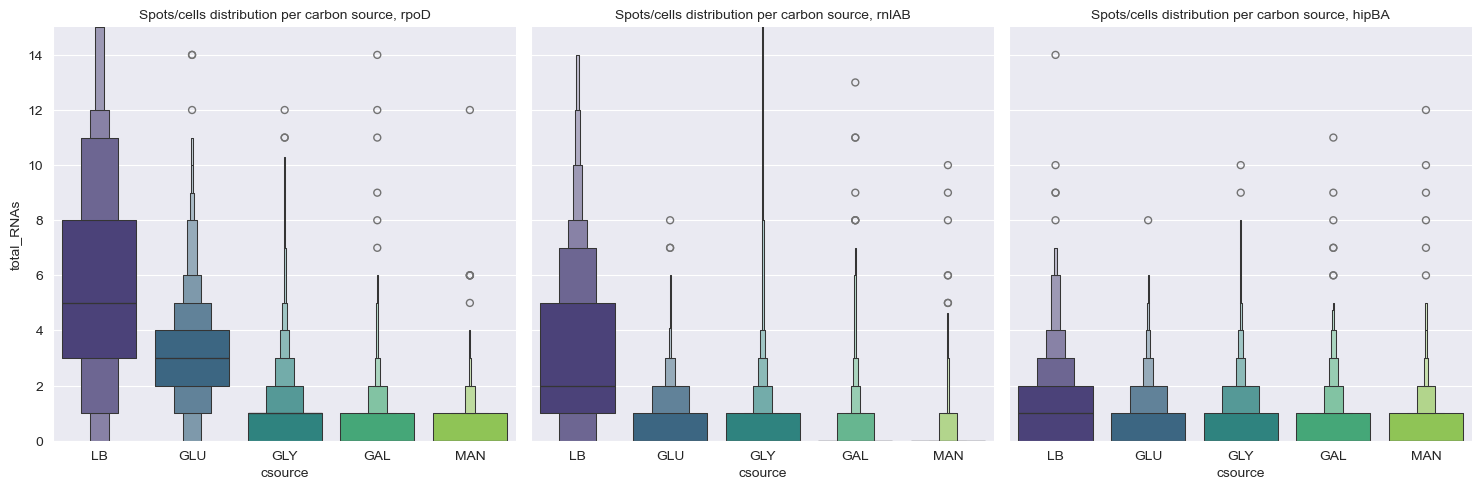

In [54]:
data=df_stacked.query('replicate == "exp22"')
g = sns.catplot(data=data, kind='boxen', x='csource', order=csources_ordered, y='total_RNAs', width_method='exponential', 
            col='mrna', col_order=mrna_ordered,
            hue='csource', palette=palette_csource)
g.set_titles('Spots/cells distribution per carbon source, {col_name}')
g.set(ylim=(0, 15));

#### Evolution of fraction of cells with n spots with growth rate

In [55]:
dfs = []
for (mrna, csource) in product(mrna_ordered, csources_ordered):
    d = data.query('mrna == @mrna').query('csource == @csource')
    counts = np.bincount(d['total_RNAs'])
    df = pd.DataFrame({
        'mrna': mrna,
        'csource': csource,
        'rank': np.arange(len(counts)),
        'nr_cells_at_rank': np.bincount(d['total_RNAs']),
        'nr_cells_total': np.full_like(counts, d.shape[0]), 
    })
    # print(df)
    dfs.append(df)
histograms = pd.DataFrame(pd.concat(dfs))
histograms['frequency'] = histograms['nr_cells_at_rank'] / histograms['nr_cells_total']
histograms

mrna csource  rank  nr_cells_at_rank  nr_cells_total  frequency
0    rpoD      LB     0                53             813   6.52e-02
1    rpoD      LB     1                52             813   6.40e-02
2    rpoD      LB     2                89             813   1.09e-01
3    rpoD      LB     3                83             813   1.02e-01
4    rpoD      LB     4               102             813   1.25e-01
..    ...     ...   ...               ...             ...        ...
8   hipBA     MAN     8                 1            1885   5.31e-04
9   hipBA     MAN     9                 1            1885   5.31e-04
10  hipBA     MAN    10                 1            1885   5.31e-04
11  hipBA     MAN    11                 0            1885   0.00e+00
12  hipBA     MAN    12                 1            1885   5.31e-04

[391 rows x 6 columns]

##### Explo plot

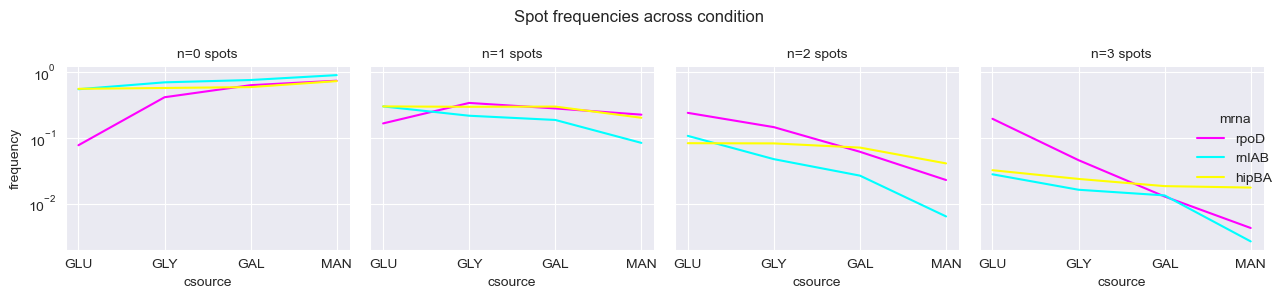

In [56]:
g = sns.relplot(data=histograms.query('rank < 4').query('csource != "LB"'), x='csource', y='frequency',
            col='rank', hue='mrna', palette=palette_mrna, kind='line', height=3)
g.set_titles('n={col_name} spots')
g.set(yscale="log")
g.fig.suptitle("Spot frequencies across condition")
plt.tight_layout();

### Expression versus cell features

#### Area

##### Plot - all data

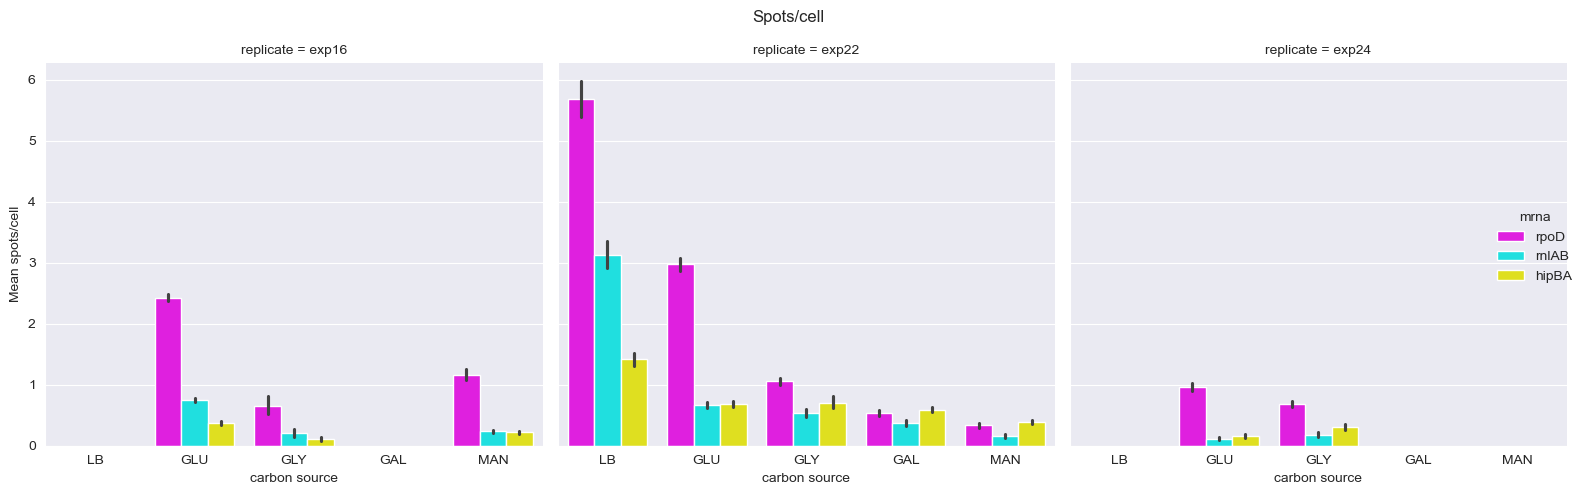

In [57]:
g = sns.catplot(df_stacked,
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean spots/cell')
g.fig.suptitle('Spots/cell')
plt.tight_layout();

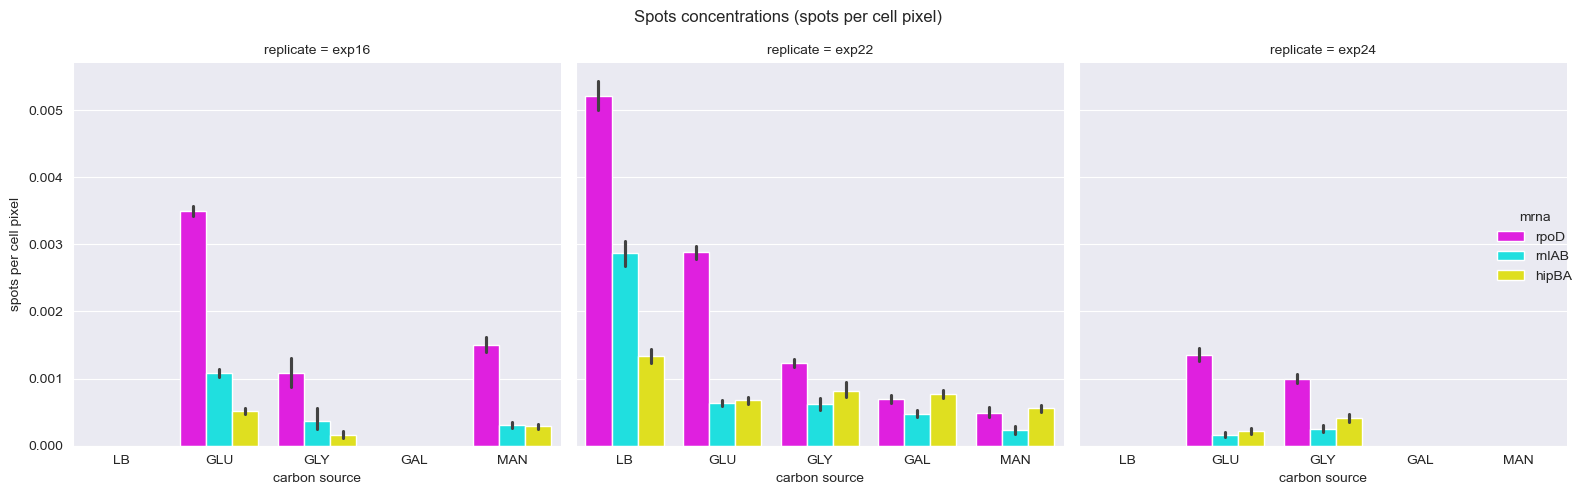

In [58]:
g = sns.catplot(df_stacked, kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_area', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='spots per cell pixel')
g.fig.suptitle('Spots concentrations (spots per cell pixel)')
plt.tight_layout();

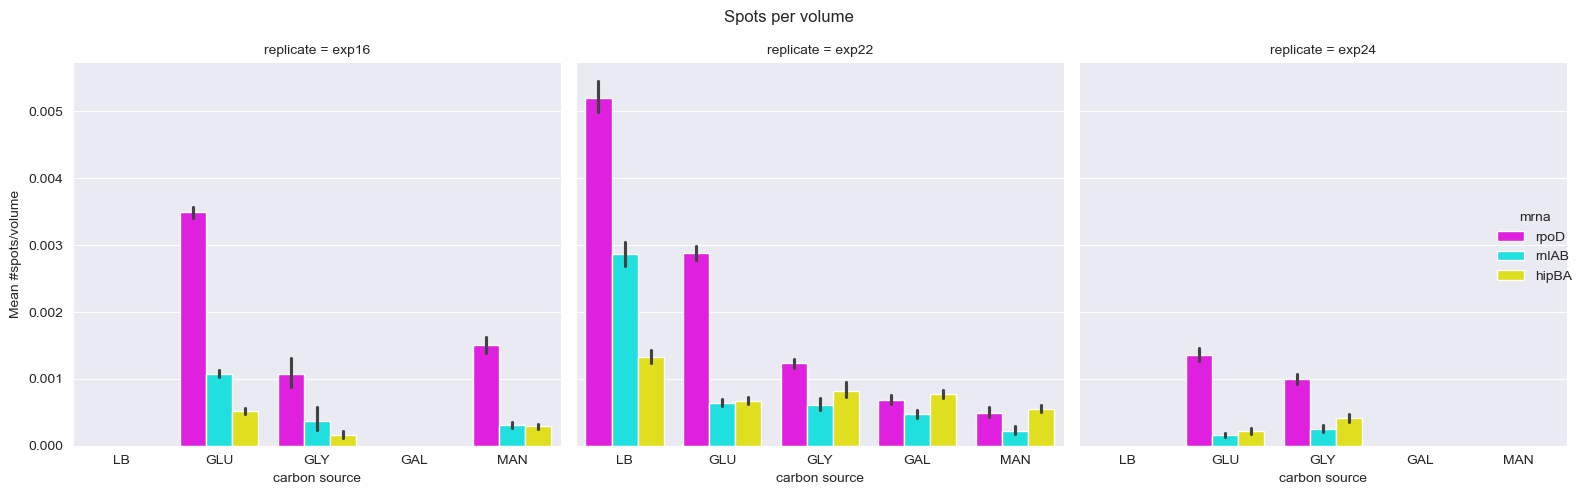

In [59]:
g = sns.catplot(df_stacked, kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_area', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/volume')
g.fig.suptitle('Spots per volume')
plt.tight_layout();

In [60]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'RNAs_over_area', 'volume',
       'volume_ellipsoid', 'RNAs_over_vol', 'RNAs_over_length',
       'RNAs_over_eccentricity', 'mu'],
      dtype='object')

In [61]:
df_stacked.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486],
      dtype='int64', length=48765)

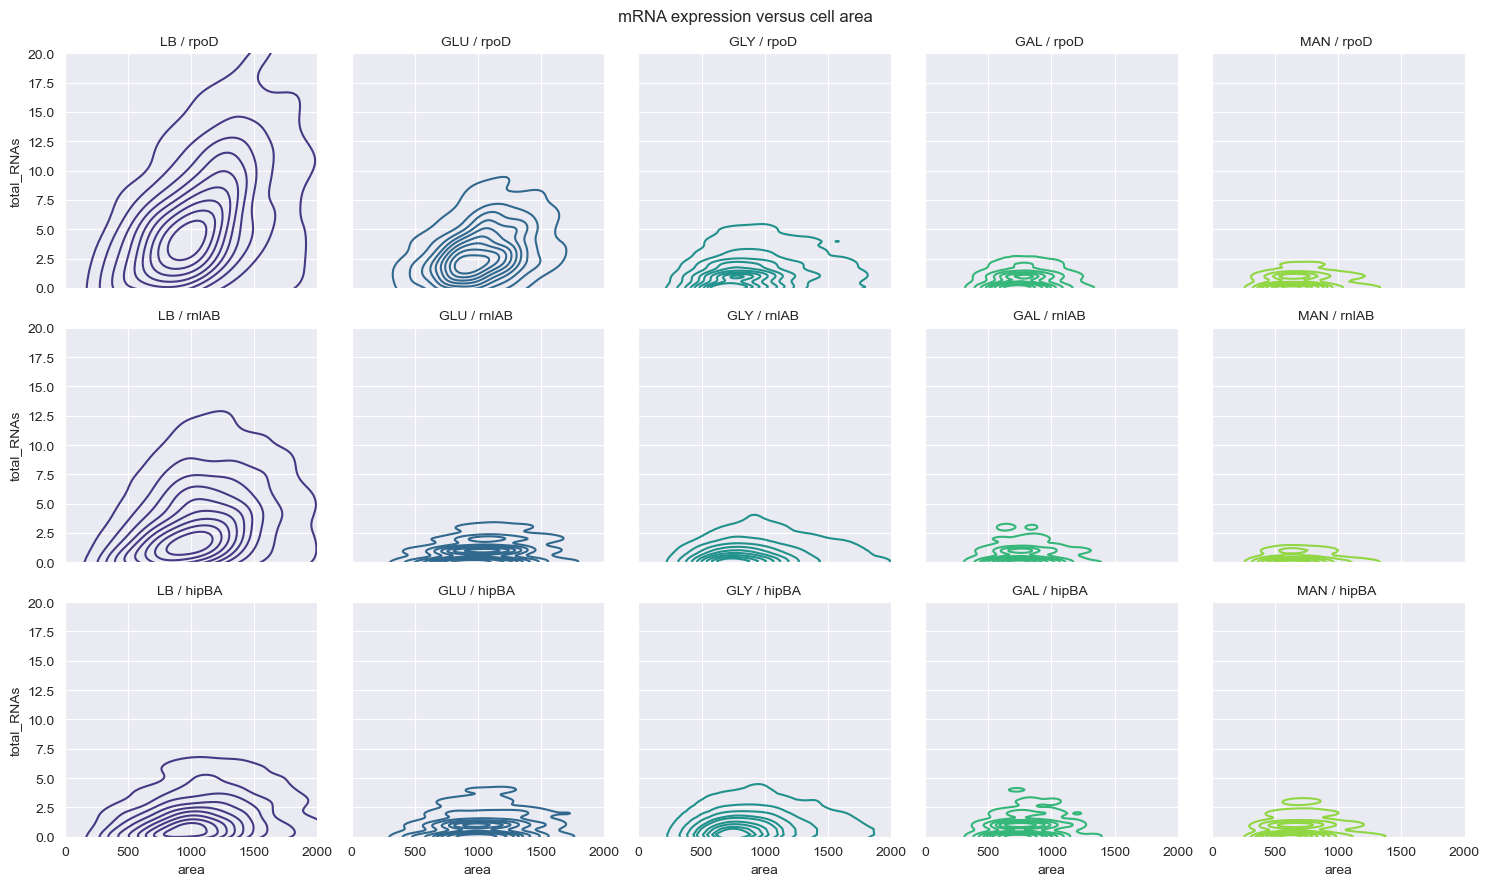

In [62]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  xlim=(0, 2000), ylim=(0, 20),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='area', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### Eccentricity / length

##### Plot - exp22 + exp24

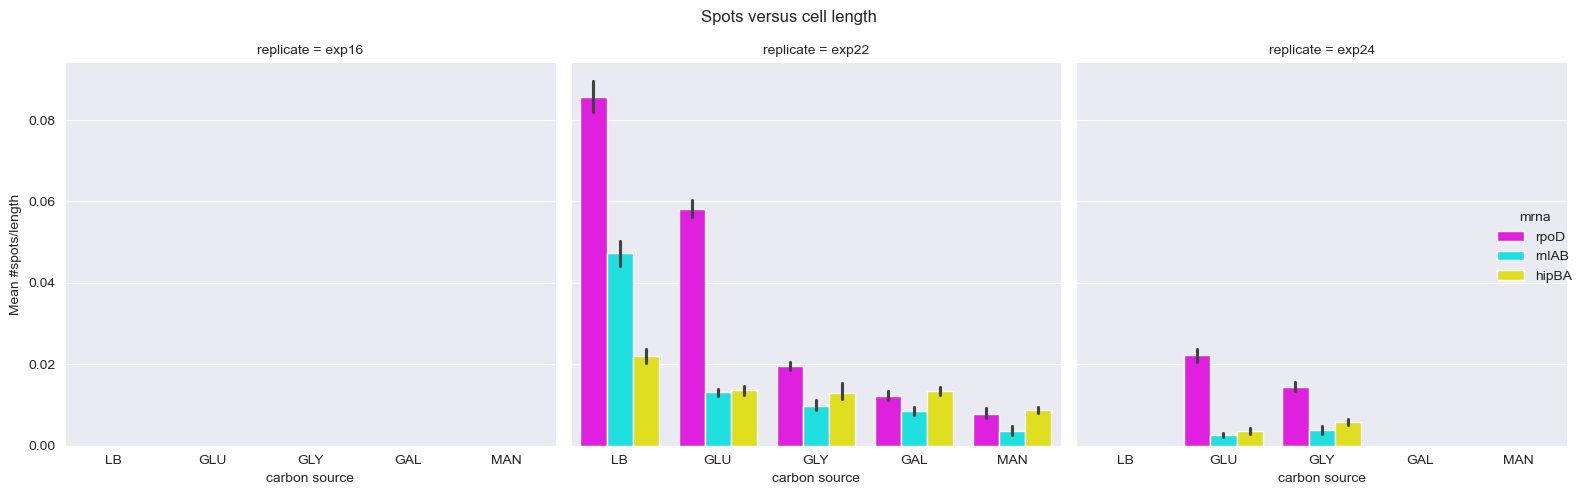

In [63]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_length', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/length')
g.fig.suptitle('Spots versus cell length')
plt.tight_layout();

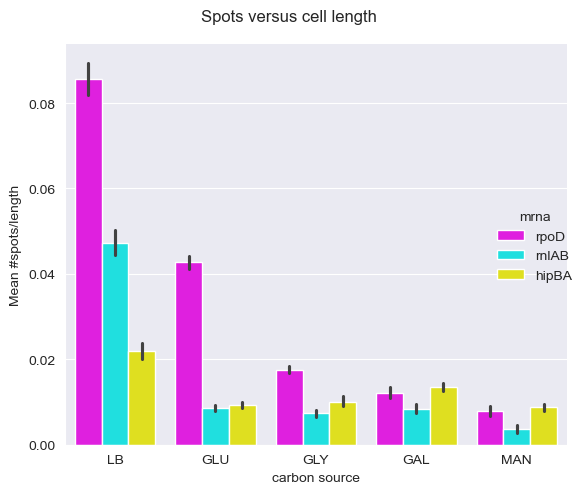

In [64]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            x='csource', order=csources_ordered, y='RNAs_over_length', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/length')
g.fig.suptitle('Spots versus cell length')
plt.tight_layout();

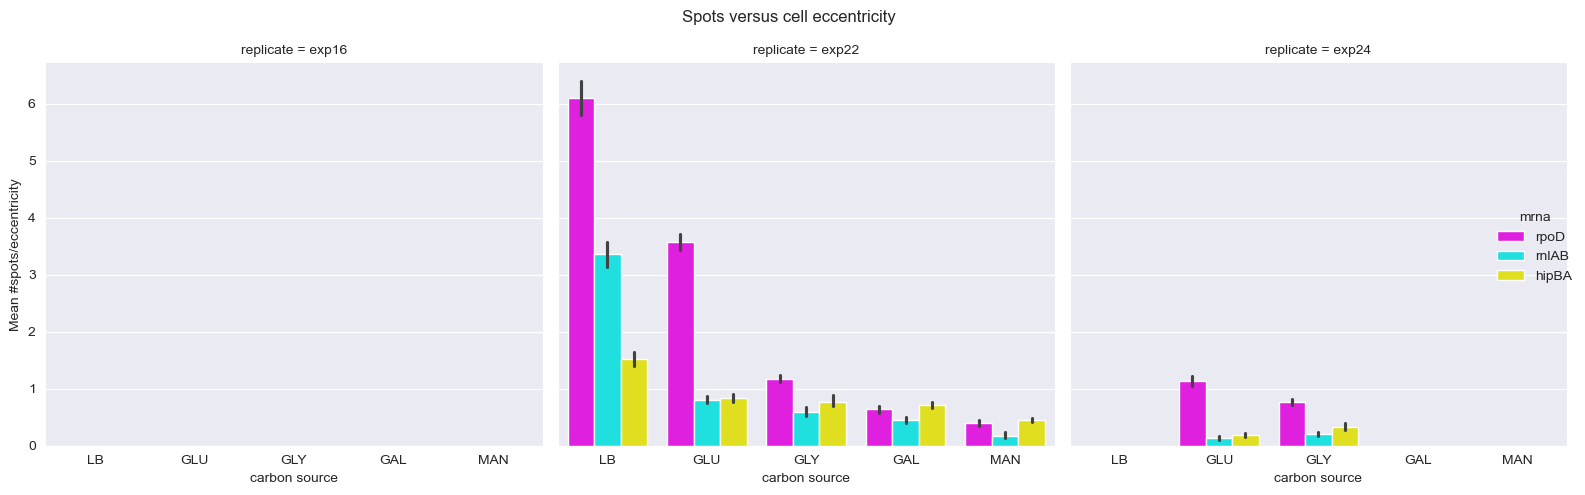

In [65]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_eccentricity', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/eccentricity')
g.fig.suptitle('Spots versus cell eccentricity')
plt.tight_layout();

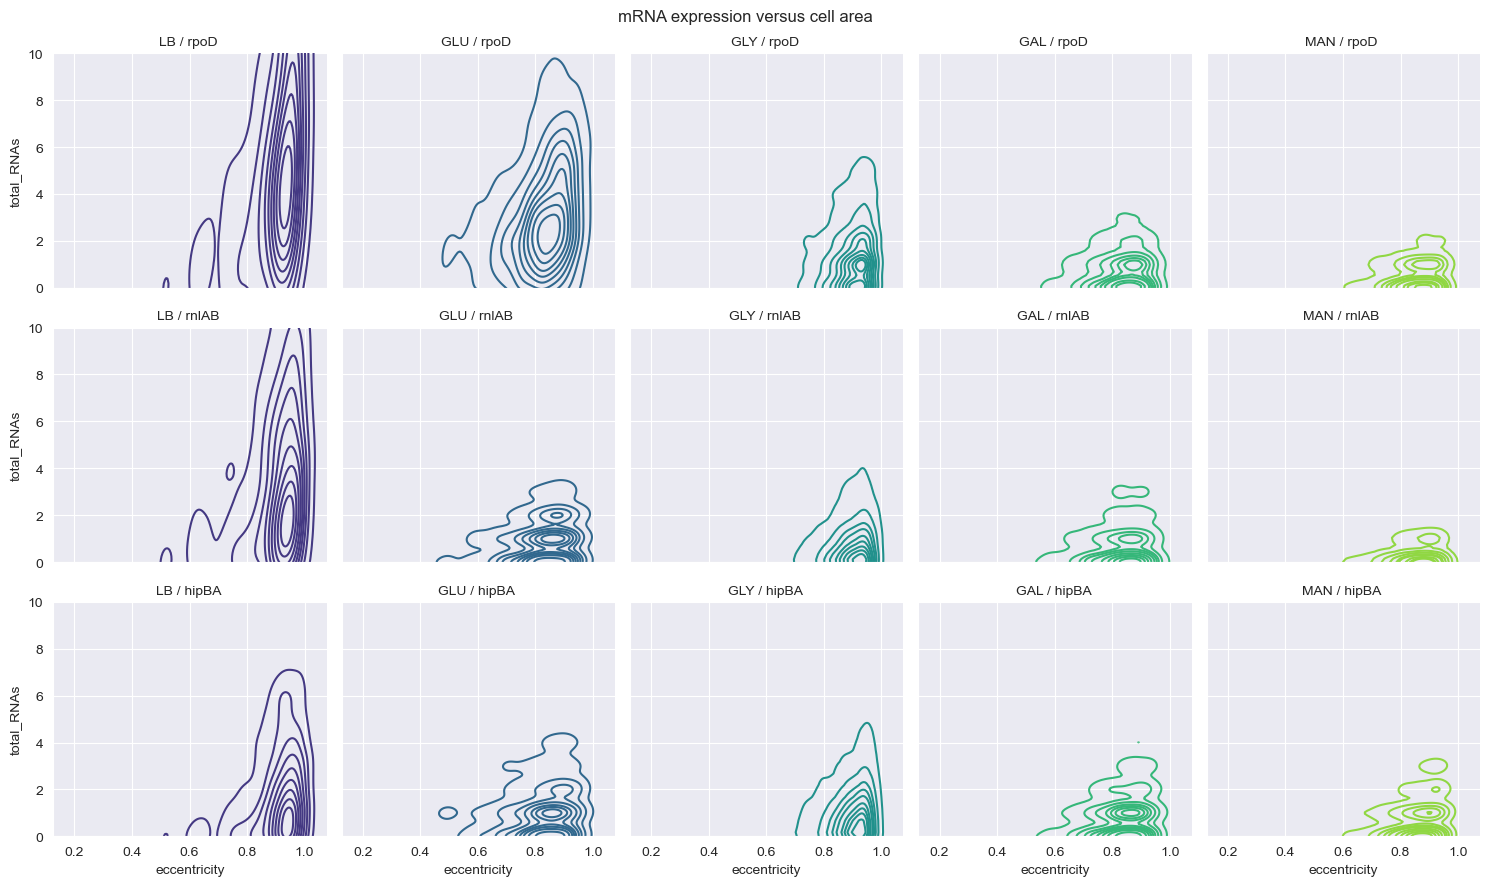

In [66]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  ylim=(0, 10),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='eccentricity', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### RNAs versus nucleoids

In [67]:
df_records_sane = df_records.query('total_RNAs_rpoD < 20').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')

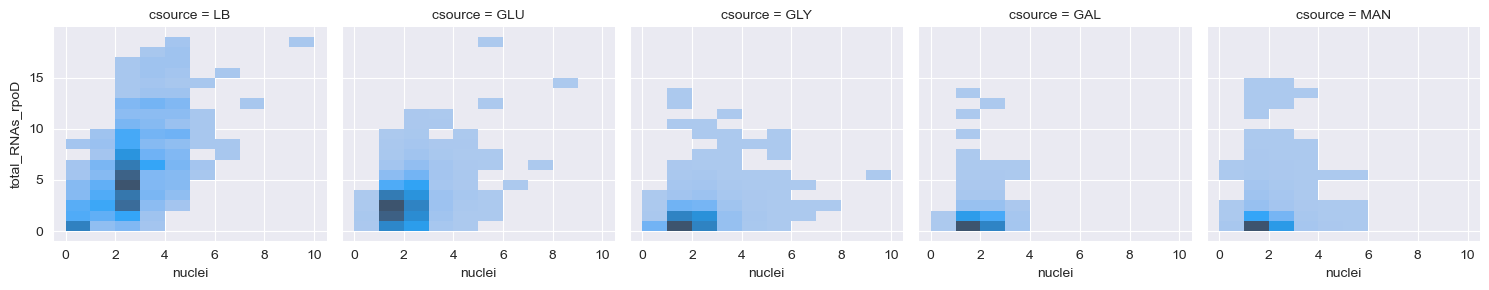

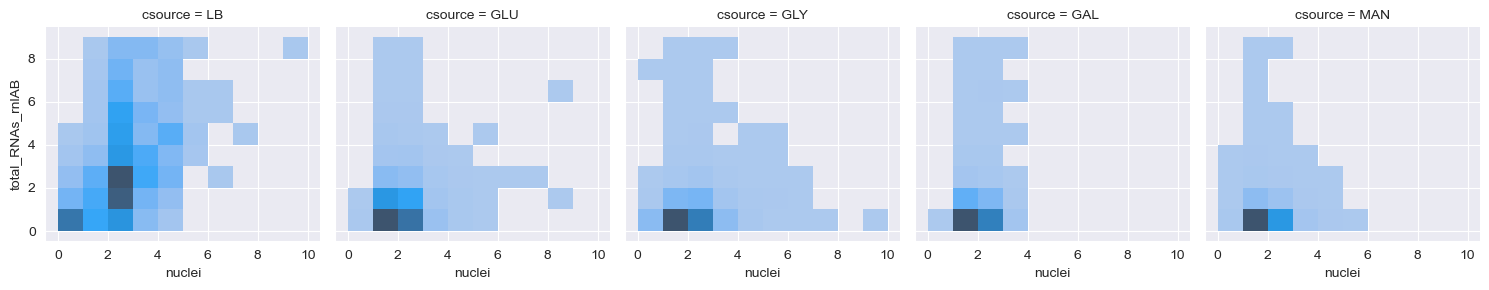

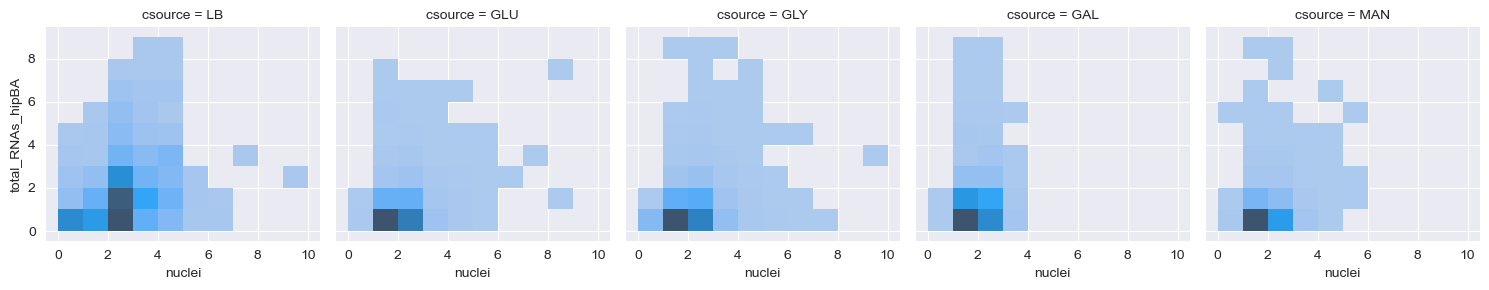

In [68]:
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, y='total_RNAs_rpoD', x='nuclei', binwidth=1)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, y='total_RNAs_rnlAB', x='nuclei', binwidth=1)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g3.map_dataframe(sns.histplot, y='total_RNAs_hipBA', x='nuclei', binwidth=1);

11/25/2024 07:07:58PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
11/25/2024 07:07:58PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 


(0.0, 0.0125)

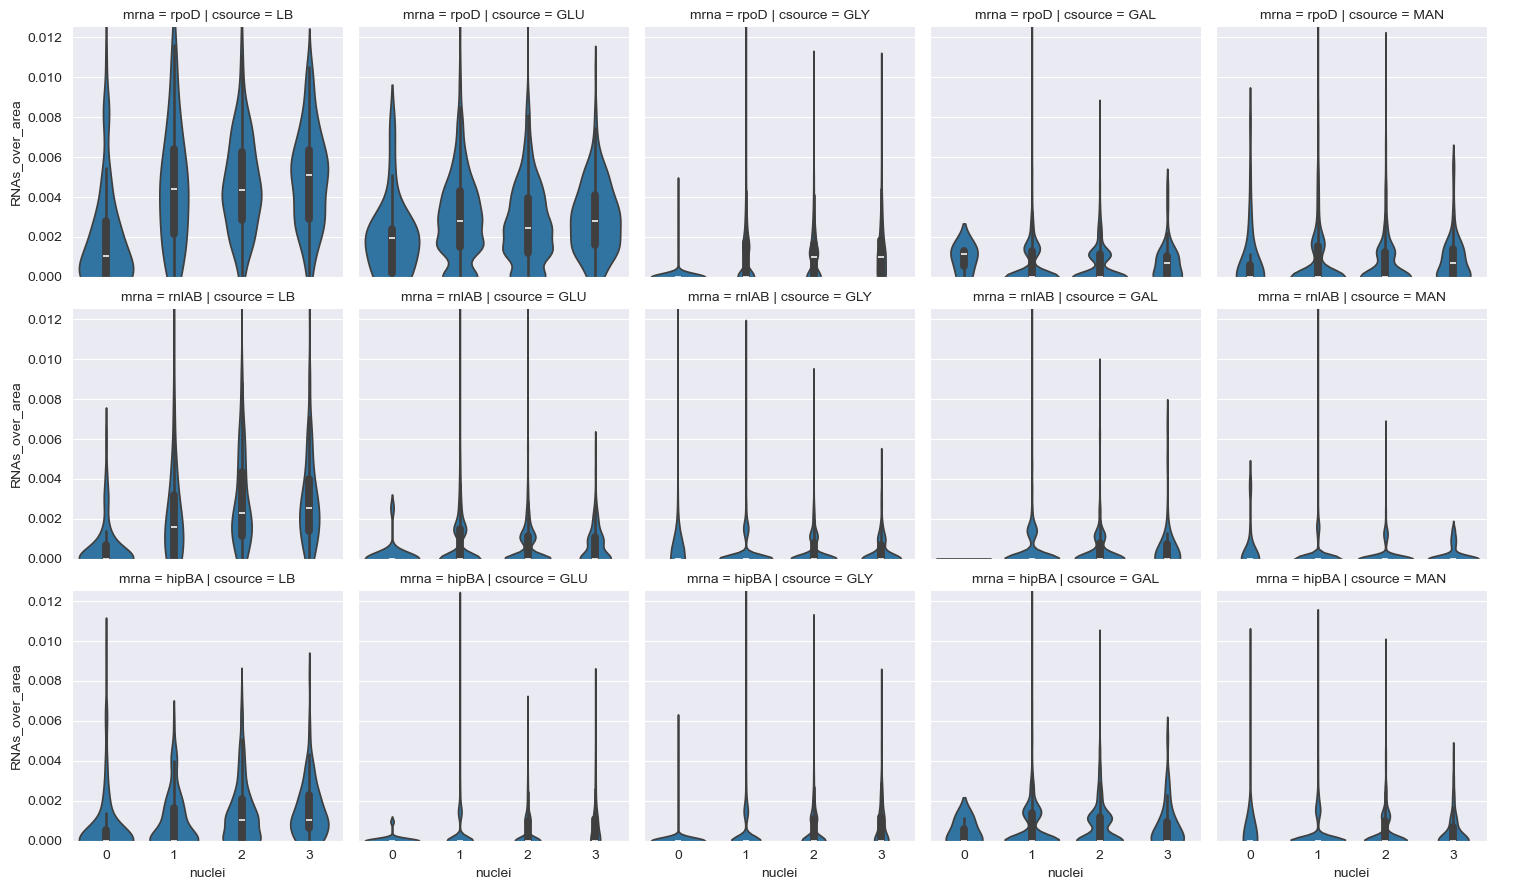

In [141]:

df_stacked_sane = df_stacked.query('total_RNAs < 10').query('nuclei < 4')
sns.catplot(data=df_stacked_sane, kind='violin', x='nuclei', y='RNAs_over_area',
            col='csource', col_order=csources_ordered,
            row='mrna', row_order=mrna_ordered, height=3)
plt.ylim(0, 0.0125)

### Co-expression

#### 2D histograms

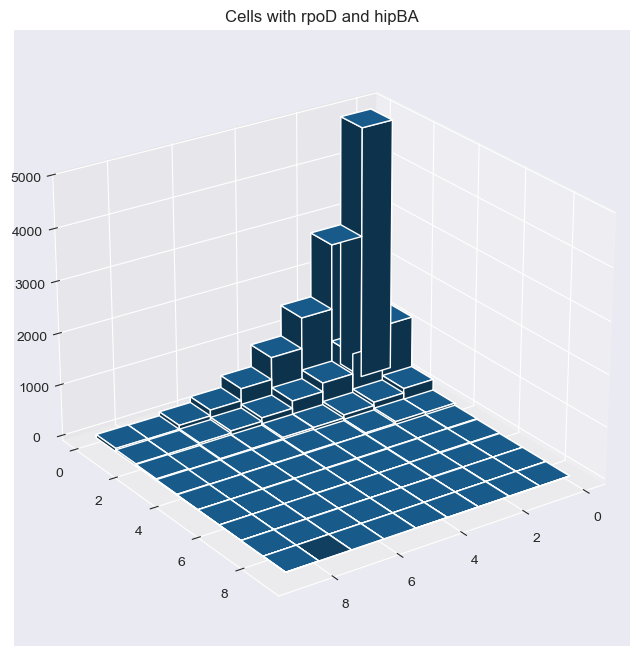

In [70]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
x, y = df_records_sane['total_RNAs_rpoD'], df_records_sane['total_RNAs_hipBA']
hist, xedges, yedges = np.histogram2d(y, x, bins=9, range=[[0, 9], [0, 9]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="xy")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 1
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.view_init(25, 55)
plt.title("Cells with rpoD and hipBA")
plt.show()

In [71]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'spots_hipBA', 'dense_regions_hipBA',
       'decomposed_RNAs_hipBA', 'tx_hipBA', 'nascent_RNAs_hipBA',
       'total_RNAs_hipBA', 'spots_rnlAB', 'dense_regions_rnlAB',
       'decomposed_RNAs_rnlAB', 'tx_rnlAB', 'nascent_RNAs_rnlAB',
       'total_RNAs_rnlAB', 'spots_rpoD', 'dense_regions_rpoD',
       'decomposed_RNAs_rpoD', 'tx_rpoD', 'nascent_RNAs_rpoD',
       'total_RNAs_rpoD', 'strain', 'condition', 'seqnr', 'image',
       'experiment', 'csource', 'coverslip', 'replicate', 'unique_cell_id',
       'selected', 'mu', 'volume', 'volume_ellipsoid', 'RNAs_over_area_rpoD',
       'RNAs_over_vol_rpoD', 'RNAs_over_area_rnlAB', 'RNAs_over_vol_rnlAB',
       'RNAs_over_area_hipBA', 'RNAs_over_vol_hipBA'],
      dtype='object')

#### Density plots

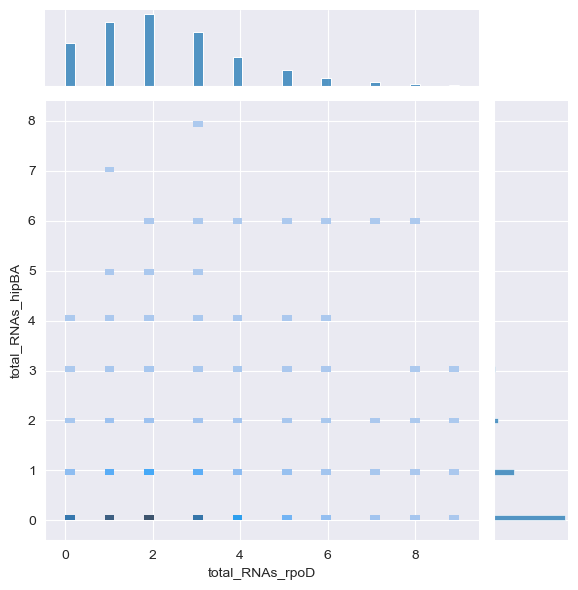

In [72]:
df_records_sane = df_records.query('total_RNAs_rpoD < 10').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')
sns.jointplot(data=df_records_sane.query('csource == "GLU"'), x='total_RNAs_rpoD', y='total_RNAs_hipBA', kind='hist');

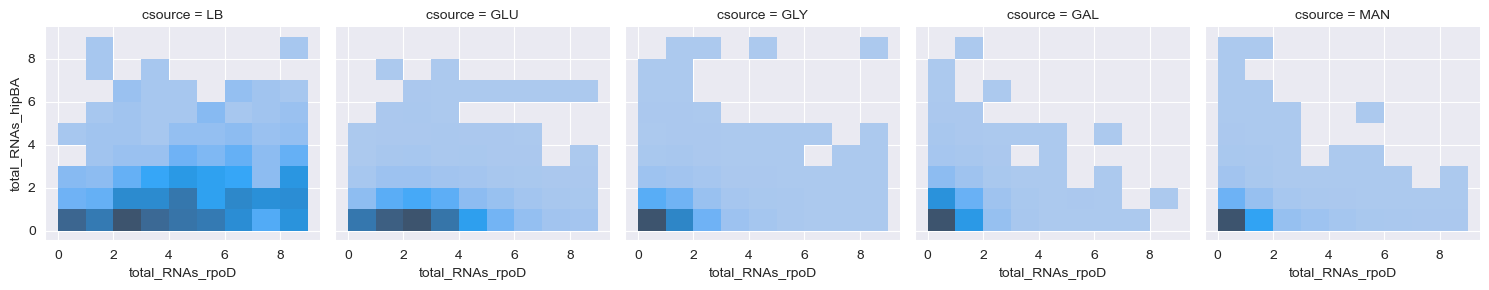

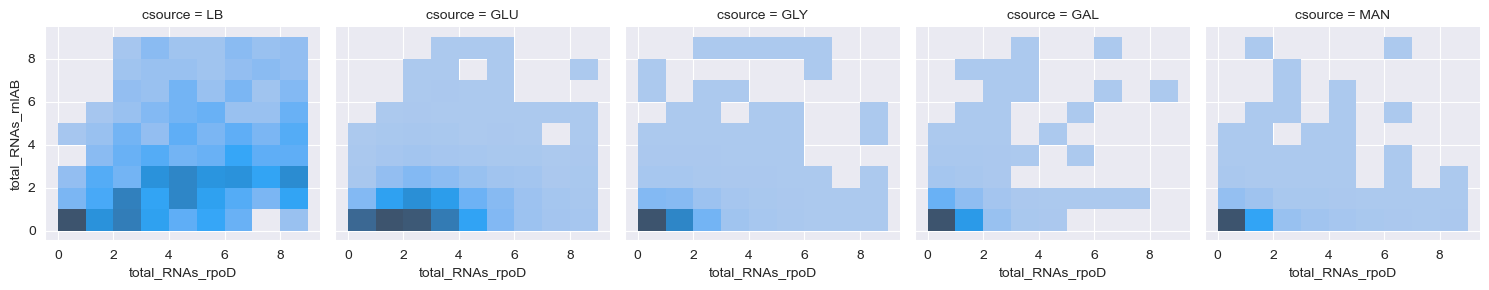

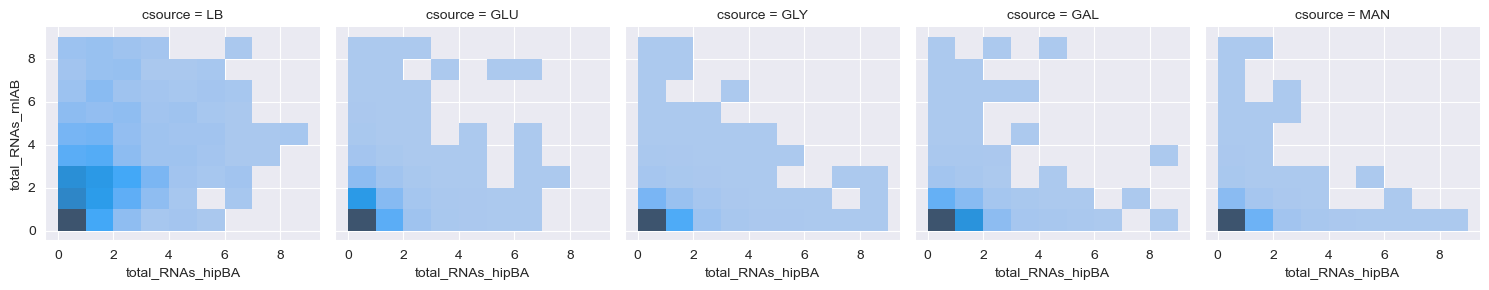

In [73]:
fill=True
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', binwidth=1)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', binwidth=1)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True,
# heatmap with absolute numbers
# toxin vs toxin minus the non expressing cells
# do cells with zero rpoD have more TA


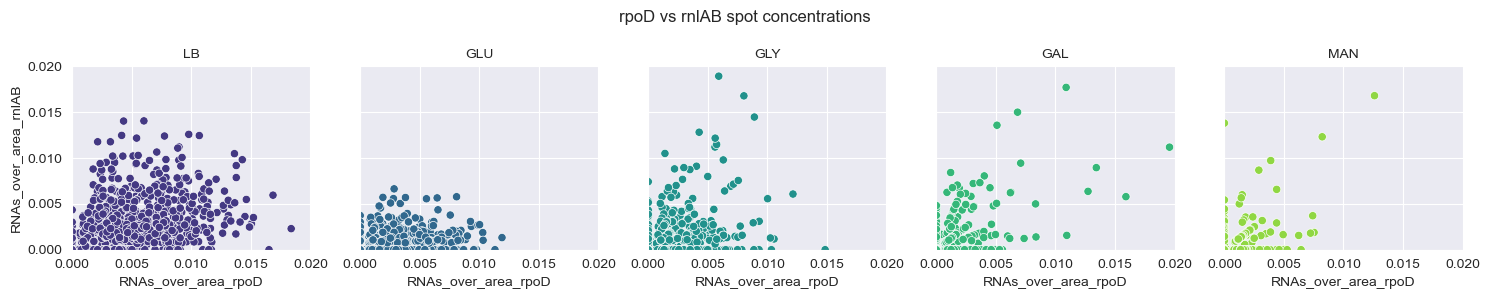

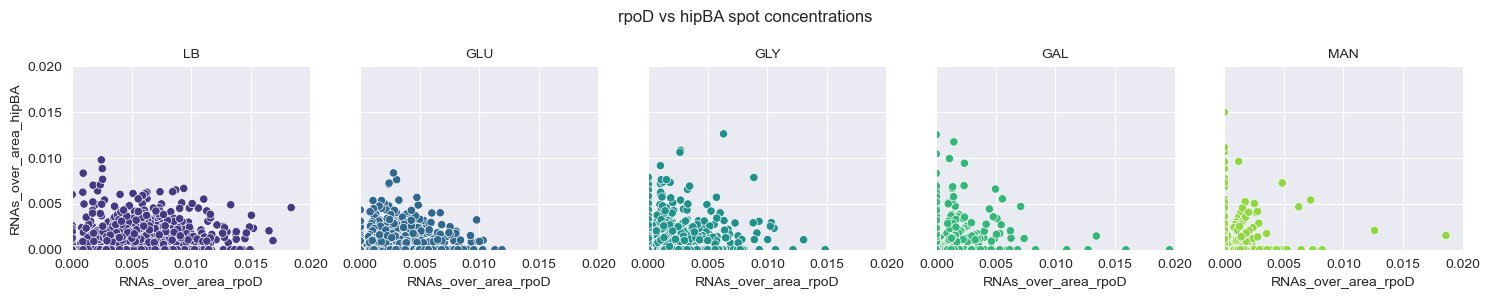

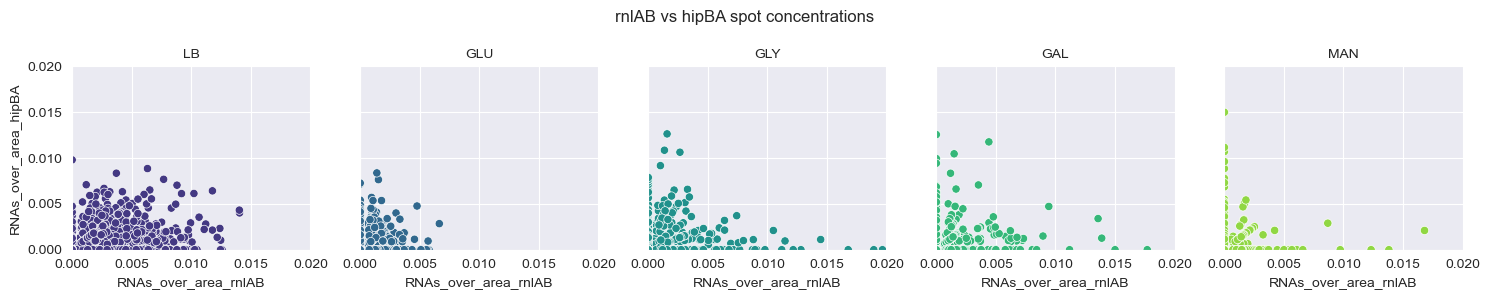

In [228]:
g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 0.02), ylim=(0, 0.02),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rpoD', y='RNAs_over_area_rnlAB', hue='csource', palette=palette_csource)
g.set_titles('{col_name}')
g.fig.suptitle('rpoD vs rnlAB spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rpoD-rnlAB_exp22"
plt.savefig(savestem + ".pdf");

g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 0.02), ylim=(0, 0.02),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rpoD', y='RNAs_over_area_hipBA', hue='csource', palette=palette_csource)
g.set_titles('{col_name}');
g.fig.suptitle('rpoD vs hipBA spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rpoD-hipBA_exp22"
plt.savefig(savestem + ".pdf");

g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 0.02), ylim=(0, 0.02),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rnlAB', y='RNAs_over_area_hipBA', hue='csource', palette=palette_csource)
g.set_titles('{col_name}');
g.fig.suptitle('rnlAB vs hipBA spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rnlAB-hipBA_exp22"
plt.savefig(savestem + ".pdf");

#### Fraction of cells with two RNAs

In [57]:
data = df_records.query('replicate == "exp22"')

In [58]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': data.groupby('csource').size().reindex(csources_ordered),
    'rpoD': data.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': data.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': data.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': data.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': data.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': data.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

total  rpoD  rnlAB  hipBA  rnlAB&hipBA  rnlAB&rpoD  hipBA&rpoD  \
csource                                                                   
LB         813   758    671    517          470         659         500   
GLU       1399  1291    629    619          296         591         578   
GLY       2405  1406    721   1024          349         502         627   
GAL       1955   717    471    797          213         214         310   
MAN       1885   489    187    508           57          83         156   

         %rpoD  %rnlAB  %hipBA  %rnlAB*%hipBA  %rnlAB&hipBA  %rnlAB&rpoD  \
csource                                                                    
LB        0.93    0.83    0.64           0.52          0.58         0.81   
GLU       0.92    0.45    0.44           0.20          0.21         0.42   
GLY       0.58    0.30    0.43           0.13          0.15         0.21   
GAL       0.37    0.24    0.41           0.10          0.11         0.11   
MAN       0.26    0.10    0.27           0.03          0.03         0.04   

         %hipBA&rpoD  
csource               
LB              0.62  
GLU             0.41  
GLY             0.26  
GAL             0.16  
MAN             0.08

In [59]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': data.groupby('csource').size().reindex(csources_ordered),
    'rpoD': data.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': data.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': data.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': data.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': data.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': data.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

total  rpoD  rnlAB  hipBA  rnlAB&hipBA  rnlAB&rpoD  hipBA&rpoD  \
csource                                                                   
LB         813   758    671    517          470         659         500   
GLU       1399  1291    629    619          296         591         578   
GLY       2405  1406    721   1024          349         502         627   
GAL       1955   717    471    797          213         214         310   
MAN       1885   489    187    508           57          83         156   

         %rpoD  %rnlAB  %hipBA  %rnlAB*%hipBA  %rnlAB&hipBA  %rnlAB&rpoD  \
csource                                                                    
LB        0.93    0.83    0.64           0.52          0.58         0.81   
GLU       0.92    0.45    0.44           0.20          0.21         0.42   
GLY       0.58    0.30    0.43           0.13          0.15         0.21   
GAL       0.37    0.24    0.41           0.10          0.11         0.11   
MAN       0.26    0.10    0.27           0.03          0.03         0.04   

         %hipBA&rpoD  
csource               
LB              0.62  
GLU             0.41  
GLY             0.26  
GAL             0.16  
MAN             0.08

In [61]:
all_frequencies = pd.DataFrame()

total_cells = data.groupby('csource').size().reindex(csources_ordered)

for mrna in ['rpoD', 'rnlAB', 'hipBA']:
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna
    df_mrna['cardinality'] = 1
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 2):
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1]
    df_mrna['cardinality'] = 2
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 3):
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').query(f'spots_{mrna_pair[2]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1] + '_' + mrna_pair[2]
    df_mrna['cardinality'] = 3
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[2]')['fraction']

    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
all_frequencies

counts          mrna_set  cardinality  total  fraction  expected
csource                                                                  
LB          758              rpoD            1    813      0.93       NaN
GLU        1291              rpoD            1   1399      0.92       NaN
GLY        1406              rpoD            1   2405      0.58       NaN
GAL         717              rpoD            1   1955      0.37       NaN
MAN         489              rpoD            1   1885      0.26       NaN
LB          671             rnlAB            1    813      0.83       NaN
GLU         629             rnlAB            1   1399      0.45       NaN
GLY         721             rnlAB            1   2405      0.30       NaN
GAL         471             rnlAB            1   1955      0.24       NaN
MAN         187             rnlAB            1   1885      0.10       NaN
LB          517             hipBA            1    813      0.64       NaN
GLU         619             hipBA            1   1399      0.44       NaN
GLY        1024             hipBA            1   2405      0.43       NaN
GAL         797             hipBA            1   1955      0.41       NaN
MAN         508             hipBA            1   1885      0.27       NaN
LB          659        rpoD_rnlAB            2    813      0.81  7.70e-01
GLU         591        rpoD_rnlAB            2   1399      0.42  4.15e-01
GLY         502        rpoD_rnlAB            2   2405      0.21  1.75e-01
GAL         214        rpoD_rnlAB            2   1955      0.11  8.84e-02
MAN          83        rpoD_rnlAB            2   1885      0.04  2.57e-02
LB          500        rpoD_hipBA            2    813      0.62  5.93e-01
GLU         578        rpoD_hipBA            2   1399      0.41  4.08e-01
GLY         627        rpoD_hipBA            2   2405      0.26  2.49e-01
GAL         310        rpoD_hipBA            2   1955      0.16  1.50e-01
MAN         156        rpoD_hipBA            2   1885      0.08  6.99e-02
LB          470       rnlAB_hipBA            2    813      0.58  5.25e-01
GLU         296       rnlAB_hipBA            2   1399      0.21  1.99e-01
GLY         349       rnlAB_hipBA            2   2405      0.15  1.28e-01
GAL         213       rnlAB_hipBA            2   1955      0.11  9.82e-02
MAN          57       rnlAB_hipBA            2   1885      0.03  2.67e-02
LB          461  rpoD_rnlAB_hipBA            3    813      0.57  4.89e-01
GLU         281  rpoD_rnlAB_hipBA            3   1399      0.20  1.84e-01
GLY         243  rpoD_rnlAB_hipBA            3   2405      0.10  7.46e-02
GAL         101  rpoD_rnlAB_hipBA            3   1955      0.05  3.60e-02
MAN          35  rpoD_rnlAB_hipBA            3   1885      0.02  6.94e-03

##### Plot - all data

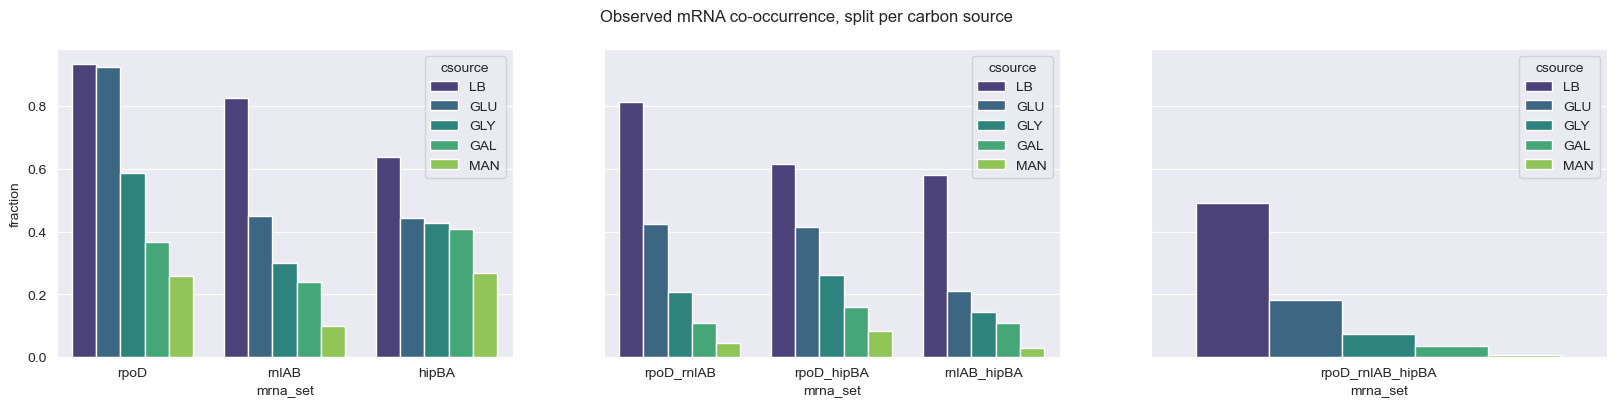

In [69]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

##### Plot - only exp22 data

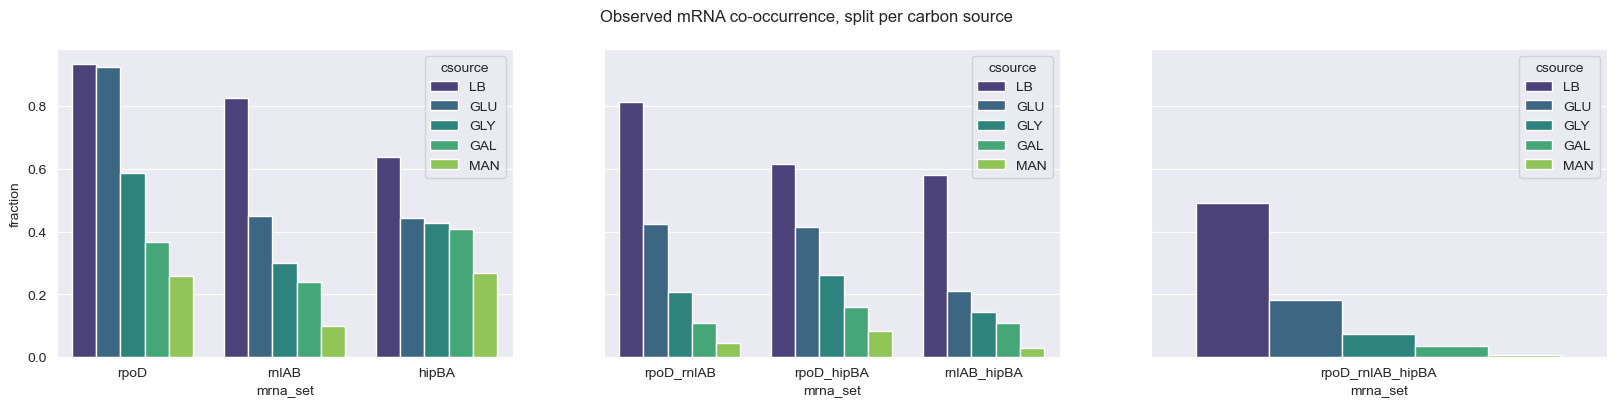

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

##### Plot - all data

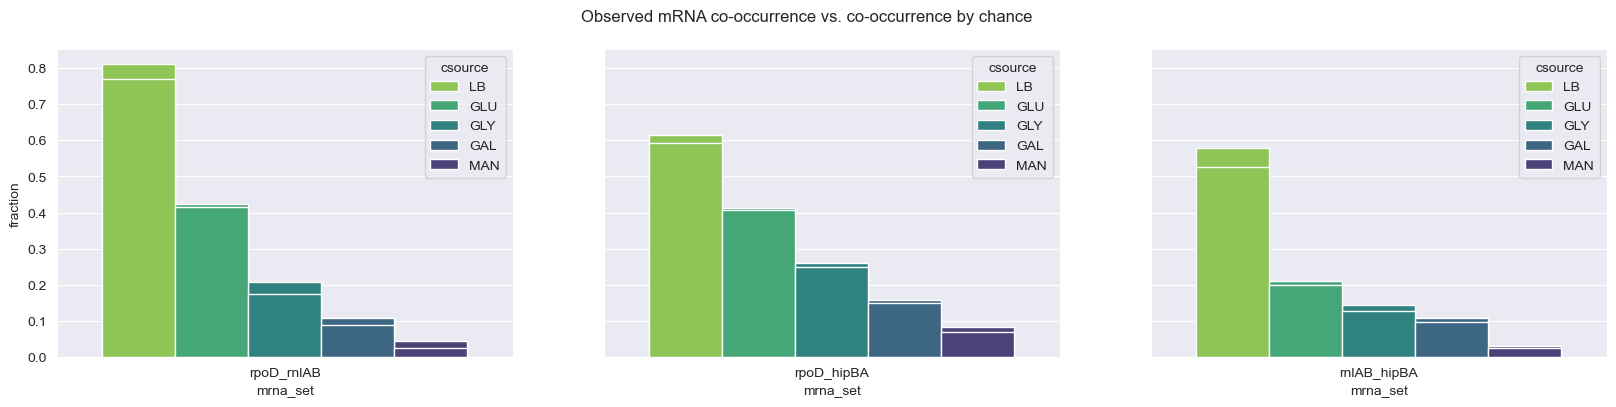

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

##### Plot - only exp22 data

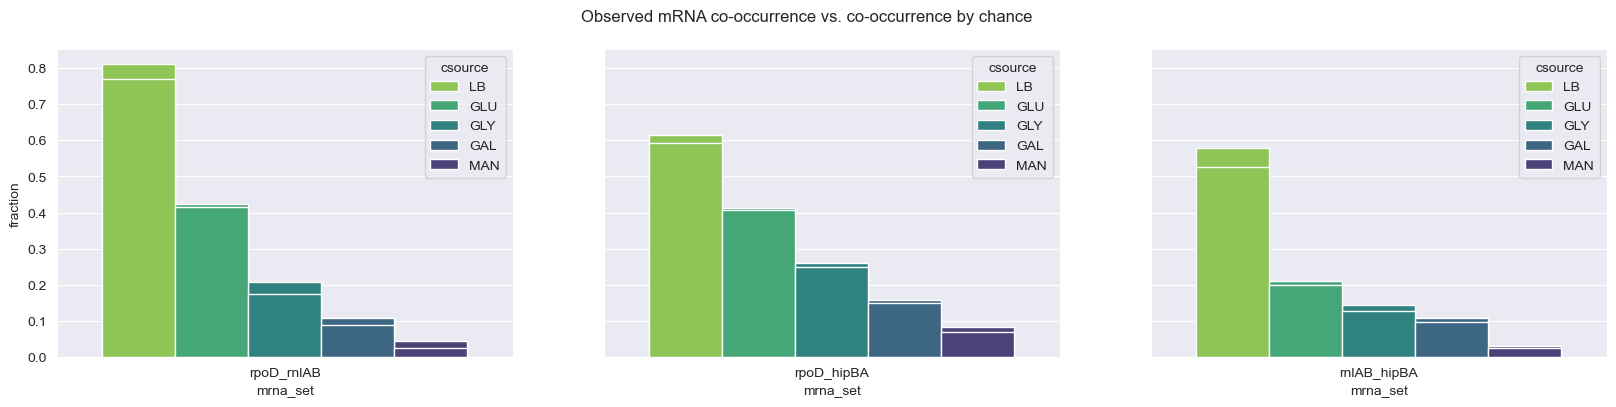

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

##### Plot - all data

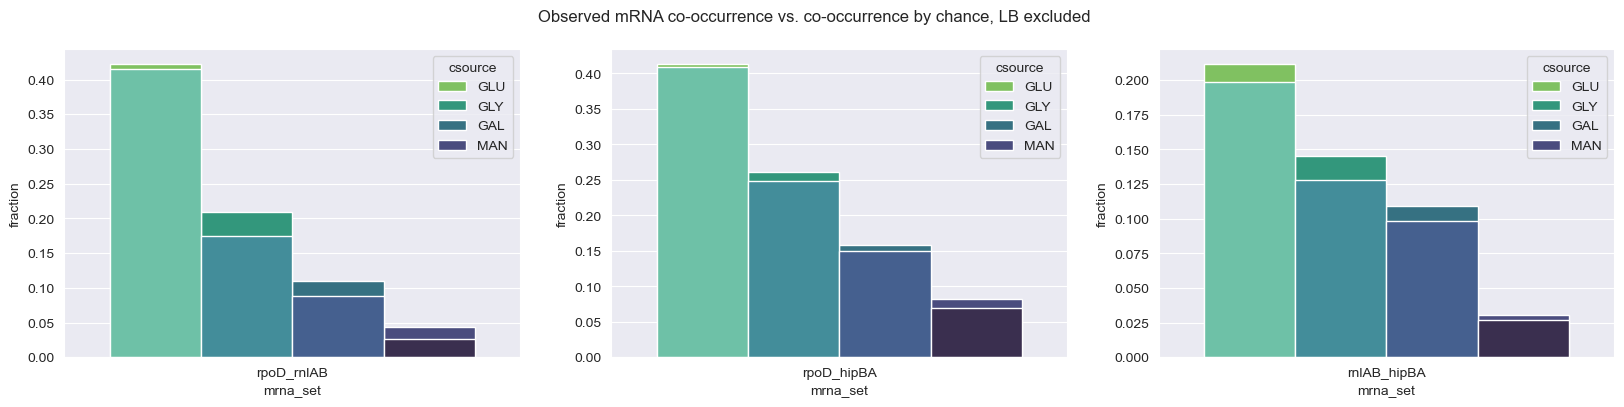

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance, LB excluded')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[2], legend=False)

##### Plot - only exp22 data

/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_74999/266161668.py:7: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[0], legend=False)
/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_74999/266161668.py:10: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[1], legend=False)
/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_74999/266161668.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('cs

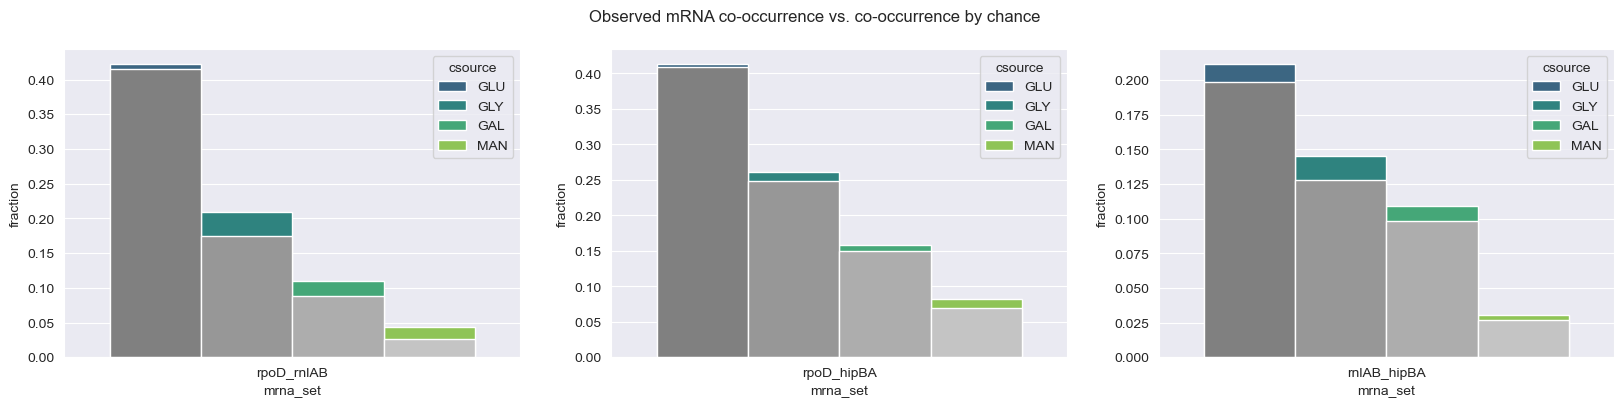

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

greys = sns.light_palette("grey", reverse=True)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[2], legend=False)

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/cooccurrences"
plt.savefig(savestem + ".pdf")

In [1600]:
all_frequencies

counts          mrna_set  cardinality  total  fraction  expected
csource                                                                  
LB          758              rpoD            1    813      0.93       NaN
GLU        1291              rpoD            1   1399      0.92       NaN
GLY        1406              rpoD            1   2405      0.58       NaN
GAL         717              rpoD            1   1955      0.37       NaN
MAN         489              rpoD            1   1885      0.26       NaN
LB          671             rnlAB            1    813      0.83       NaN
GLU         629             rnlAB            1   1399      0.45       NaN
GLY         721             rnlAB            1   2405      0.30       NaN
GAL         471             rnlAB            1   1955      0.24       NaN
MAN         187             rnlAB            1   1885      0.10       NaN
LB          517             hipBA            1    813      0.64       NaN
GLU         619             hipBA            1   1399      0.44       NaN
GLY        1024             hipBA            1   2405      0.43       NaN
GAL         797             hipBA            1   1955      0.41       NaN
MAN         508             hipBA            1   1885      0.27       NaN
LB          659        rpoD_rnlAB            2    813      0.81  7.70e-01
GLU         591        rpoD_rnlAB            2   1399      0.42  4.15e-01
GLY         502        rpoD_rnlAB            2   2405      0.21  1.75e-01
GAL         214        rpoD_rnlAB            2   1955      0.11  8.84e-02
MAN          83        rpoD_rnlAB            2   1885      0.04  2.57e-02
LB          500        rpoD_hipBA            2    813      0.62  5.93e-01
GLU         578        rpoD_hipBA            2   1399      0.41  4.08e-01
GLY         627        rpoD_hipBA            2   2405      0.26  2.49e-01
GAL         310        rpoD_hipBA            2   1955      0.16  1.50e-01
MAN         156        rpoD_hipBA            2   1885      0.08  6.99e-02
LB          470       rnlAB_hipBA            2    813      0.58  5.25e-01
GLU         296       rnlAB_hipBA            2   1399      0.21  1.99e-01
GLY         349       rnlAB_hipBA            2   2405      0.15  1.28e-01
GAL         213       rnlAB_hipBA            2   1955      0.11  9.82e-02
MAN          57       rnlAB_hipBA            2   1885      0.03  2.67e-02
LB          461  rpoD_rnlAB_hipBA            3    813      0.57  4.89e-01
GLU         281  rpoD_rnlAB_hipBA            3   1399      0.20  1.84e-01
GLY         243  rpoD_rnlAB_hipBA            3   2405      0.10  7.46e-02
GAL         101  rpoD_rnlAB_hipBA            3   1955      0.05  3.60e-02
MAN          35  rpoD_rnlAB_hipBA            3   1885      0.02  6.94e-03

#### Area and eccentricity of cells with 1, 2, or 3 of the RNAs


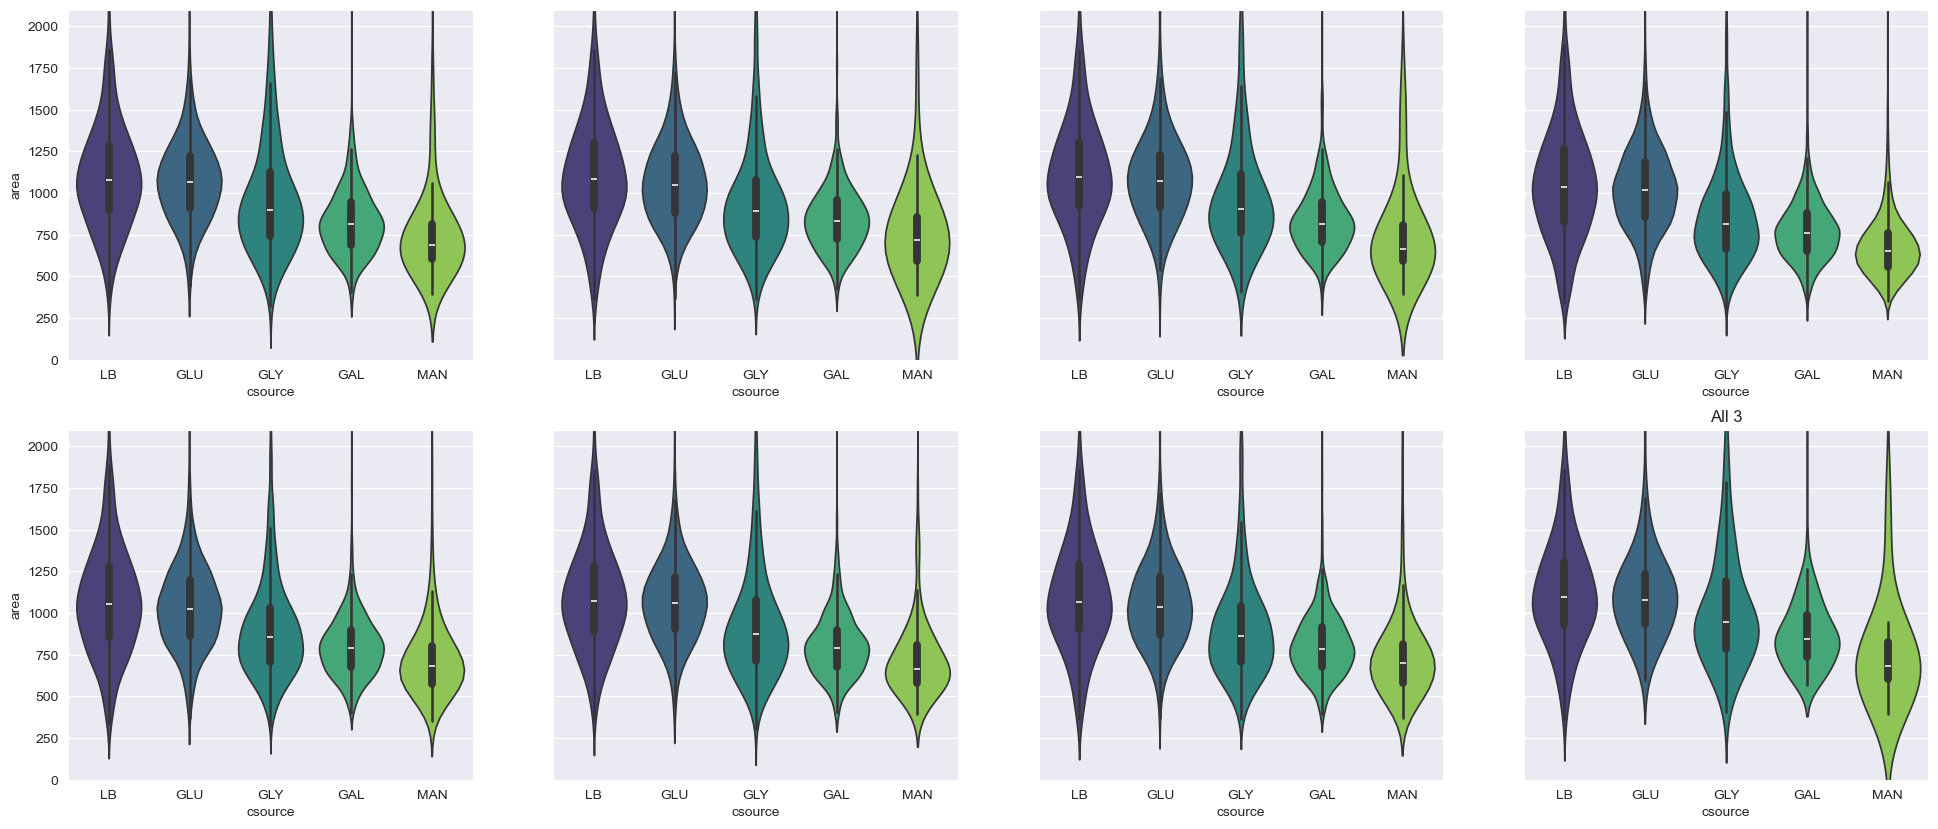

In [133]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
ax[0][0].set_ylim(0, 2100)
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][2])
sns.violinplot(data=df_records.query('replicate == "exp22"'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][3])

sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][2])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][3]).set_title("All 3");


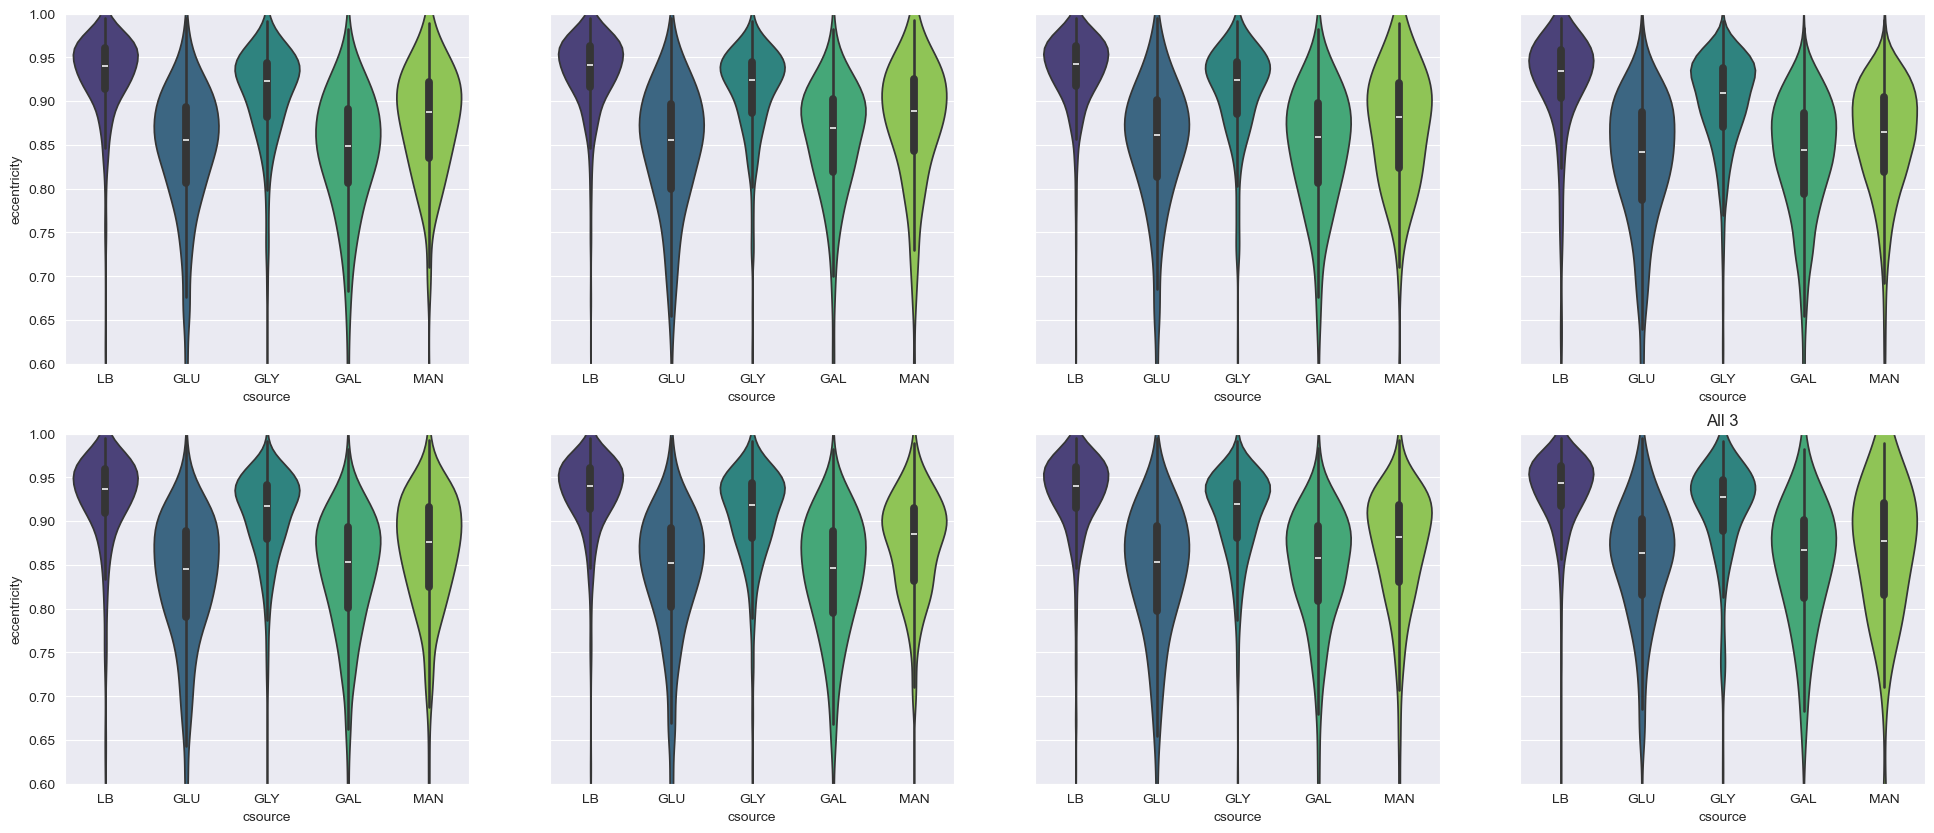

In [136]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
ax[0][0].set_ylim(0.6, 1)
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][2])
sns.violinplot(data=df_records.query('replicate == "exp22"'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][3])

sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][2])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][3]).set_title("All 3");


### Localisation

#### Distance of spots to cell centroid/closest cell tip
 

In [1955]:
df_stacked.columns


Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'nuclei', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'RNAs_over_area', 'volume',
       'volume_ellipsoid', 'RNAs_over_vol', 'RNAs_over_length', 'mu',
       'RNAs_over_eccentricity'],
      dtype='object')

#### Distance of spots to cell mask

#### Distance of spots to closest nucleoid tip

#### Distance of spots to nuclei


### Transcription sites

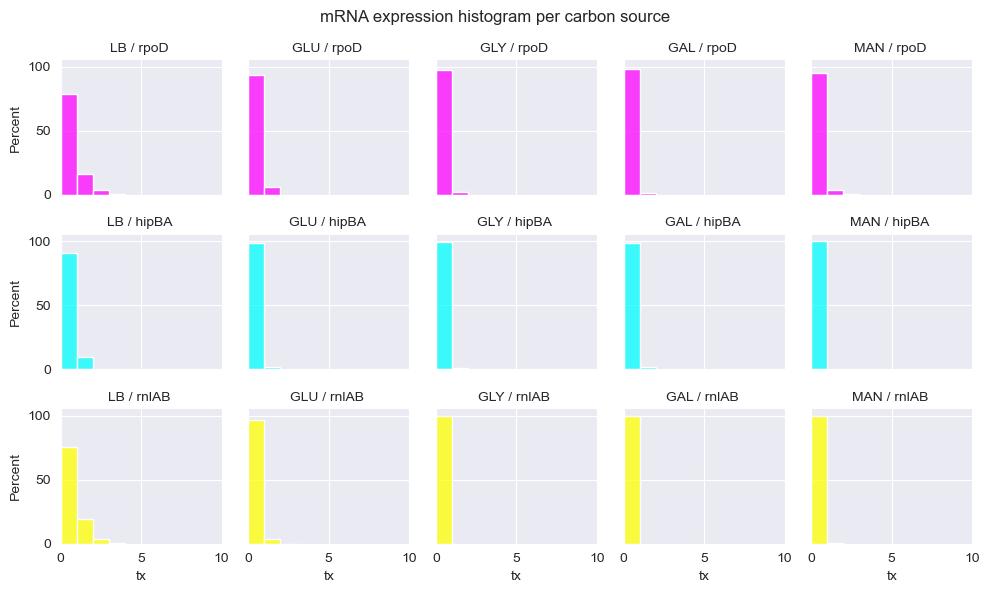

In [671]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='tx', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();


## Quality control

### Inspect images individually

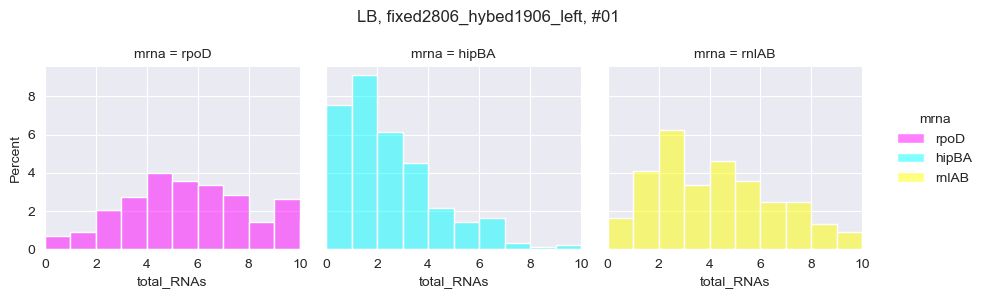

In [672]:
image = 'MG1655_LB_fixed2806_hybed1906_left_01'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

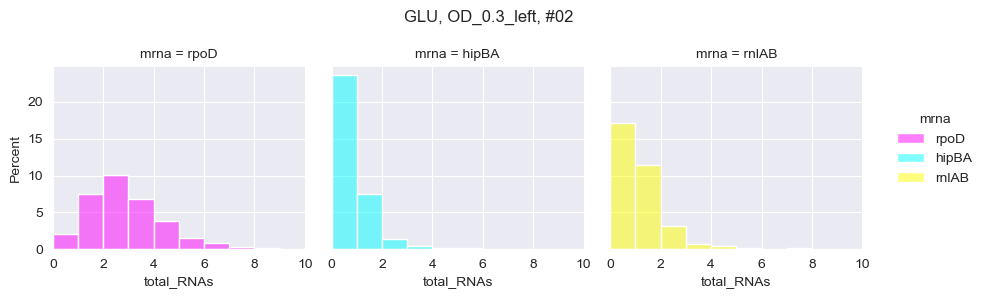

In [673]:
image = 'MG1655_GLU_OD_0.3_left_02'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

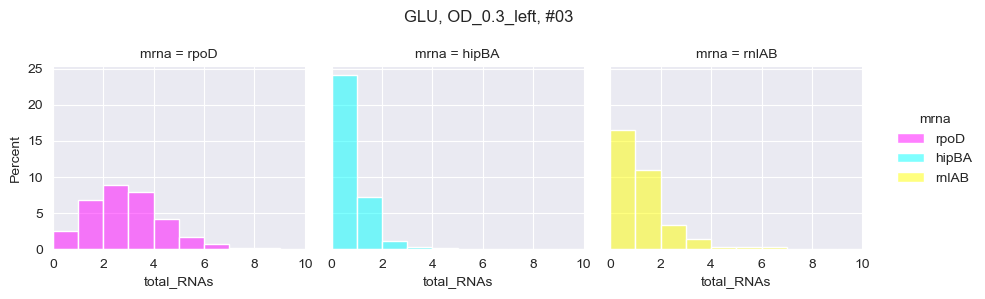

In [674]:
image = 'MG1655_GLU_OD_0.3_left_03'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

### Spot intensity histograms
Spots in cells versus spots outside cells

See `intensities.ipynb` notebook.